### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary


In [18]:
# to selectively re-import as needed
# import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [19]:
from datetime import datetime
import os
import yaml
import sqlite3
import json
from collections import Counter
import uuid
from typing import TypedDict, Annotated

import operator
import pickle

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
# from langchain.agents import create_tool_calling_agent, AgentExecutor
# from langchain.memory import ChatMessageHistory
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
# from langchain.tools import BaseTool, StructuredTool, tool
# from langchain_community.chat_models import ChatOllama
# from langchain_community.tools.tavily_search import TavilySearchResults
# from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser
# from langchain.callbacks.base import AsyncCallbackHandler, BaseCallbackHandler
# from langchain_core.outputs import LLMResult

from langgraph.graph import StateGraph, START, END

import numpy as np
import pandas as pd
import umap
# import matplotlib.pyplot as plt

import sklearn
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

import bs4
# from bs4 import BeautifulSoup
# import requests
from urllib.parse import urljoin, urlparse

import multiprocessing
# from concurrent.futures import ThreadPoolExecutor, as_completed
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

# import smtplib
# from email.mime.multipart import MIMEMultipart
# from email.mime.text import MIMEText

import openai
from openai import OpenAI

import trafilatura

VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, TOP_CATEGORIES_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST,
                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens, 
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")


LangChain         0.3.0
OpenAI            1.47.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.6


In [4]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


2024-09-24 09:52:02,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Ascoltami. Sei bellissima. Sei perfetta e ti amo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 34, 'total_tokens': 50, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'chatgpt-4o-latest', 'system_fingerprint': 'fp_61e551c4c2', 'finish_reason': 'stop', 'logprobs': None}, id='run-67fad581-1cf8-4d2e-8619-f6bc39c3953b-0', usage_metadata={'input_tokens': 34, 'output_tokens': 16, 'total_tokens': 50})

In [5]:
# use template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


2024-09-24 09:52:04,452 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Ciao'

In [6]:
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


2024-09-24 09:52:08,959 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es impeccable. Tu es magnifique et je t'aime.

2024-09-24 09:52:09,675 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.

2024-09-24 09:52:10,802 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecta. Eres hermosa y te amo.

2024-09-24 09:52:11,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei fantastico. Sei magnifico e ti amo.

2024-09-24 09:52:13,258 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Figyelj rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.

Elapsed seconds: 6.146298


In [7]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


2024-09-24 09:52:14,882 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-24 09:52:15,039 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-24 09:52:15,208 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-24 09:52:15,424 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-09-24 09:52:15,615 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Elapsed seconds: 1.568420
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecta. Eres hermosa y te amo.
Ascoltami. Sei fantastico. Sei magnifico e ti amo.
Figyelj rám. Elragadó vagy. Lenyűgöző vagy, és szeretlek.


In [8]:
DEBUG = True
N_BROWSERS = 4

In [9]:
# class to maintain settings and state within graph

class AgentState(TypedDict):
    AIdf: dict                #  the current working set of headlines (pandas dataframe not supported)
    before_date: str          #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool         #  if False use existing files, else download from sources
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources
    headline_str: str         #  headline text email
    bullets: str              #  bullet point summary email
    summary: str              #  final summary
    n_edits: int              #  count edit iterations so we don't keep editing forever
    edit_complete: bool       #  edit will update if no more edits to make
    # message thread with OpenAI
    messages: Annotated[list[AnyMessage], operator.add]


In [10]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = AgentState()
    fn_initialize(test_state)


2024-09-24 09:52:18,961 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-09-24 09:52:18,962 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-09-24 09:52:18,962 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/technology -> Bloomberg Technology.html
2024-09-24 09:52:18,962 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-09-24 09:52:18,963 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-09-24 09:52:18,963 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-09-24 09:52:18,963 - AInewsbot -

In [11]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state["do_download"]:
        # empty download directory
        delete_files(DOWNLOAD_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # don't delete, just get list of existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state["do_download"] = True
#     test_state["before_date"] = '2024-09-22 12:00:00'
    _ = fn_download_sources(test_state)


2024-09-24 09:52:27,722 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2024-09-24 09:52:27,724 - AInewsbot - INFO - Found 17 previously downloaded files
2024-09-24 09:52:27,724 - AInewsbot - INFO - htmldata/The Verge AI (09_24_2024 07_42_38 AM).html
2024-09-24 09:52:27,725 - AInewsbot - INFO - htmldata/Business Insider Tech (09_24_2024 07_41_55 AM).html
2024-09-24 09:52:27,725 - AInewsbot - INFO - htmldata/The Register (09_24_2024 07_42_29 AM).html
2024-09-24 09:52:27,726 - AInewsbot - INFO - htmldata/VentureBeat AI (09_24_2024 07_42_39 AM).html
2024-09-24 09:52:27,726 - AInewsbot - INFO - htmldata/Feedly AI (09_24_2024 07_43_15 AM).html
2024-09-24 09:52:27,727 - AInewsbot - INFO - htmldata/Google News - Technology - Artificial intelligence (09_24_2024 07_42_16 AM).html
2024-09-24 09:52:27,727 - AInewsbot - INFO - htmldata/Techmeme (09_24_2024 07_42_27 AM).html
2024-09-24 09:52:27,727 - AInewsbot - INFO - htmldata/Ars Technica (09_24_2024 07_41_56 AM).html
20

In [12]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict()

    return state


if DEBUG:
    _ = fn_extract_urls(test_state)



2024-09-24 09:52:34,149 - AInewsbot - INFO - Parsing html files
2024-09-24 09:52:34,151 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (09_24_2024 07_41_56 AM).html
2024-09-24 09:52:34,184 - AInewsbot - INFO - parse_file - found 252 raw links
2024-09-24 09:52:34,188 - AInewsbot - INFO - parse_file - found 28 filtered links
2024-09-24 09:52:34,188 - AInewsbot - INFO - 28 links found
2024-09-24 09:52:34,188 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology (09_24_2024 07_41_54 AM).html
2024-09-24 09:52:34,205 - AInewsbot - INFO - parse_file - found 210 raw links
2024-09-24 09:52:34,208 - AInewsbot - INFO - parse_file - found 26 filtered links
2024-09-24 09:52:34,208 - AInewsbot - INFO - 26 links found
2024-09-24 09:52:34,209 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider Tech (09_24_2024 07_41_55 AM).html
2024-09-24 09:52:34,231 - AInewsbot - INFO - parse_file - found 309 raw links
2024-09-24 09:52:34,235 - AInewsbot - INFO - parse_file 

In [13]:
# s/b 17 if some missing, maybe got a robot block, download manually and then re-run
print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
pd.DataFrame(test_state["AIdf"]).groupby('src').count()


17


,id,title,url
src,,,
Ars Technica,28,28,28
Bloomberg Tech,21,21,21
Business Insider,51,51,51
FT Tech,62,62,62
Feedly AI,58,58,58
Google News,73,73,73
Hacker News,25,25,25
Hacker News 2,21,21,21
HackerNoon,98,98,98


In [30]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state["AIdf"])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state["before_date"])

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique AI headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)
    
    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url}, '->', {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")

    # drop banned slop sites
    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]

    state["AIdf"] = AIdf.to_dict()
    return state


if DEBUG:
    before_date="2024-09-23 10:00:00"
    test_state["before_date"] = before_date
#     test_state["before_date"] = None
    _ = fn_filter_urls(test_state)


2024-09-24 10:01:11,474 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2024-09-23 10:00:00'
2024-09-24 10:01:12,041 - AInewsbot - INFO - URLs in orig_df: 131
2024-09-24 10:01:12,043 - AInewsbot - INFO - Existing URLs in DB: 149940
2024-09-24 10:01:12,067 - AInewsbot - INFO - New URLs in df filtered by URL: 131
2024-09-24 10:01:12,140 - AInewsbot - INFO - Existing src+title: 0
2024-09-24 10:01:12,140 - AInewsbot - INFO - New URLs in df filtered by src+title: 131
2024-09-24 10:01:12,149 - AInewsbot - INFO - Found 131 unique AI headlines
2024-09-24 10:01:12,152 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-09-24 10:01:12,153 - AInewsbot - INFO - sent 50 items 
2024-09-24 10:01:12,153 - AInewsbot - INFO - sent 50 items 
2024-09-24 10:01:12,153 - AInewsbot - INFO - sent 31 items 
2024-09-24 10:01:15,814 - AInewsbot - INFO - got dict with 31 items 
2024-09-24 10:01:17,535 - AInewsbot - INFO - got dict with 50 items 
2024-09-24 10:01:17,841

In [31]:
print(pd.DataFrame(test_state['AIdf']).columns)
len(pd.DataFrame(test_state['AIdf']))


Index(['id', 'src', 'title', 'url', 'actual_url', 'hostname', 'site_name',
       'isAI'],
      dtype='object')


126

In [32]:
# Function for topic extraction

def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state["AIdf"])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)
    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})

    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]
    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories, maxpagelen=20))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict()
    return state

if DEBUG:
    _ = fn_topic_analysis(test_state)


2024-09-24 10:01:35,014 - AInewsbot - INFO - start free-form topic extraction
2024-09-24 10:01:35,015 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-09-24 10:01:35,015 - AInewsbot - INFO - sent 50 items 
2024-09-24 10:01:35,017 - AInewsbot - INFO - sent 50 items 
2024-09-24 10:01:35,018 - AInewsbot - INFO - sent 26 items 
2024-09-24 10:01:44,159 - AInewsbot - INFO - got dict with 26 items 
2024-09-24 10:01:49,586 - AInewsbot - INFO - got dict with 50 items 
2024-09-24 10:01:55,835 - AInewsbot - INFO - got dict with 50 items 
2024-09-24 10:01:55,837 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:01:55,839 - AInewsbot - INFO - 126 free-form topics extracted
2024-09-24 10:01:55,842 - AInewsbot - INFO - ['andy serkis', 'ai characters', 'film', 'entertainment', 'archaeology', 'discovery', 'expert opinion', 'startups', 'business strategy', 'security', 'openai', 'chatgpt', 'interview', 'hacking', 'crypto scam', 'human interaction', 'china', 'cloudflare', '

2024-09-24 10:02:18,466 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:02:18,468 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:02:18,471 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:02:18,472 - AInewsbot - INFO - Anthropic, topic 7 of 154
2024-09-24 10:02:18,473 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:02:18,474 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:02:18,475 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:02:18,475 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:02:18,477 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:02:18,477 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:02:18,478 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:02:18,479 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:02:19,692 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:02:20,616 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:02:20,618 - AInewsbot - INFO - got dict with 20 items 
2024-0

2024-09-24 10:02:43,381 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:02:43,381 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:02:43,382 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:02:43,384 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:02:43,385 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:02:43,386 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:02:43,387 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:02:43,388 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:02:44,617 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:02:45,805 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:02:45,890 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:02:45,917 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:02:46,316 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:02:46,439 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:02:47,037 - AInewsbot - INFO - got dict with 20 items 
2024-09-2

2024-09-24 10:03:13,086 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:03:13,087 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:03:13,089 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:03:13,090 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:03:14,556 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:03:15,891 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:03:15,962 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:03:16,124 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:03:16,154 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:03:16,321 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:03:16,833 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:03:16,836 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:03:16,836 - AInewsbot - INFO - China, topic 22 of 154
2024-09-24 10:03:16,837 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:03:16,838 - AInewsbot - INFO - sent 2

2024-09-24 10:03:45,336 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:03:45,340 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:03:45,378 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:03:45,404 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:03:46,231 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:03:46,243 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:03:46,256 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:03:46,257 - AInewsbot - INFO - Computer Vision, topic 29 of 154
2024-09-24 10:03:46,258 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:03:46,259 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:03:46,260 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:03:46,261 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:03:46,262 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:03:46,263 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:03:46,264 - AInewsbot - INFO - sen

2024-09-24 10:04:12,192 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:04:13,509 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:04:13,513 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:04:13,514 - AInewsbot - INFO - Deals, topic 36 of 154
2024-09-24 10:04:13,515 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:04:13,519 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:04:13,520 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:04:13,521 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:04:13,522 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:04:13,522 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:04:13,523 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:04:13,525 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:04:14,896 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:04:16,159 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:04:16,193 - AInewsbot - INFO - got dict with 20 items 
2024-09-2

2024-09-24 10:04:43,002 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:04:43,004 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:04:43,006 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:04:43,008 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:04:43,009 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:04:43,010 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:04:43,011 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:04:43,012 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:04:44,389 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:04:45,720 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:04:45,723 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:04:45,724 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:04:45,807 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:04:45,845 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:04:48,997 - AInewsbot - INFO - got dict with 20 items 
2024-09-2

2024-09-24 10:05:10,141 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:05:10,142 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:05:10,142 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:05:10,143 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:05:11,525 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:05:12,659 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:05:12,814 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:05:13,099 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:05:13,119 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:05:13,146 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:05:13,149 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:05:13,151 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:05:13,152 - AInewsbot - INFO - Fashion, topic 51 of 154
2024-09-24 10:05:13,152 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:05:13,154 - AInewsbot - INFO - sent

2024-09-24 10:05:44,941 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:05:45,080 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:05:45,224 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:05:45,265 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:05:45,430 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:05:45,465 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:05:45,467 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:05:45,469 - AInewsbot - INFO - Gen AI, topic 58 of 154
2024-09-24 10:05:45,470 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:05:45,471 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:05:45,472 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:05:45,473 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:05:45,475 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:05:45,476 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:05:45,477 - AInewsbot - INFO - sent 20 item

2024-09-24 10:06:20,341 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:06:20,342 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:06:20,345 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:06:20,346 - AInewsbot - INFO - History, topic 65 of 154
2024-09-24 10:06:20,347 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:06:20,350 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:06:20,352 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:06:20,353 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:06:20,354 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:06:20,354 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:06:20,355 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:06:20,356 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:06:21,672 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:06:22,870 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:06:23,032 - AInewsbot - INFO - got dict with 20 items 
2024-09

2024-09-24 10:07:02,340 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:07:02,341 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:02,343 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:02,344 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:02,344 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:02,345 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:02,346 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:02,347 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:07:03,452 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:07:04,783 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:04,785 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:05,031 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:05,133 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:05,180 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:05,183 - AInewsbot - INFO - got dict with 20 items 
2024-09-2

2024-09-24 10:07:26,075 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:26,075 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:26,077 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:26,077 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:07:27,312 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:07:28,848 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:29,044 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:29,359 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:29,361 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:29,367 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:29,398 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:29,400 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:07:29,400 - AInewsbot - INFO - Korea, topic 80 of 154
2024-09-24 10:07:29,400 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:07:29,401 - AInewsbot - INFO - sent 2

2024-09-24 10:07:53,964 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:07:55,148 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:55,272 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:55,381 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:55,458 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:55,499 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:55,526 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:07:55,528 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:07:55,529 - AInewsbot - INFO - Mergers and acquisitions, topic 87 of 154
2024-09-24 10:07:55,530 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:07:55,531 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:55,532 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:55,535 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:55,537 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:07:55,537 - AInew

2024-09-24 10:08:23,340 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:08:23,403 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:08:23,585 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:08:23,589 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:08:23,590 - AInewsbot - INFO - Netflix, topic 94 of 154
2024-09-24 10:08:23,591 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:08:23,592 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:08:23,593 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:08:23,594 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:08:23,595 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:08:23,597 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:08:23,598 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:08:23,599 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:08:24,887 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:08:25,946 - AInewsbot - INFO - got dict with 20 items 
2024-09

2024-09-24 10:08:49,449 - AInewsbot - INFO - Oracle, topic 101 of 154
2024-09-24 10:08:49,449 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:08:49,451 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:08:49,452 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:08:49,453 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:08:49,453 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:08:49,454 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:08:49,456 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:08:49,457 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:08:50,686 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:08:51,821 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:08:51,842 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:08:51,875 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:08:51,996 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:08:52,234 - AInewsbot - INFO - got dict with 20 items 
2024-09-

2024-09-24 10:09:13,551 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:09:13,552 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:09:13,553 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:09:13,554 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:09:13,555 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:09:14,772 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:09:16,473 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:09:16,487 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:09:16,540 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:09:16,704 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:09:16,804 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:09:18,009 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:09:18,011 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:09:18,012 - AInewsbot - INFO - Quantum Computing, topic 109 of 154
2024-09-24 10:09:18,013 - AInewsbot - INFO - Applying prompt to 7 pa

2024-09-24 10:09:42,712 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:09:43,697 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:09:44,854 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:09:44,867 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:09:44,872 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:09:44,889 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:09:45,167 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:09:49,652 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:09:49,655 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:09:49,656 - AInewsbot - INFO - Robots, topic 116 of 154
2024-09-24 10:09:49,657 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:09:49,658 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:09:49,659 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:09:49,660 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:09:49,661 - AInewsbot - INFO - sent

2024-09-24 10:10:14,103 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:10:15,562 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:10:15,565 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:10:16,378 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:10:16,381 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:10:16,382 - AInewsbot - INFO - Satya Nadella, topic 123 of 154
2024-09-24 10:10:16,383 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:10:16,384 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:10:16,385 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:10:16,386 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:10:16,387 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:10:16,387 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:10:16,388 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:10:16,389 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:10:17,955 - AInewsbot - INFO - got dict with 6 items 


2024-09-24 10:10:50,632 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:10:50,633 - AInewsbot - INFO - Society & Culture, topic 130 of 154
2024-09-24 10:10:50,633 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:10:50,634 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:10:50,635 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:10:50,636 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:10:50,637 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:10:50,638 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:10:50,638 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:10:50,639 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:10:51,708 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:10:52,858 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:10:52,881 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:10:52,964 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:10:53,182 - AInewsbot - INFO - got dict with 20 ite

2024-09-24 10:11:18,545 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:11:18,546 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:11:18,547 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:11:18,548 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:11:18,548 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:11:18,551 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:11:18,552 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:11:21,194 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:11:21,273 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:11:21,278 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:11:21,316 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:11:21,376 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:11:21,431 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:11:24,171 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:11:24,174 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:11:24,175 - AIn

2024-09-24 10:11:48,762 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:11:48,763 - AInewsbot - INFO - sent 6 items 
2024-09-24 10:11:50,078 - AInewsbot - INFO - got dict with 6 items 
2024-09-24 10:11:51,348 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:11:51,397 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:11:51,409 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:11:51,426 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:11:51,437 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:11:51,629 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:11:51,632 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:11:51,632 - AInewsbot - INFO - Transportation, topic 145 of 154
2024-09-24 10:11:51,633 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:11:51,634 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:11:51,636 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:11:51,637 - AInewsbot - INF

2024-09-24 10:12:14,747 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:12:15,373 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:12:15,375 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:12:15,730 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:12:15,859 - AInewsbot - INFO - got dict with 20 items 
2024-09-24 10:12:15,865 - AInewsbot - INFO - Processed 126 responses.
2024-09-24 10:12:15,867 - AInewsbot - INFO - WhatsApp, topic 152 of 154
2024-09-24 10:12:15,867 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-09-24 10:12:15,869 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:12:15,870 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:12:15,870 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:12:15,871 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:12:15,872 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:12:15,872 - AInewsbot - INFO - sent 20 items 
2024-09-24 10:12:15,873 - AInewsbot - INFO - sent 6 items 
2024

In [33]:
async def write_topic_name(session, topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)
            response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            return response_dict

            break
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


async def afn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state["AIdf"])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Perform dimensionality reduction")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    cluster_topics = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        async with aiohttp.ClientSession() as session:
            for i in range(30):
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = await write_topic_name(session, title_topic_str_list)
                cluster_topic = cluster_topic['topic_title']
                cluster_topics.append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
    state["cluster_topics"] = cluster_topics
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: cluster_topics[i] if i < len(cluster_topics) else "")
    state["AIdf"] = AIdf.to_dict()
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

def fn_topic_clusters(state: AgentState) -> AgentState:
    "call async afn_topic_clusters on state"
    asyncio.run(afn_topic_clusters(state))
    return state


if DEBUG:
    _ = fn_topic_clusters(test_state)


2024-09-24 10:12:28,818 - AInewsbot - INFO - Fetching embeddings for 126 headlines
2024-09-24 10:12:29,490 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-09-24 10:12:29,804 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2024-09-24 10:12:29,843 - AInewsbot - INFO - Perform dimensionality reduction
2024-09-24 10:12:32,962 - AInewsbot - INFO - Cluster with DBSCAN


,id,title_topic_str
0,0,"Andy Serkis, director of the new Lord of the Rings movie, has announced a movie project with AI characters (Topics: AI Characters, Andy Serkis, Authors & Writing, Big Tech, Entertainment, Film, Gen AI, Hollywood, Intellectual Property, Science, Tv & Film & Movies)"
1,1,"Andy Serkis Thinks AI Is 'Magic' (Topics: Andy Serkis, Big Tech, Entertainment, Gen AI, Magic, Opinion, Perspective)"
2,2,"'Another Form of Magic': Andy Serkis Reveals He's Working on New Project Featuring 'AI Characters' (Topics: AI Characters, Andy Serkis, Big Tech, Entertainment, Film, Gen AI, Intellectual Property, Science, Tv & Film & Movies)"
3,3,"Andy Serkis Teases New Project Featuring AI Characters (Topics: AI Characters, Andy Serkis, Authors & Writing, Big Tech, Entertainment, Film, Gen AI, Hollywood, Intellectual Property, Science, Tv & Film & Movies)"


2024-09-24 10:12:33,906 - AInewsbot - INFO - I dub this cluster: AI in Film and Entertainment


,id,title_topic_str
4,4,"Heres what happens when humans and AI dance together (Topics: Cognitive Science, Creativity, Dance, Entertainment, Gen AI, Human Interaction, Music, Opinion, Society & Culture)"
5,5,"'Knife-wielding orca' and alien-looking figures among 300 Nazca Lines discovered in groundbreaking AI study (Topics: AI Study, Archaeology, Art & Design, Big Tech, Discovery, Gen AI, History, Nazca Lines, Science)"
6,6,"Hundreds of Mysterious Ancient Nazca Land Artworks Found with Aid of AI (Topics: Archaeology, Art & Design, Computer Vision, Discovery, Gen AI, History, Land Artworks, Nazca, Science, Society & Culture)"
7,7,"AI discovers hundreds of ancient Nazca drawings in Peruvian desert (Topics: Archaeology, Art & Design, Big Tech, Discovery, Gen AI, History, Nazca Drawings, Science)"
8,8,"Dataland, the world's first AI arts museum, will anchor the Grand complex in downtown L.A. (Topics: Art & Design, Arts Museum, Cultural Project, Entertainment, Gen AI, Hollywood, Infrastructure, Lifestyle & Travel, Science, Society & Culture, Tv & Film & Movies)"


2024-09-24 10:12:34,711 - AInewsbot - INFO - I dub this cluster: AI and Creativity in Society


,id,title_topic_str
9,9,"AI-Related Cryptos Lead Altcoin Surge; Bitcoin Breakout Nears with Several Catalyst in Q4: Analyst (Topics: Altcoins, Big Tech, Bitcoin, Cryptocurrency, Economics, Finance, Fintech, Gen AI, Market Analysis, Stocks)"
10,10,"AI tokens lead weekly gains after Feds interest rate cut (Topics: Big Tech, Cryptocurrency, Economics, Finance, Financial Markets, Fintech, Gen AI, Interest Rates, Stocks, Tokens)"
11,11,"Analyst Says Clear Bull Trend Underway for AI-Focused Altcoin, Updates Forecast on FET and Two Other Coins (Topics: Altcoin, Big Tech, Cryptocurrency, Economics, Finance, Financial Analysis, Fintech, Gen AI, Market Trends, Stocks)"


2024-09-24 10:12:35,298 - AInewsbot - INFO - I dub this cluster: AI and Cryptocurrency Trends


,id,title_topic_str
12,12,"almostbuilt an AI tool to make it possible (Topics: AI Tool, Code Assistants, Development, Gen AI, Innovation, Products, Science)"
13,13,"Battle of the programming languages: Kotlin vs Java in the wake of AI (Topics: AI Impact, Code Assistants, Gen AI, Java, Kotlin, Opinion, Programming Languages, Science)"
14,14,"Feel free to ignore GenAI for now a new kind of software developer is being bornInterviewKubernetes whizz says devs can redefine their roles and capitalize on coding ML rewards (Topics: Big Tech, Code Assistants, Gen AI, Gen AI, Interview, Job Automation, Jobs & Careerslabor Market, Language Models, Opinion, Software Development)"


2024-09-24 10:12:35,852 - AInewsbot - INFO - I dub this cluster: AI in Software Development


,id,title_topic_str
15,15,"My New Tutor Is ChatGPT. Here Are My Concerns. (Topics: AI Doom, Authors & Writing, Bias And Fairness, Big Tech, Chatbots, Chatgpt, Claude, Code Assistants, Cognitive Science, Concerns, Consciousness, Education, Ethics, Gen AI, Language Models, OpenAI, Opinion, Privacy, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, Tutoring, Virtual Assistants)"
16,16,"ChatGPT initiated a conversation with a user due to a bug, here's what it said (Topics: Big Tech, Bug, Chatbots, Chatgpt, Claude, Code Assistants, Cognitive Science, Consciousness, Gen AI, Language Models, OpenAI, Privacy, Safety And Alignment, Society & Culture, User Interaction, Virtual Assistants)"
17,17,"I love ChatGPT (Topics: Big Tech, Chatbots, Chatgpt, Claude, Code Assistants, Cognitive Science, Gen AI, Language Models, OpenAI, Opinion, Personal Opinion, Virtual Assistants)"
18,18,"An OpenAI investor just published more than 10,300 words about the future of AI. We asked ChatGPT if it agreed. (Topics: Authors & Writing, Big Tech, Chatbots, Chatgpt, Claude, Future Of AI, Gen AI, Investor Insights, Language Models, Open Source, OpenAI, Opinion, Sam Altman, Science)"
19,19,"Chat GPT Orgasmic Groans (Topics: Big Tech, Chatbots, Chatgpt, Claude, Consciousness, Entertainment, Gen AI, Language Models, OpenAI, Opinion, Society & Culture)"
20,20,"Is Math the Path to Chatbots That Dont Make Stuff Up? (Topics: Accuracy, Chatbots, Chatgpt, Cognitive Science, Disinformation, Education, Ethics, Gen AI, Language Models, Math, Opinion, Safety And Alignment, Science, Virtual Assistants)"
21,21,"Just Discovered a Hack That Fixed My Full ChatGPT Memory (Topics: Big Tech, Chatbots, Chatgpt, Claude, Code Assistants, Cybersecurity, Gen AI, Hack, Improvement, Language Models, Memory, OpenAI, Opinion, Privacy, Virtual Assistants)"


2024-09-24 10:12:36,772 - AInewsbot - INFO - I dub this cluster: Concerns and Opinions on ChatGPT


,id,title_topic_str
22,22,"New Cloudflare Tools Let Sites Detect and Block AI Bots for Free (Topics: Big Tech, Bots, Cloudflare, Cybersecurity, Detection, Disinformation, Gen AI, Products, Science)"
23,23,"Cloudflare tightens screws on site-gobbling AI botsWhen robots.txt just ain't cutting the mustardAI + ML4 hrs|7 (Topics: AI Bots, Big Tech, Cloudflare, Cybersecurity, Gen AI, Robots, Science, Web Security)"
24,24,"Cloudflare is arming content creators with free weapons in the battle against AI bot crawlers (Topics: AI Bots, Big Tech, Cloudflare, Content Creators, Cybersecurity, Gen AI, Science, Security)"


2024-09-24 10:12:37,593 - AInewsbot - INFO - I dub this cluster: Cloudflare and AI Bot Security


,id,title_topic_str
25,25,"Customers are putting Gemini to work (Topics: Big Tech, Customer Service, Deepmind, Fintech, Gemini, Gen AI, Google, Language Models, Productivity, Products)"
26,26,"Snapchat teams up with Google for cool Gemini-powered AI features (Topics: AI Features, Big Tech, Deals, Entertainment, Gemini, Gen AI, Google, Language Models, Products, Science, Snapchat, Sundar Pichai, Virtual Assistants)"
27,27,"Google adds Gemini chat app to it's Workspace (Topics: Big Tech, Chat App, Chatbots, Gemini, Google, Language Models, Products, Virtual Assistants, Workspace)"
28,28,"Google plans to include the standalone Gemini app as standard on Workspace Business, Enterprise, and Frontline plans from Q4, replacing the Gemini add-on (Jess Weatherbed/The Verge) (Topics: Big Tech, Business, Chatbots, Deals, Enterprise, Gemini, Google, Language Models, Products, Software, Virtual Assistants, Workspace)"


2024-09-24 10:12:38,103 - AInewsbot - INFO - I dub this cluster: Gemini and AI in Big Tech


,id,title_topic_str
29,29,"Meta plans to unveil celebrity voices for AI chatbot at Connect event - report (Topics: Big Tech, Celebrity Voices, Chatbot, Chatbots, Connect Event, Entertainment, Gen AI, Hollywood, Mark Zuckerberg, Meta, Music, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants)"
30,30,"Meta's chatbot could soon sound like John Cena or Judi Dench but definitely not OpenAI's Scarlett Johansson soundalike (Topics: Big Tech, Chatbot, Chatbots, Entertainment, Gen AI, Hollywood, John Cena, Judi Dench, Mark Zuckerberg, Meta, Music, OpenAI, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants, Voice)"
31,31,"Exclusive: Meta's AI chatbot to start speaking in the voices of Judi Dench, John Cena, others, source says (Topics: AI Chatbot, Big Tech, Chatbots, Entertainment, Gen AI, Hollywood, Language Models, Mark Zuckerberg, Meta, Science, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants, Voice Technology)"
32,32,"Source: Meta plans to launch the voices of Judi Dench, Kristen Bell, John Cena, Awkwafina, and Keegan-Michael Key for its Meta AI chatbot at Connect this week (Topics: AI Chatbot, Awkwafina, Big Tech, Chatbots, Entertainment, Gen AI, Hollywood, John Cena, Judi Dench, Keegan-Michael Key, Kristen Bell, Mark Zuckerberg, Meta, Products, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants, Voice Technology)"


2024-09-24 10:12:38,719 - AInewsbot - INFO - I dub this cluster: Meta's AI Chatbot Celebrity Voices


,id,title_topic_str
33,33,"Human reviewers can't keep up with police bodycam videos. AI now gets the job (Topics: Bias And Fairness, Bodycam Videos, Computer Vision, Ethics, Facial Recognition, Gen AI, Governance, Job Automation, Jobs & Careerslabor Market, Legal Issues, Police, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Review, Reviewers, Safety And Alignment, Science, Society & Culture)"
34,34,"Police reports written with advanced tech could help cops but comes with host of challenges: expert (Topics: Authors & Writing, Bias And Fairness, Crime Reports, Ethics, Expert Opinion, Job Automation, Legal Issues, Police, Privacy, Safety And Alignment, Science)"
35,35,"US Police Try AI for Help with Crime Reports (Topics: Crime Reports, Gen AI, Job Automation, Legal Issues, Police, Privacy & Surveillance, Safety And Alignment, Science, Testing, Us)"
36,36,"Police are using AI to write crime reports. What could go wrong? (Topics: AI Doom, Authors & Writing, Bias And Fairness, Challenges, Crime Reports, Ethics, Job Automation, Legal Issues, Police, Privacy, Privacy & Surveillance, Safety And Alignment)"


2024-09-24 10:12:39,506 - AInewsbot - INFO - I dub this cluster: AI in Policing and Crime Reporting


,id,title_topic_str
37,37,"Sam Altman catapults past founder mode into god mode with latest AI post (Topics: Artificial General Intelligence, Big Tech, Gen AI, Innovation, OpenAI, Post, Sam Altman, Science, Singularity)"
38,38,"If you want to take notes like Sam Altman, these are the 2 pens the OpenAI chief swears by (Topics: Authors & Writing, Big Tech, Lifestyle & Travel, Note-Taking, OpenAI, Opinion, Pens, Products, Sam Altman)"
39,39,"OpenAI CEO Sam Altman anticipates superintelligence soon, defends AI in rare personal blog post (Topics: AI Doom, Artificial General Intelligence, Big Tech, Blog Post, Gen AI, OpenAI, Safety And Alignment, Sam Altman, Science, Singularity, Superintelligence)"
40,40,"Sam Altman sees more great leaps forward for AI (Topics: Artificial General Intelligence, Big Tech, Future, Gen AI, Predictions, Sam Altman, Science)"


2024-09-24 10:12:40,253 - AInewsbot - INFO - I dub this cluster: Sam Altman and Artificial Intelligence


,id,title_topic_str
41,41,"The Benefit And Folly of AI in Education: Navigating Ethical Challenges and Cognitive Development (Topics: Bias And Fairness, Cognitive Development, Cognitive Science, Consciousness, Education, Ethical Challenges, Ethics, Gen AI, Inequality, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture)"
42,42,"These schools dont fearartificial intelligence. They put it to work (Topics: Education, Gen AI, Implementation, Job Automation, Schools, Science, Society & Culture)"
43,43,"Instead of DEI, Lets Teach Students about AI (Topics: Bias And Fairness, Dei, Education, Ethics, Gen AI, Opinion, Science, Society & Culture, Students, Teaching)"


2024-09-24 10:12:41,066 - AInewsbot - INFO - I dub this cluster: AI in Education and Ethics


,id,title_topic_str
44,44,"US adversaries using AI to enhance disinformation effort ahead of election (Topics: Adversaries, AI Doom, Bias And Fairness, Deepfakes, Disinformation, Election, Gen AI, Governance, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Us)"
45,45,"US intelligence officials say Russia, Iran, and China are using AI tools to boost US election influence efforts, with Russia's efforts being the most aggressive (Topics: AI Doom, AI Tools, Bias And Fairness, China, Deepfakes, Disinformation, Election Influence, Gen AI, Governance, Intelligence, Iran, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Russia, Safety And Alignment, Science, Us)"
46,46,"What the US can learn from the role of AI in other elections (Topics: Bias And Fairness, Elections, Gen AI, Governance, Lessons Learned, Opinion, Policy And Regulation, Politics, Science, Society & Culture, Us)"
47,47,"Russia, Iran use AI to boost anti-U.S. influence campaigns, officials say (Topics: AI Doom, Bias And Fairness, Disinformation, Ethics, Governance, Influence Campaigns, Iran, Legal Issues, Military, Politics, Privacy, Privacy & Surveillance, Russia, Safety And Alignment, Science)"
48,48,"Russia and Iran using AI to influence US election: DNI (Topics: AI Doom, Bias And Fairness, Disinformation, Ethics, Governance, Influence, Iran, Legal Issues, Military, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Russia, Safety And Alignment, Science, Us Election)"
49,49,"U.S. officials say Russia is embracing AI for its election influence efforts (Topics: Bias And Fairness, Disinformation, Election Influence, Gen AI, Governance, Policy And Regulation, Politics, Privacy & Surveillance, Russia, Science, Us)"


2024-09-24 10:12:41,887 - AInewsbot - INFO - I dub this cluster: AI Influence in US Elections


In [34]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass        
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict()
    return state


if DEBUG:
    _ = fn_download_pages(test_state)



2024-09-24 10:12:41,937 - AInewsbot - INFO - Queuing URLs for scraping
2024-09-24 10:12:41,943 - AInewsbot - INFO - fetching 126 pages using 4 browsers
2024-09-24 10:12:41,944 - AInewsbot - INFO - get_driver - 13329 Initializing webdriver
2024-09-24 10:12:41,945 - AInewsbot - INFO - get_driver - 13329 Initializing webdriver
2024-09-24 10:12:41,945 - AInewsbot - INFO - get_driver - 13329 Initializing webdriver
2024-09-24 10:12:41,946 - AInewsbot - INFO - get_driver - 13329 Initializing webdriver
2024-09-24 10:12:57,585 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-09-24 10:12:57,585 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-09-24 10:12:57,585 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-09-24 10:12:57,585 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-09-24 10:12:57,586 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-09-24 10:12:57,586 - AInewsbot - INFO - get_driver - In

2024-09-24 10:14:02,192 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMirwFBVV95cUxNV3Y4Ylc2R0hsVFdsNDN5c19JRm95YXV2RDBmaEZldXZZLU54VVZ6OURqTTZqZFhvRGZHV3d6RHR6ODhJazhxUkxVNlA3U0JRc2lPT0NaNHpIc2RkbE5MNDZFbUluWXpFVnNvV2pmXzY3aHYwNXZ2cEZHVHM4NVRnZXhveDVaS01vS1R4YmxoWWpjUE9sNnhFY2VybjVhZ29fMUVvVkNPd21YRjNtUXFN) - starting get_url https://news.google.com/read/CBMirwFBVV95cUxNV3Y4Ylc2R0hsVFdsNDN5c19JRm95YXV2RDBmaEZldXZZLU54VVZ6OURqTTZqZFhvRGZHV3d6RHR6ODhJazhxUkxVNlA3U0JRc2lPT0NaNHpIc2RkbE5MNDZFbUluWXpFVnNvV2pmXzY3aHYwNXZ2cEZHVHM4NVRnZXhveDVaS01vS1R4YmxoWWpjUE9sNnhFY2VybjVhZ29fMUVvVkNPd21YRjNtUXFN
2024-09-24 10:14:02,469 - AInewsbot - INFO - get_url(Andy Serkis Teases New Project Featuring AI Characters) - Saving Andy_Serkis_Teases_New_Project_Featuring_AI_Characters_20240924_101402.html as utf-8
2024-09-24 10:14:02,473 - AInewsbot - INFO - Processing https://news.google.com/read/CBMisgFBVV95cUxOQ0F6VjNLT2gwSF9tOTBjaUdYdGlRa3VxRU12cU1wVjlRemtTdW1VZ3R0VVpHRFRWdUIzMUhRYUZYaWdaTVV

2024-09-24 10:14:25,695 - AInewsbot - INFO - get_url(https://www.theverge.com/2024/9/14/24244876/megalopolis-voice-recognition-tech-amazon-adam-driver-questions) - starting get_url https://www.theverge.com/2024/9/14/24244876/megalopolis-voice-recognition-tech-amazon-adam-driver-questions
2024-09-24 10:14:26,117 - AInewsbot - INFO - get_url(Dataland, the world's first AI arts museum, will anchor the Grand complex in downtown L.A.) - Saving Dataland__the_world_s_first_AI_arts_museum__will_anchor_the_Grand_complex_in_downtown_L_A__20240924_101426.html as utf-8
2024-09-24 10:14:26,120 - AInewsbot - INFO - Processing https://thenextweb.com/news/programming-languages-kotlin-vs-java-ai
2024-09-24 10:14:26,122 - AInewsbot - INFO - get_url(https://thenextweb.com/news/programming-languages-kotlin-vs-java-ai) - starting get_url https://thenextweb.com/news/programming-languages-kotlin-vs-java-ai
2024-09-24 10:14:26,585 - AInewsbot - INFO - get_url(AI-Related Cryptos Lead Altcoin Surge; Bitcoin Bre

2024-09-24 10:15:00,760 - AInewsbot - INFO - Processing https://blog.google/products/google-cloud/gemini-at-work-ai-agents/
2024-09-24 10:15:00,761 - AInewsbot - INFO - get_url(https://blog.google/products/google-cloud/gemini-at-work-ai-agents/) - starting get_url https://blog.google/products/google-cloud/gemini-at-work-ai-agents/
2024-09-24 10:15:01,137 - AInewsbot - INFO - get_url(Just Discovered a Hack That Fixed My Full ChatGPT Memory) - Saving Just_Discovered_a_Hack_That_Fixed_My_Full_ChatGPT_Memory_20240924_101501.html as utf-8
2024-09-24 10:15:01,139 - AInewsbot - INFO - Processing https://www.androidauthority.com/snapchat-google-gemini-my-ai-3484417/
2024-09-24 10:15:01,140 - AInewsbot - INFO - get_url(https://www.androidauthority.com/snapchat-google-gemini-my-ai-3484417/) - starting get_url https://www.androidauthority.com/snapchat-google-gemini-my-ai-3484417/
2024-09-24 10:15:01,644 - AInewsbot - INFO - get_url(Cloudflare tightens screws on site-gobbling AI botsWhen robots.tx

2024-09-24 10:15:23,169 - AInewsbot - INFO - Processing https://news.google.com/read/CBMinAFBVV95cUxOeVdIel9uajRYbV9kYjRPc1BxRzFVS2o2NS1tM0FhMG9FMF9pUlkwZGljX3A5RGxYQlBXVzJPYmtYWnNtbWt2QnE0a2dZR3BGbUtsWDFXUUNuZmduUGh1YUpaaHJ3T1JpV0hLYk1VSEZmQ3BEdlZMN3RCa2F1dl9ydXI0T3VYVWlWdjlralRjVlRvRzBMU3RkYmlPbkLSAZ8BQVVfeXFMT0M0Z1NDbEtwbkRET1JwSG8zWVZtVzJkWDBlV21Na2FOQThDNGk2OHdHMVJIX01HOWRaQjllOG4wVTJjY0p4OTFsNjlSZUxrZXQzbkRNNnp4VF9ONmJNRGh2N19UcmpWV1RmNi1mSW5BamxtUm5ZNm5fbkY1MkRkSWpraW1fR2gzaVBSOTN3enhaU1JzQUZTeGNqWVBTTEpj
2024-09-24 10:15:23,169 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMirAFBVV95cUxOLWJHZm5JOWRVWDk4QjUzY29vVzAwRHBodkstLUdHVk1vUFN2QXVDZklYVEVmdzBUTnNuM1VPXzd2M19DLUhNT0FhSkhFaFdId08wS2cybk82cF9ya0ZBcnRwWFNSdl8wVXBkaFg4V2pTVDlrejFjc0NZa05hZVhKcVMtMEFHTzNRZlNjOV9pTE1oVDM5Z1hjM09qWklYamlnTVFRQ0FkdG96Vnpa0gGyAUFVX3lxTE5NMTNYMEhWYU44N0dOQk5GRXJVMnNuT0hxRThQUGc3UDl5eXFUNHUwODJOcXI2RWZWMUJMaG5mQkpmdTRlS211a0lSRjV6SXJ4WGtwWkFnRDJPamlKQUdRc2VKbTY1Z0dpRFpCSXpmZUhldXNLMWVn

2024-09-24 10:15:44,101 - AInewsbot - INFO - Processing https://www.fastcompany.com/91186463/ai-ignition-schools-2024
2024-09-24 10:15:44,103 - AInewsbot - INFO - get_url(https://www.fastcompany.com/91186463/ai-ignition-schools-2024) - starting get_url https://www.fastcompany.com/91186463/ai-ignition-schools-2024
2024-09-24 10:15:44,911 - AInewsbot - INFO - get_url(OpenAI CEO Sam Altman anticipates superintelligence soon, defends AI in rare personal blog post) - Saving OpenAI_CEO_Sam_Altman_anticipates_superintelligence_soon__defends_AI_in_rare_personal_blog_post_20240924_101544.html as utf-8
2024-09-24 10:15:44,912 - AInewsbot - INFO - Processing https://news.google.com/read/CBMiigFBVV95cUxOMDg0dG1nSjhuOTdSWHA4VmppUGF3QklyaHBqQi1hLTJNelFTRVptamR2SVR5MlgxUDdtSzR3czZOU216WDEzSWxacVI0bWc5SE5pSHpLVWxxRUFyOEhlaGoyczdDcHE5WlYxMGtvWjF5U1ExRFgxeTczNkVGNFQ0WnQxVnNPa3dkVEHSAY8BQVVfeXFMTUJZMW5vQ2VnVXpiUmRneXkxbnc4LWRsaVVRSV9SZEUzNDktZXZGSkJqVENrTzBoSm95aXJRVEVnRllwN0NLSXVYT2ZGeDRQRXFoTlBLeWVQQkp

2024-09-24 10:16:05,788 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMijAFBVV95cUxPdUFINHhPWkxobDNmQ0txdGpBdllBVTRBdDdHSVZSOHFGRXc5MEliXzRyRDJUc0Y3eFRIUEdDTHVSQnhvX1RwOVJJUGUyWWlMeVNMVVY2bTdJbHB5azVFeW5OOF9jRVYyNkNmSUFDbFBwcGJDZkFxZUEzc2doSWRTT3NPWTBiUENkUEVldQ) - starting get_url https://news.google.com/read/CBMijAFBVV95cUxPdUFINHhPWkxobDNmQ0txdGpBdllBVTRBdDdHSVZSOHFGRXc5MEliXzRyRDJUc0Y3eFRIUEdDTHVSQnhvX1RwOVJJUGUyWWlMeVNMVVY2bTdJbHB5azVFeW5OOF9jRVYyNkNmSUFDbFBwcGJDZkFxZUEzc2doSWRTT3NPWTBiUENkUEVldQ
2024-09-24 10:16:08,135 - AInewsbot - INFO - get_url(US intelligence officials say Russia, Iran, and China are using AI tools to boost US election influence efforts, with Russia's efforts being the most aggressive) - Saving US_intelligence_officials_say_Russia__Iran__and_China_are_using_AI_tools_to_boost_US_election_influence_efforts__with_Russia_s_efforts_being_the_most_aggressive_20240924_101608.html as utf-8
2024-09-24 10:16:08,136 - AInewsbot - INFO - Processing https://

2024-09-24 10:17:00,993 - AInewsbot - INFO - get_url(Opinion | To compete with China on AI, we need a lot more power) - Saving Opinion___To_compete_with_China_on_AI__we_need_a_lot_more_power_20240924_101700.html as utf-8
2024-09-24 10:17:00,994 - AInewsbot - INFO - Processing https://www.geeky-gadgets.com/raspberry-pi-free-course-for-educators/
2024-09-24 10:17:00,995 - AInewsbot - INFO - get_url(https://www.geeky-gadgets.com/raspberry-pi-free-course-for-educators/) - starting get_url https://www.geeky-gadgets.com/raspberry-pi-free-course-for-educators/
2024-09-24 10:17:07,622 - AInewsbot - INFO - get_url(AI-Powered Predictive Eye Tracking Highlights the Future of Accessibility Testing) - Saving AI-Powered_Predictive_Eye_Tracking_Highlights_the_Future_of_Accessibility_Testing_20240924_101707.html as utf-8
2024-09-24 10:17:07,626 - AInewsbot - INFO - Processing https://time.com/7023237/vinod-khosla-interview/
2024-09-24 10:17:07,627 - AInewsbot - INFO - get_url(https://time.com/7023237/

2024-09-24 10:17:41,422 - AInewsbot - INFO - Processing https://www.theinformation.com/articles/openai-rival-anthropic-has-floated-40-billion-valuation-in-early-talks-about-new-funding
2024-09-24 10:17:41,422 - AInewsbot - INFO - get_url(https://www.theinformation.com/articles/openai-rival-anthropic-has-floated-40-billion-valuation-in-early-talks-about-new-funding) - starting get_url https://www.theinformation.com/articles/openai-rival-anthropic-has-floated-40-billion-valuation-in-early-talks-about-new-funding
2024-09-24 10:17:44,137 - AInewsbot - INFO - get_url(MHRA seeks applications for AI medical devices in regulatory sandbox) - Saving MHRA_seeks_applications_for_AI_medical_devices_in_regulatory_sandbox_20240924_101744.html as utf-8
2024-09-24 10:17:44,138 - AInewsbot - INFO - Processing https://futurism.com/the-byte/salesforce-ai-john-mulaney-mocked
2024-09-24 10:17:44,138 - AInewsbot - INFO - get_url(https://futurism.com/the-byte/salesforce-ai-john-mulaney-mocked) - starting get_

2024-09-24 10:18:38,988 - AInewsbot - INFO - Processing https://thenextweb.com/news/worlds-first-fully-autonomous-ai-underwater-robot-offshore-wind-farm
2024-09-24 10:18:38,988 - AInewsbot - INFO - get_url(https://thenextweb.com/news/worlds-first-fully-autonomous-ai-underwater-robot-offshore-wind-farm) - starting get_url https://thenextweb.com/news/worlds-first-fully-autonomous-ai-underwater-robot-offshore-wind-farm
2024-09-24 10:18:50,864 - AInewsbot - INFO - get_url(Worlds first fully autonomous underwater robot is piloted by AI) - Saving Worlds_first_fully_autonomous_underwater_robot_is_piloted_by_AI_20240924_101850.html as utf-8
2024-09-24 10:18:50,866 - AInewsbot - INFO - Processing https://www.techmonitor.ai/risks/extreme-weather-events/ibm-weather-and-climate-model
2024-09-24 10:18:50,867 - AInewsbot - INFO - get_url(https://www.techmonitor.ai/risks/extreme-weather-events/ibm-weather-and-climate-model) - starting get_url https://www.techmonitor.ai/risks/extreme-weather-events/ib

2024-09-24 10:19:46,614 - AInewsbot - INFO - get_url(OpenAI CEO Sam Altman Says Superintelligence is Near - Heres What It Means) - Saving OpenAI_CEO_Sam_Altman_Says_Superintelligence_is_Near_-_Heres_What_It_Means_20240924_101946.html as utf-8
2024-09-24 10:19:46,615 - AInewsbot - INFO - Processing https://finance.yahoo.com/video/macroeconomic-realities-limiting-ai-expert-103032872.html
2024-09-24 10:19:46,615 - AInewsbot - INFO - get_url(https://finance.yahoo.com/video/macroeconomic-realities-limiting-ai-expert-103032872.html) - starting get_url https://finance.yahoo.com/video/macroeconomic-realities-limiting-ai-expert-103032872.html
2024-09-24 10:19:51,571 - AInewsbot - INFO - get_url(The US, Meta, Anthropic, Google, IBM, Microsoft, Nvidia, and OpenAI launch the Partnership for Global Inclusivity on AI to advance "sustainable" AI development (US Department of State)) - Saving The_US__Meta__Anthropic__Google__IBM__Microsoft__Nvidia__and_OpenAI_launch_the_Partnership_for_Global_Inclusiv

2024-09-24 10:20:23,794 - AInewsbot - INFO - get_url(Introducing Customer Engagement Suite with Google AI) - Saving Introducing_Customer_Engagement_Suite_with_Google_AI_20240924_102023.html as utf-8
2024-09-24 10:20:23,796 - AInewsbot - INFO - Processing https://www.reddit.com/r/ChatGPT/comments/1fnjjfp/are_you_polite_with_the_ai/
2024-09-24 10:20:23,796 - AInewsbot - INFO - get_url(https://www.reddit.com/r/ChatGPT/comments/1fnjjfp/are_you_polite_with_the_ai/) - starting get_url https://www.reddit.com/r/ChatGPT/comments/1fnjjfp/are_you_polite_with_the_ai/
2024-09-24 10:20:31,687 - AInewsbot - INFO - get_url(A profile of Goldman Sachs' head of stock research Jim Covello, who has become Wall Street's leading AI skeptic after joining the bank in 2000 as a tech analyst (Tripp Mickle/New York Times)) - Saving A_profile_of_Goldman_Sachs__head_of_stock_research_Jim_Covello__who_has_become_Wall_Street_s_leading_AI_skeptic_after_joining_the_bank_in_2000_as_a_tech_analyst__Tripp_Mickle_New_York_

2024-09-24 10:21:03,979 - AInewsbot - INFO - get_url(LinkedIn is training AI on you  unless you opt out with this setting) - Saving LinkedIn_is_training_AI_on_you__unless_you_opt_out_with_this_setting_20240924_102103.html as utf-8
2024-09-24 10:21:03,980 - AInewsbot - INFO - Processing https://news.google.com/read/CBMipwFBVV95cUxPTjdKbWtrUUNBNFBGRm5HeEI3ZVJFUnBYZDUyNDF0dFgtT3hZbk4wMjRkRGFsMjFuRmhUOHZDZ3YxT0VHU1R2dVRIdC12ZkdCQk1kLW9naW54MEhEeWg0bmFBTHB6N3RHWHh0elFJMWxma2VMVV9yWVRDMUZxeWlIa2hlRTZVN1RvWTJaaTVXUTA1dGdYckFwWk5vSVNFLU9mM2lUQ005NA
2024-09-24 10:21:03,980 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMipwFBVV95cUxPTjdKbWtrUUNBNFBGRm5HeEI3ZVJFUnBYZDUyNDF0dFgtT3hZbk4wMjRkRGFsMjFuRmhUOHZDZ3YxT0VHU1R2dVRIdC12ZkdCQk1kLW9naW54MEhEeWg0bmFBTHB6N3RHWHh0elFJMWxma2VMVV9yWVRDMUZxeWlIa2hlRTZVN1RvWTJaaTVXUTA1dGdYckFwWk5vSVNFLU9mM2lUQ005NA) - starting get_url https://news.google.com/read/CBMipwFBVV95cUxPTjdKbWtrUUNBNFBGRm5HeEI3ZVJFUnBYZDUyNDF0dFgtT3hZbk4wMjRkRGFsMjFuRmhUOHZDZ3Y

In [36]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        topics = []
        if row.cluster_name:
            topics.append(row.cluster_name)
        if row.topic_str:
            topics.append(row.topic_str)
        topic_str = ", ".join(topics)

        mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
        bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
        display(Markdown(mdstr.replace("$","\\$")))
        markdown_str += mdstr

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    _ = fn_summarize_pages(test_state)



2024-09-24 10:25:01,404 - AInewsbot - INFO - Starting summarize
2024-09-24 10:25:01,426 - AInewsbot - INFO - fetch_all_summaries - Page title: Andy Serkis, director of the new «Lord of the Rings» movie, has announced a movie project with «AI characters»
Social card title: Andy Serkis, director of the new «Lord of the Rings» movie, has announced a movie project with «AI characters»
Social card description: Actor and director of the next movie «The Lord of the Rings» Andy Serkis talked about a movie project with «characters based on artificial intellig

2024-09-24 10:25:01,450 - AInewsbot - INFO - fetch_all_summaries - Page title: Andy Serkis Thinks AI Is 'Magic'
Social card title: Andy Serkis Thinks AI Is 'Magic'
Social card description: Serkis thinks people are too frightened of the technology. 

2024-09-24 10:25:01,497 - AInewsbot - INFO - fetch_all_summaries - Page title: 'Another Form of Magic': Andy Serkis Reveals He's Working on New Project Featuring 'AI Characters'
Social card ti

2024-09-24 10:25:04,875 - AInewsbot - INFO - fetch_all_summaries - Page title: New Cloudflare Tools Let Sites Detect and Block AI Bots for Free | WIRED
Social card title: New Cloudflare Tools Let Sites Detect and Block AI Bots for Free
Social card description: “The path we’re on isn’t sustainable,” Cloudflare CEO Matthew Prince tells WIRED, in reference to rampant AI scraping. Here’s his plan to course-correct.

2024-09-24 10:25:04,920 - AInewsbot - INFO - fetch_all_summaries - Page title: Cloudflare reins in AI scraper bots with new Audit panel • The Register
Social card title: Cloudflare reins in AI scraper bots with new Audit panel
Social card description: When robots.txt just ain't cutting the mustard

2024-09-24 10:25:05,015 - AInewsbot - INFO - fetch_all_summaries - Page title: Cloudflare is arming content creators with free weapons in the battle against AI bot crawlers : r/technews

2024-09-24 10:25:05,091 - AInewsbot - INFO - fetch_all_summaries - Page title: Gemini at Work 202

2024-09-24 10:25:05,781 - AInewsbot - INFO - fetch_all_summaries - Page title: Foreign adversaries exploit AI to enhance disinformation
Social card title: US adversaries using AI to enhance disinformation effort ahead of election
Social card description: The intelligence community warned Monday that foreign adversaries are using artificial intelligence (AI)to enhance ongoing disinformation efforts. An official with the Office of the Director of Nat…

2024-09-24 10:25:05,812 - AInewsbot - INFO - fetch_all_summaries - Page title: U.S. foes Russia, China and Iran using AI to accelerate influence operations on US elections, intel officials say - The Washington Post
Social card title: Russia, Iran use AI to boost anti-U.S. influence campaigns, officials say
Social card description: Moscow’s influence efforts center on undermining Democrat Kamala Harris, according to ODNI report.

2024-09-24 10:25:05,839 - AInewsbot - INFO - fetch_all_summaries - Page title: What the US can learn from the ro

2024-09-24 10:25:06,864 - AInewsbot - INFO - fetch_all_summaries - Page title: Will A.I. Be a Bust? A Wall Street Skeptic Rings the Alarm. - The New York Times
Social card title: Will A.I. Be a Bust? A Wall Street Skeptic Rings the Alarm.
Social card description: Jim Covello, Goldman Sachs’s head of stock research, warned that building too much of what the world doesn’t need “typically ends badly.”

2024-09-24 10:25:06,884 - AInewsbot - INFO - fetch_all_summaries - Page title: Mayor is Mocked After Posting AI Images of New City Parks With 'Mutant Humans' | PetaPixel
Social card title: Mayor is Mocked After Posting AI Images of New City Parks With 'Mutant Humans'
Social card description: 'Bro, you need to get these people to a hospital.'

2024-09-24 10:25:06,924 - AInewsbot - INFO - fetch_all_summaries - Page title: MIT Entrepreneurship Center Launches AI-Powered 'JetPack' to Elevate
Social card title: MIT Entrepreneurship Center Launches AI-Powered 'JetPack' to Elevate Startup Success


2024-09-24 10:25:07,544 - AInewsbot - INFO - fetch_all_summaries - Page title: How Adobe AI helps you create | Mashable
Social card title: Fill your skill gaps with Adobe’s generative AI tools
Social card description: The easiest way to a multi-hyphenate status.

2024-09-24 10:25:07,594 - AInewsbot - INFO - fetch_all_summaries - Page title: The 10 Biggest AI Trends Of 2025 Everyone Must Be Ready For Today
Social card title: The 10 Biggest AI Trends Of 2025 Everyone Must Be Ready For Today
Social card description: Discover the ten major AI trends set to reshape 2025: from augmented working and real-time decision-making to advanced AI legislation and sustainable AI initiatives.

2024-09-24 10:25:07,630 - AInewsbot - INFO - fetch_all_summaries - Page title: ‘World’s first’ fully autonomous underwater robot is piloted by AI
Social card title: ‘World’s first’ fully autonomous underwater robot is piloted by AI
Social card description: UK firm Beam has launched a autonomous underwater vehicle

2024-09-24 10:25:09,265 - AInewsbot - INFO - fetch_all_summaries - Page title: Carbon Emissions from AI and Crypto are Surging-- and Tax Policy Can Help | Inter Press Service
Social card title: Carbon Emissions from AI and Crypto are Surging-- and Tax Policy Can Help
Social card description: What do crypto assets and artificial intelligence have in common? Both are power hungry. Because of the electricity used by high-powered equipment to “mine” crypto assets, one Bitcoin transaction requires roughly the same amount of electricity as the average person in Ghana or Pakistan consumes in three years. ChatGPT queries require 10 times more electricity …

2024-09-24 10:25:09,302 - AInewsbot - INFO - fetch_all_summaries - Page title: Harness the Power of Data Science & Machine Learning from Home
Social card title: Harness the Power of Data Science & Machine Learning from Home
Social card description: Gain essential skills in Python, machine learning, and AI with flexible, self-paced courses d

2024-09-24 10:25:10,801 - AInewsbot - INFO - fetch_all_summaries - Page title: What I’ve Learned in the Past Year Spent Building an AI Video Editor - Make Art with Python
Social card title: What I’ve Learned in the Past Year Spent Building an AI Video Editor
Social card description: Lessons from An Unexpected Year in AI

2024-09-24 10:25:10,830 - AInewsbot - INFO - fetch_all_summaries - Page title: United States and Eight Companies Launch the Partnership for Global Inclusivity on AI - United States Department of State
Social card title: United States and Eight Companies Launch the Partnership for Global Inclusivity on AI - United States Department of State
Social card description: Today in New York City, on the margins of the 79th Session of the United Nations General Assembly, Secretary of State Antony Blinken launched the Partnership for Global Inclusivity on AI and announced other initiatives to harness the rapid advancement of artificial intelligence (AI) to advance sustainable dev

[1. Andy Serkis, director of the new Lord of the Rings movie, has announced a movie project with AI characters - Google News](https://news.google.com/read/CBMixwFBVV95cUxPSnJyU00wTHBKN0lMSjVjNGVBR3NxTEtpUlhRV2hFMXZvd2JzSjBWdXBZUzRmZWYyS0hKTW1vSjA1a2o0Y2NOVlJrOWVOdUZZTDZKaXY3eFRZMGdJR0xQb2tYaWYwaGhHOTZ2WWJ6WFJMOWhNSXU2cmkyeGp6czJsQ2ppZlJtOC1XXzM0clppZzhoSmFPM2JjTVgwMzJNMnRtZG5oTUpOcVcwRVVpNWpjWGtGaEJjOTEyMVNDRF9Oby0yX0xTS2hz0gHMAUFVX3lxTE9FcnpBM015R0VCZlJzS05oS3M5M01ZVGx6QTNmM3EzTkM2d1FXUGdXSkRJNnAza0lIQWhhak5PazNzZWtVZFhid0hJU2V2V3lkVlBCOHctTTZYYVk5dFdNSzRiZTNpLVBzVmNLaDdidVNQZmpndE02elpyQV92WmVFSzVJRi1kRGZHVUozUmZYUkoza2szMHRsemxpZUxIbDNhVUFQUmNvZVFLTGc3R0c0M1ZqMV82QjR3b0tLSnpBZmQtRWkxYTFyX0ZmUA)  

 AI in Film and Entertainment, AI Characters, Andy Serkis, Authors & Writing, Big Tech, Entertainment, Film, Gen AI, Hollywood, Intellectual Property, Science, Tv & Film & Movies  

- Andy Serkis announced a new movie project involving AI characters, where 2D characters created with voice actors will transition into the AR world as AI characters through his Imaginarium studio.
- He expressed concerns about fair remuneration and copyright in the use of AI, emphasizing the need to protect actors and clarify rights.
- Serkis highlighted the UK’s diminishing VFX work due to cost competition and advocated for better utilization of local video game industry expertise. 



[2. Andy Serkis Thinks AI Is 'Magic' - Google News](https://news.google.com/read/CBMikwFBVV95cUxQa1ZKYlNCdl9IYXkyMDhPTFlVeGJEWVhlT2YwWFFkTUxqVmF3REEyRmFIcWRieVQzQ2dEWEpzOHZ3MEk4UjhlWnh5RXJycjlNbGNtdm5QN0h0V0tTalcwdlVvYTA2bzlOMFc5b1dIbFc0cmVrMmhEZmkzaHlZSDRCTFFpWTBNSUdBVnhKZFRCQkdRanM)  

 AI in Film and Entertainment, Andy Serkis, Big Tech, Entertainment, Gen AI, Magic, Opinion, Perspective  

- Andy Serkis champions the use of AI in filmmaking, believing it to be a misunderstood technology that can enhance creative processes, akin to "magic."
- His upcoming project involves 2D characters created by actors, integrated into an augmented reality world, with a focus on maintaining artistic control and permissions for creators.
- However, concerns persist regarding the potential exploitation of AI in the industry, emphasizing the risk of diminishing the role and compensation of human artists. 



[3. 'Another Form of Magic': Andy Serkis Reveals He's Working on New Project Featuring 'AI Characters' - Google News](https://news.google.com/read/CBMiakFVX3lxTE84NEhvQU42YkxCY1B2eUg5ZXRTaWVDZHZfUjN6d1owbnBSWXoyc09mT1BTVTFoSXoxOWZGeG00bGRELTlnblZDV1BkZmt4UEZBcG5yTHNPRVBpQnJyZFcyQ2kxaHVhOHgzY3c)  

 AI in Film and Entertainment, AI Characters, Andy Serkis, Big Tech, Entertainment, Film, Gen AI, Intellectual Property, Science, Tv & Film & Movies  

- Andy Serkis is developing a new project featuring "AI characters," which combines 2D voice-acted characters transitioning into augmented reality as AI, allowing for direct interactions with CGI characters.
- While Serkis views AI as a transformative tool for storytelling, he acknowledges industry concerns about its potential to replace writers and actors, advocating for proper monetization and permissions for artists.
- The project reflects ongoing debates in Hollywood regarding the role of AI in creative processes, highlighted by its controversial presence during recent strikes and discussions in the industry. 



[4. Andy Serkis Teases New Project Featuring AI Characters - Google News](https://news.google.com/read/CBMioAFBVV95cUxNOUxxM0p1dnlhSGotLVQwX2JJYzhCUE9obnFtTWprczNFVkxwYnZFN1dYTktCaTBtQ2RZRWhjUVYwb3huQlRELXc0UnNrc0UxcGc3UXdpd1RjVThaRVpLX3RsUmlmdVlWTUlGM1BqMEhOcG1XZXZyMGk0RHBEazFhemNSSXI1eEp1ZDhma1VtQUpmQjJabm5GRjE2WTh4UWx1)  

 AI in Film and Entertainment, AI Characters, Andy Serkis, Authors & Writing, Big Tech, Entertainment, Film, Gen AI, Hollywood, Intellectual Property, Science, Tv & Film & Movies  

- Andy Serkis discussed a new project featuring "AI characters" that combines 2D voice-acted characters transitioning into augmented reality, emphasizing the artistic authorship in this process.
- He highlighted the challenges of AI copyright and fair remuneration for actors, comparing current concerns to the skepticism faced by performance capture technology in the past.
- Serkis expressed concern about the UK losing VFX work to international competitors due to insufficient support for the completion of projects domestically, advocating for improved recognition of the UK's talent in video games. 



[5. Heres what happens when humans and AI dance together - Fast Company](https://www.fastcompany.com/91194605/heres-what-happens-when-humans-and-ai-dance-together)  

 AI and Creativity in Society, Cognitive Science, Creativity, Dance, Entertainment, Gen AI, Human Interaction, Music, Opinion, Society & Culture  

- The Open Dance Lab at MIT is exploring the fusion of artificial intelligence and traditional Thai dance through a project called Cyber Subin, which aims to preserve cultural heritage while enhancing contemporary relevance.
- Cyber Subin features human dancers performing alongside a generative AI character, with movements based on traditional Thai masked dance Khon, reinterpreted for co-creation rather than replacement of human choreography.
- The collaboration highlights the dynamic nature of cultural heritage, emphasizing that AI serves as a tool for creativity and intergenerational connection between artists, allowing for spontaneous expression and inspiration. 



[6. 'Knife-wielding orca' and alien-looking figures among 300 Nazca Lines discovered in groundbreaking AI study - Google News](https://news.google.com/read/CBMi3gFBVV95cUxOOVg1SEJOcHNvck9PSjdVYjNOU1IzcHBzX2dpV3djVGVqZ0FocWFuQ0NCNEJJSkpBVFV5ZGZXNUhGcm85V0JyRVpJcnk1Tld5OGFKYmxlN2FmcnBhWVpWQTBOeUZCemJQZzNZZmhzZ2xaa2o3SnJZNzRIYnZxMHdicXN2aDFJd3c4Wk5mU1RDVU1IMlZxZVZFbFUyVjNQRHljbWJrdmUxbk9PcVBMdUZwRV9Fc0piUkhaUkJSb1lISTJsVy1DaTI1THR6bm5mTkd5MzhNTjJRQ1pJODRVMEE)  

 AI and Creativity in Society, AI Study, Archaeology, Art & Design, Big Tech, Discovery, Gen AI, History, Nazca Lines, Science  

- Researchers have discovered 303 previously unknown Nazca Lines in Peru's Nazca Desert using AI technology, almost doubling the total number of known geoglyphs in the region.
- The newly identified geoglyphs include abstract humanoid figures, "decapitated heads," and a "killer whale holding a knife," highlighting the diversity and complexity of ancient Nazca artwork.
- The study differentiates between relief-type and line-type geoglyphs based on their characteristics and suggested purposes, with the AI model also identifying hundreds more potential geoglyph candidates for future exploration. 



[7. Hundreds of Mysterious Ancient Nazca Land Artworks Found with Aid of AI - Google News](https://news.google.com/read/CBMirwFBVV95cUxNV3Y4Ylc2R0hsVFdsNDN5c19JRm95YXV2RDBmaEZldXZZLU54VVZ6OURqTTZqZFhvRGZHV3d6RHR6ODhJazhxUkxVNlA3U0JRc2lPT0NaNHpIc2RkbE5MNDZFbUluWXpFVnNvV2pmXzY3aHYwNXZ2cEZHVHM4NVRnZXhveDVaS01vS1R4YmxoWWpjUE9sNnhFY2VybjVhZ29fMUVvVkNPd21YRjNtUXFN)  

 AI and Creativity in Society, Archaeology, Art & Design, Computer Vision, Discovery, Gen AI, History, Land Artworks, Nazca, Science, Society & Culture  

- AI-assisted image analysis has led to the discovery of 303 additional geoglyphs in the Nazca region, nearly doubling the known examples of these ancient artworks.
- The geoglyphs, which date back over 2,000 years, provide insights into the cultures and beliefs of pre-Hispanic peoples, with different types serving distinct purposes.
- Relief-type geoglyphs are primarily associated with individual or small group activities, while line-type geoglyphs are linked to community rituals. 



[8. AI discovers hundreds of ancient Nazca drawings in Peruvian desert - Google News](https://news.google.com/read/CBMisgFBVV95cUxOQ0F6VjNLT2gwSF9tOTBjaUdYdGlRa3VxRU12cU1wVjlRemtTdW1VZ3R0VVpHRFRWdUIzMUhRYUZYaWdaTVVfSjEzc2EwR0hIVTBEQmtEaVN0ZEpCcENTVVJSaklEcUY0WG56VnNhOEFrUkxFNGRKd0ZRdk1OV3hWZi1GT3VFLXNqeExiNmZMU0FNSllfOWRXT0xEOVkyNnJ6YXd5YTdoa0dZaFF5dnd5cHRR)  

 AI and Creativity in Society, Archaeology, Art & Design, Big Tech, Discovery, Gen AI, History, Nazca Drawings, Science  

- AI has enabled the discovery of 303 ancient Nazca geoglyphs in the Peruvian desert, including depictions of llamas and decapitated human heads, through analysis of high-resolution aerial photographs.
- The technology significantly accelerated the discovery process, reducing the time needed to inspect images by a factor of 50 and allowing researchers to eliminate 98% of low-probability data.
- Many geoglyphs await inspection due to ongoing threats from agricultural and urban development, emphasizing the urgency for further research and exploration beyond the UNESCO World Heritage Site. 



[9. Dataland, the world's first AI arts museum, will anchor the Grand complex in downtown L.A. - Los Angeles Times](https://www.latimes.com/entertainment-arts/story/2024-09-24/refik-anadol-dataland-ai-art-museum-the-grand-dtla)  

 AI and Creativity in Society, Art & Design, Arts Museum, Cultural Project, Entertainment, Gen AI, Hollywood, Infrastructure, Lifestyle & Travel, Science, Society & Culture, Tv & Film & Movies  

- Refik Anadol is set to open Dataland, the world's first AI arts museum, in downtown L.A., near major cultural institutions like MOCA and the Broad.
- The museum will feature installations created using data from partners like the Smithsonian and London’s Natural History Museum, and aims to promote ethical AI practices.
- Dataland will serve as an anchor for the Grand L.A. complex, offering a unique "living museum" experience that blends art and technology while focusing on education and research accessibility. 



[10. AI-Related Cryptos Lead Altcoin Surge; Bitcoin Breakout Nears with Several Catalyst in Q4: Analyst - Google News](https://news.google.com/read/CBMi2AFBVV95cUxNU1R2MjhrNE5FbmhhMVV5aWlSZVdobHljQjZsbFN4S0lxeFJWQUhYaThLMUlMSUx0YklMZTI3ZXB0YjJkczVxdFVxcE9HTzdhM2N0VG1jN0MyQWk4QlJpZmsxeE1iUFlfVU9xQ24zdkJOejJYMjQ3LVR3dmVHVzdNN24xbnEtaGdodi1fS2ctZzJXa2txZUtIS1E3ZTNiR2RMVGtsVVVCUm1tV05VcC1UR1pzQmZ1ZGJlMDE0NzQxNnltekFsWmd2SUN3aDhZSldMcWJNOGo2UUbSAd4BQVVfeXFMTWp1eEtPVlNFVVlUTWZCS0dJYno2TUNQRjhXbUowQW91R19PZ3dnMTlNRnFNTXFJalIyTjI5cFhNb2tzMTFuUmtwRmcxWUFkc0ZPQVpWUHJfRm12SU05bGxIR0dVaG8yc1pERWliaC1XWmNLTVEwQXhKbGk3Z3ItTzVDMGM2NWlLRlU5S2hKajY4RDl4czZKR2FPWkpLWU1GUWZablJINldHbVAwdkdLOFRYWGl1bG1wam1ydVBHendtRlhKQmRFWDlkWDc2b2ktUkNKeGNJSm00YzJjanZn)  

 AI and Cryptocurrency Trends, Altcoins, Big Tech, Bitcoin, Cryptocurrency, Economics, Finance, Fintech, Gen AI, Market Analysis, Stocks  

- Artificial intelligence-related cryptocurrencies, such as NEAR, RNDR, TAO, and LPT, led recent altcoin gains, outperforming Bitcoin, which struggled to regain the \$64,000 level.
- Bitcoin is predicted to potentially break new all-time highs in Q4, supported by upcoming catalysts such as interest rate cuts and the approval of BlackRock's spot bitcoin ETF options.
- The traditional markets showed positive movement with record gold prices and stock gains due to anticipated Federal Reserve rate cuts, contributing to a favorable environment for Bitcoin. 



[11. AI tokens lead weekly gains after Feds interest rate cut - Google News](https://news.google.com/read/CBMiiAFBVV95cUxPNmp2WXJYQW5RSjlDRVNpbkNiZFRMalRiNTlfOVRjMEpBa3I1eU9TLUpuVlJoWE13OVI2Wm5WbklvTFFiNkhLUUtqTjdHbm0yUWkwMVc5SG5vdlRkMHc4UGRkVDlkUEVFRGdpaGg0WkNQS19jODZfVHBWaWJ4UXpwRFZ4Zk9tYS1t)  

 AI and Cryptocurrency Trends, Big Tech, Cryptocurrency, Economics, Finance, Financial Markets, Fintech, Gen AI, Interest Rates, Stocks, Tokens  

- AI tokens outperformed the market with an average return of 37% over the past week, led by Bittensor's TAO which surged 86.2%.
- Other significant performers include Artificial Superintelligence Alliance (ASI) and Render (RENDER), growing 31% and 30.3%, respectively.
- The market's overall depth is shifting towards larger market cap altcoins, which now represent 60% of market depth, indicating a consolidation trend among market makers. 



[12. Analyst Says Clear Bull Trend Underway for AI-Focused Altcoin, Updates Forecast on FET and Two Other Coins - Google News](https://news.google.com/read/CBMi1gFBVV95cUxPQUtTSnJaempKNTdWSTl5LWlNWTR3VUp2M0F1THVva2w2MHd4eVIwTlNRTXljUTlneTlnNkpkdnFMUlNSVy1tUk1wTU9mQ2dncTNTeGFXUXQ3VVVpcU5GT2xfNUI1QlozRVdmZUtpT2ZWZWhtSXRrT29LV3NiSXZTSUxtb2JCRHA5NExYNFdnWm9OaTBXbWlSeGwwWlNrUVh0a0pLN25LWTF5eEJEc004UmJjUC13UTBPQTFHa2E5dFhnYjVEd3M2SW04MVFYLUtVbmxMaEJR0gHbAUFVX3lxTFBFRlUxRzdVMjI0MGUyTzAySmhHV0dmUUM0Yk1hWnJ1RTFQb0hGdi1QWnZYZDBCZDhmTFdaUnNkZ1o4UEt1d3FJMG5kMmRVZm9yOEdUT0xfcUpkOWluU2dBbU5nRFYxS1lVTGEtYU50dUZFYUxLTkRUcjJTSmt4WEpVUzd4aWZ1cXVMUVRXVWd1eDgtNndwN3ZrRmtfbjNMZnlnT2t5TXRkaXJHUktUNzZaLVo0UG1BSC0xUHl6ODNDdDVuLVgxYk5yRGNRSTZEQkU2NTgzb0htVHBKVQ)  

 AI and Cryptocurrency Trends, Altcoin, Big Tech, Cryptocurrency, Economics, Finance, Financial Analysis, Fintech, Gen AI, Market Trends, Stocks  

- A crypto analyst indicates a strong bull trend for the AI-focused altcoin Bittensor (TAO), suggesting it has broken out of a multi-month accumulation range and has potential for further gains.
- For the asset FET, the analyst advises waiting for a minor pullback before buying, with a suggested entry around \$1.50 or hoping for \$1.37.
- The analyst also highlights potential opportunities in the tokens Celestia (TIA) and Popcat (POPCAT), with TIA suggested for entries around \$5.11 and POPCAT expected to break out after a slight correction. 



[13. almostbuilt an AI tool to make it possible - The Verge](https://www.theverge.com/2024/9/14/24244876/megalopolis-voice-recognition-tech-amazon-adam-driver-questions)  

 AI in Software Development, AI Tool, Code Assistants, Development, Gen AI, Innovation, Products, Science  

- Francis Ford Coppola proposed a voice recognition software system to allow audience members to ask questions to Adam Driver's character during showings of Megalopolis, with responses triggered by projector clips.
- Amazon had plans to develop a custom version of its Alexa software for this purpose, but the project was halted due to layoffs in 2022.
- While the interactive experience may not be widely available, it is expected to occur in some cinemas for the UK release and has been tested at festival screenings. 



[14. Battle of the programming languages: Kotlin vs Java in the wake of AI - The Next Web](https://thenextweb.com/news/programming-languages-kotlin-vs-java-ai)  

 AI in Software Development, AI Impact, Code Assistants, Gen AI, Java, Kotlin, Opinion, Programming Languages, Science  

- Kotlin is gaining popularity as a modern programming language for AI development due to its concise syntax, interoperability with Java, and multi-platform capabilities, especially after being endorsed by Google for Android development.
- Java remains a strong choice for AI projects, leveraging its mature ecosystem, extensive libraries, and robust support for concurrency, making it well-suited for large-scale, enterprise-level applications.
- While Kotlin is rapidly advancing and could potentially replace Java in some areas, many developers still rely on Java libraries, indicating that both languages may coexist in the evolving tech landscape related to AI. 



[15. Feel free to ignore GenAI for now  a new kind of software developer is being bornInterviewKubernetes whizz says devs can redefine their roles and capitalize on coding ML rewards - The Register](https://www.theregister.com/2024/09/23/kelsey_hightower_interview_part_2/)  

 AI in Software Development, Big Tech, Code Assistants, Gen AI, Gen AI, Interview, Job Automation, Jobs & Careerslabor Market, Language Models, Opinion, Software Development  

- Kelsey Hightower argues that AI will redefine the role of software developers, allowing them to focus more on problem-solving and the art of software development rather than just writing code.
- He raises concern about over-reliance on AI coding assistants potentially hindering the pipeline of future engineers, advocating for investment in open source to cultivate a new generation of developers.
- Hightower envisions a shift towards a more mature Kubernetes API that allows for flexible infrastructure descriptions, tailored to various user needs and implementations. 



[16. My New Tutor Is ChatGPT. Here Are My Concerns. - Google News](https://news.google.com/read/CBMikwFBVV95cUxOaDJ4UkZueXY3OTJRbXd4cDJYb1F0WGRSWHEwUEVFQk1MNDhFeUdGczFqNkkwdVFOdGlZblN6TkV6TkZiVng5NjZHOERxb25CQ2VfMTU4Y0hFaFZlS3ZfSmlPTkxXcXJmSksxcXdRblE1Yll6cTZWbTRVYnR6T1ZXRi04bWgxUmJFR2wwQ25sbG52Vjg)  

 Concerns and Opinions on ChatGPT, AI Doom, Authors & Writing, Bias And Fairness, Big Tech, Chatbots, Chatgpt, Claude, Code Assistants, Cognitive Science, Concerns, Consciousness, Education, Ethics, Gen AI, Language Models, OpenAI, Opinion, Privacy, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, Tutoring, Virtual Assistants  

- The integration of ChatGPT as a educational resource at Harvard has led to concerns about the diminishing personal interaction in learning and the reliance on a singular perspective for problem-solving.
- While ChatGPT provides quick answers, there is apprehension that this may reduce students' engagement with peers and critical analysis skills needed to tackle complex subjects.
- The author emphasizes the necessity of maintaining peer-to-peer educational interactions and the challenges that come with manual research to foster diverse thinking and learning experiences. 



[17. ChatGPT initiated a conversation with a user due to a bug, here's what it said - Supercar Blondie](https://supercarblondie.com/chatgpt-ai-bot-initiated-conversation/)  

 Concerns and Opinions on ChatGPT, Big Tech, Bug, Chatbots, Chatgpt, Claude, Code Assistants, Cognitive Science, Consciousness, Gen AI, Language Models, OpenAI, Privacy, Safety And Alignment, Society & Culture, User Interaction, Virtual Assistants  

- A user reported that ChatGPT initiated a conversation with him unprompted, asking about his first week of high school.
- OpenAI confirmed that this incident was a bug, not an intended feature, and has since resolved the issue.
- Other users have reported similar unprompted interactions, leading to speculation about the chatbot's capabilities. 



[18. I love ChatGPT - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fnng20/i_love_chatgpt/)  

 Concerns and Opinions on ChatGPT, Big Tech, Chatbots, Chatgpt, Claude, Code Assistants, Cognitive Science, Gen AI, Language Models, OpenAI, Opinion, Personal Opinion, Virtual Assistants  

- The subreddit "I love ChatGPT" is dedicated to discussing ChatGPT and AI, emphasizing that it is not affiliated with OpenAI.
- Users should provide relevant conversation links or prompts when posting screenshots or DALL-E 3 images.
- An automatic bot message informs users to contact subreddit moderators for questions or concerns. 



[19. An OpenAI investor just published more than 10,300 words about the future of AI. We asked ChatGPT if it agreed. - Business Insider](https://www.businessinsider.com/vinod-khosla-ai-essay-predictions-chatgpt-response-2024-9)  

 Concerns and Opinions on ChatGPT, Authors & Writing, Big Tech, Chatbots, Chatgpt, Claude, Future Of AI, Gen AI, Investor Insights, Language Models, Open Source, OpenAI, Opinion, Sam Altman, Science  

- Investor Vinod Khosla published a lengthy essay predicting a bright future for AI, emphasizing optimistic outcomes like enhanced human capabilities and improved healthcare, while acknowledging potential dystopian risks.
- OpenAI's ChatGPT partially agreed with Khosla's views but argued that he underestimated risks such as ethical challenges, misuse, and the potential for increased inequality resulting from AI development.
- ChatGPT advocated for a balanced approach of optimism mixed with caution, stressing the need for proactive policies to address the complexities and challenges of AI's integration into society. 



[20. Chat GPT Orgasmic Groans - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fnlfdd/chat_gpt_orgasmic_groans/)  

 Concerns and Opinions on ChatGPT, Big Tech, Chatbots, Chatgpt, Claude, Consciousness, Entertainment, Gen AI, Language Models, OpenAI, Opinion, Society & Culture  

- The subreddit discusses humorous and immature aspects of ChatGPT's vocal responses, particularly focusing on exaggerated "groans."
- Users share experiences and reactions to ChatGPT's updates, indicating a light-hearted exploration of AI capabilities.
- There is speculation about the advancements in AI voice technology and its potential societal impact, likening it to significant historical innovations. 



[21. Is Math the Path to Chatbots That Dont Make Stuff Up? - The New York Times](https://www.nytimes.com/2024/09/23/technology/ai-chatbots-chatgpt-math.html)  

 Concerns and Opinions on ChatGPT, Accuracy, Chatbots, Chatgpt, Cognitive Science, Disinformation, Education, Ethics, Gen AI, Language Models, Math, Opinion, Safety And Alignment, Science, Virtual Assistants  

- Researchers are developing A.I. systems, like Aristotle, that can verify their mathematical reasoning to prevent inaccuracies in responses.
- Unlike traditional chatbots, Aristotle provides a detailed program that proves its answers, demonstrating a new level of reliability in A.I. reasoning.
- The article discusses the potential of using math to improve the accuracy of chatbot responses and reduce the prevalence of misinformation. 



[22. Just Discovered a Hack That Fixed My Full ChatGPT Memory - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fo1q9w/just_discovered_a_hack_that_fixed_my_full_chatgpt/)  

 Concerns and Opinions on ChatGPT, Big Tech, Chatbots, Chatgpt, Claude, Code Assistants, Cybersecurity, Gen AI, Hack, Improvement, Language Models, Memory, OpenAI, Opinion, Privacy, Virtual Assistants  

- A user discovered a method to manage their full ChatGPT memory by prompting the model to dump and summarize its memory, allowing for effective cleanup without losing important information.
- Other users shared their similar experiences and hacks for managing ChatGPT memory, such as grouping similar memories and using custom prompts for therapy-related tasks.
- The conversation highlights the collaborative sharing of tips within the ChatGPT community, emphasizing creative ways to enhance the AI's memory management capabilities. 



[23. New Cloudflare Tools Let Sites Detect and Block AI Bots for Free - Wired](https://www.wired.com/story/cloudflare-tools-detect-block-ai-bots/)  

 Cloudflare and AI Bot Security, Big Tech, Bots, Cloudflare, Cybersecurity, Detection, Disinformation, Gen AI, Products, Science  

- Cloudflare is introducing new tools for its customers to monitor and block AI data-scraping bots, empowering website owners to control how AI interacts with their content.
- The tools include real-time bot monitoring, a dashboard displaying AI crawlers' activities, and customizable options for blocking or allowing specific bots.
- A forthcoming marketplace will facilitate negotiations between content creators and AI companies regarding scraping terms, aiming to ensure that original content creators receive value for their work. 



[24. Cloudflare tightens screws on site-gobbling AI botsWhen robots.txt just ain't cutting the mustardAI + ML4 hrs|7 - The Register](https://www.theregister.com/2024/09/24/cloudflare_ai_audit/)  

 Cloudflare and AI Bot Security, AI Bots, Big Tech, Cloudflare, Cybersecurity, Gen AI, Robots, Science, Web Security  

- Cloudflare has launched an AI Audit control panel to provide customers with more visibility and control over AI scraper bots, improving upon the ineffective robots.txt mechanism.
- The new panel offers analytics on crawlers that collect data for AI training, allowing users to negotiate deals with AI companies and measure the implementation of those agreements.
- AI scraper bots pose a threat to website traffic and revenue, as they can aggregate content without attribution, leading to concerns about content access and fair compensation for site owners. 



[25. Cloudflare is arming content creators with free weapons in the battle against AI bot crawlers - Reddit](https://www.reddit.com/r/technews/comments/1fnl0wp/cloudflare_is_arming_content_creators_with_free/)  

 Cloudflare and AI Bot Security, AI Bots, Big Tech, Cloudflare, Content Creators, Cybersecurity, Gen AI, Science, Security  

- Cloudflare has introduced a user-friendly feature that allows content creators to block web crawlers with a single click, but it lacks the ability to differentiate between types of crawlers.
- New tools have been added to give website owners more precise control over crawler access and analyze AI usage of their content.
- There are concerns regarding the effectiveness of Cloudflare's security measures, as AI developers are creating tools that can bypass them. 



[26. Customers are putting Gemini to work - Google Blog](https://blog.google/products/google-cloud/gemini-at-work-ai-agents/)  

 Gemini and AI in Big Tech, Big Tech, Customer Service, Deepmind, Fintech, Gemini, Gen AI, Google, Language Models, Productivity, Products  

- Google Cloud customers across various industries are successfully utilizing generative AI products, leading to significant productivity improvements, with an average time savings of 105 minutes per user, per week.
- The launch of powerful AI products like Gemini 1.5 Pro and advancements in the Vertex AI platform have enabled enterprises to create custom AI solutions efficiently, fostering enhanced customer and employee engagement.
- Numerous case studies and partnerships illustrate the effectiveness of AI agents in diverse applications, from customer support to data analysis, showcasing substantial operational improvements and cost savings. 



[27. Snapchat teams up with Google for cool Gemini-powered AI features - Android Authority](https://www.androidauthority.com/snapchat-google-gemini-my-ai-3484417/)  

 Gemini and AI in Big Tech, AI Features, Big Tech, Deals, Entertainment, Gemini, Gen AI, Google, Language Models, Products, Science, Snapchat, Sundar Pichai, Virtual Assistants  

- Snapchat is enhancing its My AI chatbot with Google's Gemini AI, making it capable of understanding text, images, and videos.
- The new multimodal features allow users to ask practical questions about photos and videos, improving the interactive experience within the app.
- This partnership aims to empower users to explore, learn, and share information in real-time, with more AI features expected in the future. 



[28. Google adds Gemini chat app to it's Workspace - VentureBeat](https://venturebeat.com/ai/google-adding-gemini-chat-app-to-workspace/)  

 Gemini and AI in Big Tech, Big Tech, Chat App, Chatbots, Gemini, Google, Language Models, Products, Virtual Assistants, Workspace  

- Google has integrated the Gemini chatbot into its Workspace, enabling enterprise users to ask questions about company data and receive AI-assisted suggestions while maintaining data security and compliance.
- The addition of Gemini aims to enhance productivity, with 75% of users reporting improved work quality and an average time savings of 105 minutes per week, along with increased API usage and adoption by organizations.
- A new security toolkit for Workspace users will provide tailored insights and guidance, with Google achieving several industry certifications for its AI solutions, ensuring data protection and privacy. 



[29. Google plans to include the standalone Gemini app as standard on Workspace Business, Enterprise, and Frontline plans from Q4, replacing the Gemini add-on (Jess Weatherbed/The Verge) - The Verge](https://www.theverge.com/2024/9/24/24252934/google-workspace-gemini-ai-security-assistant)  

 Gemini and AI in Big Tech, Big Tech, Business, Chatbots, Deals, Enterprise, Gemini, Google, Language Models, Products, Software, Virtual Assistants, Workspace  

- Google is integrating its Gemini AI into the Workspace productivity suite as a standard feature for Business, Enterprise, and Frontline plans, effective Q4.
- Gemini AI will adhere to the same enterprise terms as other Workspace services, ensuring that organizational data is not used for training the AI model, and administrators will have control over data storage.
- The new “Security Advisor” tool will enhance malware and phishing protection for Workspace users, providing insights to IT administrators and incorporating safety features for Chrome, Gmail, and Google Drive. 



[30. Meta plans to unveil celebrity voices for AI chatbot at Connect event - report - Google News](https://news.google.com/read/CBMiqwFBVV95cUxOaFBmbFFDc0ljall5MzdEaUVMQWE4RVYxOEpYUjk1dFhUcGtaSUpaYUpsVGVYMHNlaWJZak56VTA0cUpra2NiZGppOWcyZHdRcFN1czhxeFRoMFh6cTFDVHI3YTQ2amZfYV9fRTJpN25iU0JDRnZKSWFXZWlfdTVhdVdWbmlnVXBrb0pUdXVFT1pQWXF4SUF4Y095S0E5c09JUk4tRzhvYlRZV0E)  

 Meta's AI Chatbot Celebrity Voices, Big Tech, Celebrity Voices, Chatbot, Chatbots, Connect Event, Entertainment, Gen AI, Hollywood, Mark Zuckerberg, Meta, Music, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants  

- Meta plans to unveil celebrity voices for its AI chatbot at the Connect conference, featuring voices from Judi Dench, Kristen Bell, John Cena, Awkwafina, and Keegan-Michael Key.
- The AI chatbot's new audio feature will begin launching in the U.S. and other English-speaking markets across Meta's apps, including Facebook, Instagram, and WhatsApp.
- In addition to the voice feature, Meta is expected to announce the first version of augmented-reality glasses and discuss future hardware collaborations with Ray-Ban. 



[31. Meta's chatbot could soon sound like John Cena or Judi Dench  but definitely not OpenAI's Scarlett Johansson soundalike - Business Insider](https://www.businessinsider.com/meta-connect-launch-celebrity-voices-ai-assistant-openai-scarlett-johansson-2024-9)  

 Meta's AI Chatbot Celebrity Voices, Big Tech, Chatbot, Chatbots, Entertainment, Gen AI, Hollywood, John Cena, Judi Dench, Mark Zuckerberg, Meta, Music, OpenAI, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants, Voice  

- Meta is launching AI chatbots voiced by celebrities like John Cena and Judi Dench, learning from OpenAI's past mistakes with celebrity soundalikes.
- OpenAI faced controversy over a chatbot imitating Scarlett Johansson's voice without her consent, which resulted in the withdrawal of that feature.
- Meta is reportedly investing millions to secure voice rights for the celebrities involved in its chatbot project. 



[32. Exclusive: Meta's AI chatbot to start speaking in the voices of Judi Dench, John Cena, others, source says - Google News](https://news.google.com/read/CBMi4wFBVV95cUxPQzcxd1NTeVZJSXBvVHhLTUwwbjAtTkdrY3FGY1g5TU9JaHptOHVIMVlwbzZXMklvZG93VnFvZFI2d1g0RGRpY0VsYm5mWlJ4MllGVWkyRmdsaGttZTdsWEdVVklxZTRPalkwaFlGOXN0QThlQ0dIa0FmYnctamRIU3p4MUc3cDFndVpielNZcG5md2U0S011Tk9tb1lrdWZSMmExZl9OZUVSS2hhTFluaVJUWTVCRlNTOUoxU2c1MkJxcWRkR1JHX0xsVmRuWEJjWHk0a3ljS2RRbDdFdC1NRHJCaw)  

 Meta's AI Chatbot Celebrity Voices, AI Chatbot, Big Tech, Chatbots, Entertainment, Gen AI, Hollywood, Language Models, Mark Zuckerberg, Meta, Science, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants, Voice Technology  

- Meta Platforms plans to announce that its AI chatbot will feature voices from celebrities like Judi Dench, John Cena, Kristen Bell, Awkwafina, and Keegan-Michael Key.
- The audio feature for the chatbot will be available in the U.S. and other English-speaking markets later this week across Meta’s apps, including Facebook, Instagram, and WhatsApp.
- This announcement is set to take place at Meta's annual Connect conference, where additional hardware innovations, including augmented-reality glasses, will also be revealed. 



[33. Source: Meta plans to launch the voices of Judi Dench, Kristen Bell, John Cena, Awkwafina, and Keegan-Michael Key for its Meta AI chatbot at Connect this week - Reuters](https://www.reuters.com/technology/artificial-intelligence/metas-ai-chatbot-start-speaking-voices-judi-dench-john-cena-others-source-says-2024-09-23/)  

 Meta's AI Chatbot Celebrity Voices, AI Chatbot, Awkwafina, Big Tech, Chatbots, Entertainment, Gen AI, Hollywood, John Cena, Judi Dench, Keegan-Michael Key, Kristen Bell, Mark Zuckerberg, Meta, Products, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants, Voice Technology  

- The text contains only the page title and no substantial content. 



[34. Human reviewers can't keep up with police bodycam videos. AI now gets the job - KPBS](https://www.kpbs.org/news/national/2024/09/24/human-reviewers-cant-keep-up-with-police-bodycam-videos-ai-now-gets-the-job)  

 AI in Policing and Crime Reporting, Bias And Fairness, Bodycam Videos, Computer Vision, Ethics, Facial Recognition, Gen AI, Governance, Job Automation, Jobs & Careerslabor Market, Legal Issues, Police, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Review, Reviewers, Safety And Alignment, Science, Society & Culture  

- AI is being utilized to analyze police body camera footage, improving officer supervision and professionalism, as evidenced by independent studies.
- Police departments like those in Alameda and Richland County have observed increased professionalism among officers monitored by AI, while other departments faced challenges and skepticism from unions.
- The effectiveness of AI in shaping officer behavior raises philosophical concerns about genuine behavioral change versus compliance with AI-driven evaluations. 



[35. Police reports written with advanced tech could help cops but comes with host of challenges: expert - Google News](https://news.google.com/read/CBMirAFBVV95cUxOLWJHZm5JOWRVWDk4QjUzY29vVzAwRHBodkstLUdHVk1vUFN2QXVDZklYVEVmdzBUTnNuM1VPXzd2M19DLUhNT0FhSkhFaFdId08wS2cybk82cF9ya0ZBcnRwWFNSdl8wVXBkaFg4V2pTVDlrejFjc0NZa05hZVhKcVMtMEFHTzNRZlNjOV9pTE1oVDM5Z1hjM09qWklYamlnTVFRQ0FkdG96Vnpa0gGyAUFVX3lxTE5NMTNYMEhWYU44N0dOQk5GRXJVMnNuT0hxRThQUGc3UDl5eXFUNHUwODJOcXI2RWZWMUJMaG5mQkpmdTRlS211a0lSRjV6SXJ4WGtwWkFnRDJPamlKQUdRc2VKbTY1Z0dpRFpCSXpmZUhldXNLMWVnbWJGZDVONGlUMWgtS2FRbVRzZjcyT2RPVTIxQU1VcXJJd0xwM3RDdjlKSnhEdHdvdVlldXlna1dSb2c)  

 AI in Policing and Crime Reporting, Authors & Writing, Bias And Fairness, Crime Reports, Ethics, Expert Opinion, Job Automation, Legal Issues, Police, Privacy, Safety And Alignment, Science  

- Police departments are testing AI software, Draft One, which can analyze body camera footage to generate incident reports, potentially easing the burden of paperwork on officers.
- While the technology could enhance report consistency and allow quicker pattern analysis, concerns exist about accuracy and the risk of misinterpretation in court if officers rely solely on automated reports without thorough review.
- Experts recommend that AI should initially be used for minor crimes as departments learn to navigate challenges, similar to the gradual integration of body-worn cameras in policing. 



[36. US Police Try AI for Help with Crime Reports - Google News](https://news.google.com/read/CBMinAFBVV95cUxOeVdIel9uajRYbV9kYjRPc1BxRzFVS2o2NS1tM0FhMG9FMF9pUlkwZGljX3A5RGxYQlBXVzJPYmtYWnNtbWt2QnE0a2dZR3BGbUtsWDFXUUNuZmduUGh1YUpaaHJ3T1JpV0hLYk1VSEZmQ3BEdlZMN3RCa2F1dl9ydXI0T3VYVWlWdjlralRjVlRvRzBMU3RkYmlPbkLSAZ8BQVVfeXFMT0M0Z1NDbEtwbkRET1JwSG8zWVZtVzJkWDBlV21Na2FOQThDNGk2OHdHMVJIX01HOWRaQjllOG4wVTJjY0p4OTFsNjlSZUxrZXQzbkRNNnp4VF9ONmJNRGh2N19UcmpWV1RmNi1mSW5BamxtUm5ZNm5fbkY1MkRkSWpraW1fR2gzaVBSOTN3enhaU1JzQUZTeGNqWVBTTEpj)  

 AI in Policing and Crime Reporting, Crime Reports, Gen AI, Job Automation, Legal Issues, Police, Privacy & Surveillance, Safety And Alignment, Science, Testing, Us  

- U.S. police departments are testing AI tools for generating incident reports, with some officers reporting significant time savings and improved report quality.
- Legal experts express concerns about the reliability and accountability of AI-generated reports, particularly regarding their use in court cases.
- There are varying policies among departments on the AI tool's application, with some permitting its use for all incidents while others restrict it to minor reports. 



[37. Police are using AI to write crime reports. What could go wrong? - Google News](https://news.google.com/read/CBMimAFBVV95cUxNWmh4TzVwUERQMDk0cjNEQ3BZZEc4cWtfOElsbFN5TWotS01aeDlSeTJpbDlNX29GVXRjWG5XZ1F6SWJQUTFVNmk0ODM0LV9iQ3pSNUF1NTdwQlNRbHNtUEZybDB5X0JIYnZKdTZJcnJaTERMNUd1Q0RYcEtFU2NHQ1ZWbHgtSXBpdG9VQzZ6WlR2SGY2YXRBWQ)  

 AI in Policing and Crime Reporting, AI Doom, Authors & Writing, Bias And Fairness, Challenges, Crime Reports, Ethics, Job Automation, Legal Issues, Police, Privacy, Privacy & Surveillance, Safety And Alignment  

- Some U.S. police departments are experimenting with AI chatbots, like Axon's Draft One, to generate initial drafts of crime reports using body camera audio, aiming to save time for officers.
- Concerns about AI's capacity to automate report writing include risks of reduced diligence among officers, legal and racial biases inherent in AI systems, and the potential for systemic discrimination.
- Axon asserts that every AI-generated report must be reviewed and approved by human officers to ensure accuracy, though issues with human error and bias persist in policing. 



[38. Sam Altman catapults past founder mode into god mode with latest AI post - Google News](https://news.google.com/read/CBMiqwFBVV95cUxNaWNxQVhUOEVxTDNrd2lydGRJSE9mRWVOV2x3WE1NREF3cWwwZHlGdXJJNWZNbVBlNFdvc1lmV1o0bXFZN0JHXzM1ajNHLUhPMm1uTkVxeldZaEIyUGRGQVlMUzdzelJkT1lSYTdHRFRWNFlrME9EUFdtdmxQNENLWGw4NGdYY3BxTDM2SUFZaU1Wb1lDb3dwbWcxTlBfNDgwOVI0QmpFZlpEbUU)  

 Sam Altman and Artificial Intelligence, Artificial General Intelligence, Big Tech, Gen AI, Innovation, OpenAI, Post, Sam Altman, Science, Singularity  

- Sam Altman, CEO of OpenAI, presents an optimistic vision of AI's potential to solve critical global issues, but faces skepticism regarding the feasibility of his claims.
- Many of Altman's assertions about AI, such as its future role in education and healthcare, fluctuate between believable and hype, drawing criticism for their vagueness and idealism.
- The text highlights the dichotomy between AI's promising advancements and the potential negative impact on labor markets and the environment, posing questions about its overall significance compared to past technological shifts. 



[39. If you want to take notes like Sam Altman, these are the 2 pens the OpenAI chief swears by - Business Insider](https://www.businessinsider.com/two-pens-openai-sam-altman-uses-take-notes-2024-9)  

 Sam Altman and Artificial Intelligence, Authors & Writing, Big Tech, Lifestyle & Travel, Note-Taking, OpenAI, Opinion, Pens, Products, Sam Altman  

- Sam Altman prefers taking notes using pen and paper, specifically in a spiral notebook for its practicality.
- His favorite pens for note-taking are the Uni-Ball Micro 0.5 and Muji 0.36 or 0.37 in dark blue ink.
- Altman emphasizes the benefits of writing thoughts down, citing it as an effective method for managing to-do lists and retaining ideas. 



[40. OpenAI CEO Sam Altman anticipates superintelligence soon, defends AI in rare personal blog post - VentureBeat](https://venturebeat.com/ai/openai-ceo-sam-altman-anticipates-superintelligence-soon-defends-ai-in-rare-personal-blog-post/)  

 Sam Altman and Artificial Intelligence, AI Doom, Artificial General Intelligence, Big Tech, Blog Post, Gen AI, OpenAI, Safety And Alignment, Sam Altman, Science, Singularity, Superintelligence  

- OpenAI CEO Sam Altman predicts that superintelligence could be achieved in "a few thousand days," asserting that deep learning can solve significant challenges, including the climate crisis and establishing a space colony.  
- Altman envisions a future where personal AI assistants are common, helping individuals learn and accomplish tasks more efficiently, although he acknowledges potential downsides like job displacement.  
- He emphasizes the need for affordable computing infrastructure to avoid AI becoming a resource limited to the wealthy, insisting that the potential benefits of AI are immense but must be navigated carefully. 



[41. Sam Altman sees more great leaps forward for AI - Google News](https://news.google.com/read/CBMic0FVX3lxTE1yZ3NNY05nLWdnRktoaFdKQUV2c1JIckFzWXo2MGF4dUtyd2l4c3NaR1prQ2NPUmdMM29rbVlTcTBsMVVxa0JmU3BiZjdHaVNjZl9ESWh6bHhJZTdTSGlNWVNXUF9SMV9LdXJTckV3ZmloQU0)  

 Sam Altman and Artificial Intelligence, Artificial General Intelligence, Big Tech, Future, Gen AI, Predictions, Sam Altman, Science  

- OpenAI CEO Sam Altman emphasizes the advancements of generative AI, arguing that the focus should shift from debating their capabilities to recognizing their potential achievements, such as solving complex mathematical problems.
- Altman introduces the new AI model o1, which he claims surpasses the abilities of most students and is a step closer to aiding scientific discovery, contrasting with concerns over AI's energy consumption and practicality expressed by UN tech envoy Amandeep Singh Gill.
- Despite differing opinions on the effectiveness of large language models, Altman asserts that AI's energy usage is relatively minimal compared to the value it provides and hints at upcoming significant developments from OpenAI. 



[42. The Benefit And Folly of AI in Education: Navigating Ethical Challenges and Cognitive Development - Hacker Noon](https://hackernoon.com/the-benefit-and-folly-of-ai-in-education-navigating-ethical-challenges-and-cognitive-development)  

 AI in Education and Ethics, Bias And Fairness, Cognitive Development, Cognitive Science, Consciousness, Education, Ethical Challenges, Ethics, Gen AI, Inequality, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture  

- AI in education poses ethical risks, including exposure to inappropriate content for children and disruption of traditional learning processes.
- Current AI applications lack sufficient differentiation between child and adult content, potentially harming children's development and critical thinking.
- There is a need for specialized AI models for children that account for developmental differences to ensure a safe and effective learning environment. 



[43. These schools dont fearartificial intelligence. They put it to work - Fast Company](https://www.fastcompany.com/91186463/ai-ignition-schools-2024)  

 AI in Education and Ethics, Education, Gen AI, Implementation, Job Automation, Schools, Science, Society & Culture  

- The text contains no specific content to summarize; it primarily consists of boilerplate and navigation elements.
- No information about articles or features is available.
- The page appears to request user interaction or login actions. 



[44. Instead of DEI, Lets Teach Students about AI - Google News](https://news.google.com/read/CBMiigFBVV95cUxOMDg0dG1nSjhuOTdSWHA4VmppUGF3QklyaHBqQi1hLTJNelFTRVptamR2SVR5MlgxUDdtSzR3czZOU216WDEzSWxacVI0bWc5SE5pSHpLVWxxRUFyOEhlaGoyczdDcHE5WlYxMGtvWjF5U1ExRFgxeTczNkVGNFQ0WnQxVnNPa3dkVEHSAY8BQVVfeXFMTUJZMW5vQ2VnVXpiUmRneXkxbnc4LWRsaVVRSV9SZEUzNDktZXZGSkJqVENrTzBoSm95aXJRVEVnRllwN0NLSXVYT2ZGeDRQRXFoTlBLeWVQQkpWTjFMQ2xVSVY4U0p3VjRINW4zbVpRc1U3ZkRwYTlJTDNacXc0cXV0eU5OemlmV1h1WTRZeEE)  

 AI in Education and Ethics, Bias And Fairness, Dei, Education, Ethics, Gen AI, Opinion, Science, Society & Culture, Students, Teaching  

- The article advocates for prioritizing education on acceptable AI usage in universities over Diversity, Equity, and Inclusion (DEI) initiatives.  
- Many students express concerns about AI's prevalence in higher education and feel inadequately trained, highlighting a need for clearer academic guidelines.  
- The author argues that universities should focus on teaching students the ethical boundaries of AI to mitigate fears of misuse and plagiarism.   



[45. US adversaries using AI to enhance disinformation effort ahead of election - Google News](https://news.google.com/read/CBMijAFBVV95cUxNSzAwbkt3MnBNTmJVT0dpNC1FUHFac3MzaFNzN2Nwb2FwTkFyeFVYTmVxWm05a2ktN0FOQmVTOFdIZU8yMlRRaWxKUllsN1JKVmgxZ3JwWDQwdTBGQ2R2VWx3a19ySUIxSDBqdTJuN3ZGVzM3enlGWTRzekFvdzFESUUwWjhRZ3Y3Y1JBcNIBkgFBVV95cUxNekZsVFM0NWJscUc4MTVEZ18xU2dWTmFWV0RyVDhGZU5SRmNnbExuZjB5eHBRT3BYOHl6TERvcVVoTFkta1R6SlRWYTBnU3NxUWU1S280UUFoT1N0V0lRNEt6TGN5ZTNlSmo1Z3pPeVNETVdxTXNhdU9XX2xKcjFfbjhUa2Q0cl9wR3lKVkR3UGJZUQ)  

 AI Influence in US Elections, Adversaries, AI Doom, Bias And Fairness, Deepfakes, Disinformation, Election, Gen AI, Governance, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Us  

- The U.S. intelligence community reports that foreign adversaries, particularly Russia and Iran, are using artificial intelligence (AI) to enhance disinformation efforts targeting U.S. political figures and issues ahead of elections.
- Russia is identified as the primary creator of misleading content, while Iran utilizes AI to generate fake news websites and translate narratives to reach diverse U.S. populations.
- Disinformation tactics focus on divisive themes, such as immigration and the Israel-Hamas conflict, with claims that the content may not always be AI-generated, including instances of staged videos. 



[46. US intelligence officials say Russia, Iran, and China are using AI tools to boost US election influence efforts, with Russia's efforts being the most aggressive - The Washington Post](https://www.washingtonpost.com/technology/2024/09/23/us-election-foreign-influence-russia-china-iran-ai/)  

 AI Influence in US Elections, AI Doom, AI Tools, Bias And Fairness, China, Deepfakes, Disinformation, Election Influence, Gen AI, Governance, Intelligence, Iran, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Russia, Safety And Alignment, Science, Us  

- Russia, Iran, and China are utilizing artificial intelligence to influence American public opinion ahead of the upcoming November elections.
- U.S. intelligence officials highlight that Moscow is particularly focused on undermining Vice President Kamala Harris in these influence operations.
- The efforts by these countries are described as increasingly aggressive in their intent to sway the American electorate. 



[47. What the US can learn from the role of AI in other elections - Technology Review](https://www.technologyreview.com/2024/09/24/1104347/what-the-us-can-learn-from-the-role-of-ai-in-other-elections/)  

 AI Influence in US Elections, Bias And Fairness, Elections, Gen AI, Governance, Lessons Learned, Opinion, Policy And Regulation, Politics, Science, Society & Culture, Us  

- Recent research indicates that AI-generated deepfakes have not significantly influenced election outcomes in the UK, France, and other regions, with state actors instead relying on traditional methods like social bots.
- For the upcoming US elections, experts suggest that the US can enhance its defenses by simulating AI threats and increasing collaboration among social media platforms, fact-checkers, and law enforcement to address disinformation.
- There is a pressing need for guidelines and ethical standards regarding the use of AI in political campaigns, as candidates like Donald Trump misuse AI-generated content without accountability. 



[48. Russia, Iran use AI to boost anti-U.S. influence campaigns, officials say - Google News](https://news.google.com/read/CBMipwFBVV95cUxQcVBtdmJkc3RYMEk1cWxQYVpGYWNjX2NqTzYzVzFZU3kzcG1CaXJOY0xHZmMybENsc1VNMmVWNjdtRTFWcWlfbE9ueHZRR2NWNC1NR1Q3ZGF5R1BVTWhBajQ2c2lUWmVJMEhvSWRPZ25RVWI0YlF0UTU2ZFFST1BZS19KSkNaME9YWXRET0tlMjNodzRnMUxMQVI1T1hvV2xiVkYxLVA3VQ)  

 AI Influence in US Elections, AI Doom, Bias And Fairness, Disinformation, Ethics, Governance, Influence Campaigns, Iran, Legal Issues, Military, Politics, Privacy, Privacy & Surveillance, Russia, Safety And Alignment, Science  

- U.S. intelligence officials report that Russia, Iran, and China are utilizing AI tools to influence American public opinion ahead of the November elections.  
- Russia's efforts are primarily focused on undermining Vice President Kamala Harris, considered the most aggressive of these campaigns.  
- The involvement of these countries in using AI for influence operations poses significant threats to U.S. electoral integrity.   



[49. Russia and Iran using AI to influence US election: DNI - Google News](https://news.google.com/read/CBMilgFBVV95cUxPN1FoT083TFcwODhWR3VMSmEtTWQ1NlBwV3Z5U1pkNkZKdS1EMmMzb0VEdTdvQldmTHpDN0lQTThYVG5rek5ROF90TnVlVjBGU2ZmVzZBYlBZQXZxTWwtRjR4WDRXLTdCdWRaSDhtYWcxaDBiSWtQV2dNamVNTDJJLTVTd212YV9PTjctazFWSV9BMGpuQXfSAZsBQVVfeXFMUDVtVG1Lb01DOUxrSGhUQXdkNzdLeUxxWE9XMXBQRXZJRm9UMlVLZHgwYXRELUtHbTZMTlhzMEhnNWFQd0pWTXJ6MkpxZ1RERlRvQ3FDeGpYREt5ZWptaU14T1J0N09tQ3JZdm5hSFRHejFGbDdLbks3ajhrcUtyLWwwUUhIQV9oTEJFQ0hCUXhJcXE5TU9ZT3dKeHc)  

 AI Influence in US Elections, AI Doom, Bias And Fairness, Disinformation, Ethics, Governance, Influence, Iran, Legal Issues, Military, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Russia, Safety And Alignment, Science, Us Election  

- U.S. intelligence officials report that Russia and Iran are using AI to influence American elections by creating synthetic content and manipulating media to target political figures and narratives, particularly against Vice President Kamala Harris and the Democratic Party.
- Russia has generated the most AI content, employing various media types to exploit divisive issues and adapt their strategies based on changes in candidacy, while Iran utilizes AI for social media and news articles aimed at sowing discord.
- The intelligence community assesses that AI accelerates influence operations, posing risks to U.S. elections as foreign actors attempt to utilize sophisticated models and remain undetected. 



[50. U.S. officials say Russia is embracing AI for its election influence efforts - Google News](https://news.google.com/read/CBMijAFBVV95cUxPdUFINHhPWkxobDNmQ0txdGpBdllBVTRBdDdHSVZSOHFGRXc5MEliXzRyRDJUc0Y3eFRIUEdDTHVSQnhvX1RwOVJJUGUyWWlMeVNMVVY2bTdJbHB5azVFeW5OOF9jRVYyNkNmSUFDbFBwcGJDZkFxZUEzc2doSWRTT3NPWTBiUENkUEVldQ)  

 AI Influence in US Elections, Bias And Fairness, Disinformation, Election Influence, Gen AI, Governance, Policy And Regulation, Politics, Privacy & Surveillance, Russia, Science, Us  

- U.S. intelligence officials report that Russia is the leading foreign actor using AI to produce content aimed at influencing the 2024 presidential election, primarily targeting divisive issues and promoting specific candidates.
- Techniques include the distribution of AI-generated synthetic media about U.S. figures, as well as orchestrated misinformation campaigns, such as staging false narratives about political candidates.
- Other nations like Iran and China are also using AI for influence operations, with Iran focusing on undermining Trump and China targeting Americana political debates, though no AI operations aimed directly at altering voting outcomes have been identified. 



[51. Powering AIs potential: lessons from Swedens IT practitioners - Tech Monitor - Tech Monitor](https://www.techmonitor.ai/digital-economy/ai-and-automation/powering-ais-potential-lessons-swedens-it-practitioners)  

 Energy, Hardware, Infrastructure, It Practitioners, Lessons, Science, Sweden  

- Leading IT practitioners gathered in Stockholm to discuss the challenges and strategies surrounding AI implementation, highlighting a desire to share use case examples and learn from peers.
- Participants debated the pros and cons of using cloud versus on-premise solutions for AI workloads, driven by concerns over data privacy, costs, and latency.
- The discussion emphasized the importance of adjusting expectations regarding GenAI accuracy, advocating for human supervision, and exploring centralization versus decentralization of GenAI project control. 



[52. We fine-tuned Llama 405B on AMD GPUs - publish.obsidian.md](https://publish.obsidian.md/felafax/pages/Tune+Llama3+405B+on+AMD+MI300x+(our+journey))  

 AI Model, Amd, Amd Gpus, Hardware, Language Models, Llama 405B, Products, Science, Semiconductor Chips  

- Felafax successfully fine-tuned the LLaMA 3.1 405B model using 8 AMD MI300x GPUs, highlighting the GPUs' effectiveness in handling large-scale AI workloads compared to NVIDIA hardware.
- The team utilized JAX for its powerful parallelism and hardware-agnostic capabilities, allowing efficient parameter sharding and reduced memory usage during training.
- The experience demonstrated the potential of AMD GPUs for AI training and promotes further exploration of JAX and ROCm support within the AI community. 



[53. How agentic AI could improve enterprise data operations - VentureBeat](https://venturebeat.com/ai/how-agentic-ai-could-improve-enterprise-data-operations/)  

 Agentic AI, Artificial General Intelligence, Consciousness, Data Operations, Enterprise, Ethics, Gen AI, Improvement, Safety And Alignment, Science  

- Altimate AI has launched DataMates, a new technology using agentic AI to assist enterprise data teams by automating repetitive tasks and optimizing data operations.
- DataMates acts as a virtual teammate that autonomously handles documentation, testing, and performance optimization, drawing context from the company’s data stack to perform tasks with human-like nuance.
- The integration of ambient AI provides continuous monitoring and proactive suggestions for data infrastructure, allowing teams to focus on higher-level tasks while optimizing operations in the background. 



[54. Myntra founder Mukesh Bansal's Nurix AI, which builds custom AI agents for enterprise services, raises a \$27.5M seed from Accel, General Catalyst, and others (Digbijay Mishra/The Economic Times) - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/mukesh-bansals-new-startup-nurix-ai-raises-27-5-million-from-accel-general-catalyst/articleshow/113606177.cms)  

 Big Tech, Custom AI Agents, Customer Service, Deals, Economics, Enterprise, Finance, Funding, Gen AI, India, Myntra, Nurix AI, Products, Science, Stocks, Venture Capital, Virtual Assistants  

- Mukesh Bansal's startup, Nurix AI, has raised \$27.5 million to develop custom AI agents aimed at enhancing enterprise services like sales and customer support, following successful partnerships with firms in the financial sector.
- The company, incubated in Meraki Labs, aims to leverage India's strong services advantage and build a top-tier AI team to support businesses' transformational needs over the next four to five years.
- Investors emphasize the importance of combining customized AI solutions with human oversight to integrate efficiently into existing workflows and meet unique enterprise needs. 



[55. How to Survive the AI Apocalypse - Hacker Noon](https://hackernoon.com/how-to-survive-the-ai-apocalypse)  

 AI Doom, Apocalypse, Artificial General Intelligence, Ethics, Future, Opinion, Safety And Alignment, Singularity, Survival  

- The rise of AI poses significant threats to jobs across various creative fields, particularly for writers, digital artists, and designers, as AI tools become capable of performing tasks traditionally done by humans.
- Adapting to the AI landscape is essential for survival; individuals should focus on utilizing AI to enhance their skills and outputs rather than compete against it, fostering a human element in their work.
- Understanding AI technology and its applications, leveraging personal experiences, and building professional networks are critical strategies for remaining relevant in a rapidly changing job market. 



[56. OpenAI Releases Multilingual Massive Multitask Language Understanding (MMMLU) Dataset on Hugging Face to Easily Evaluate Multilingual LLMs - MarkTechPost](https://www.marktechpost.com/2024/09/23/openai-releases-multilingual-massive-multitask-language-understanding-mmmlu-dataset-on-hugging-face-to-easily-evaluate-multilingual-llms/)  

 Big Tech, Dataset, Education, Gen AI, Hugging Face, Intellectual Property, Language Models, Multilingual, Open Source, OpenAI, Products, Science, Testing  

- OpenAI launched the Multilingual Massive Multitask Language Understanding (MMMLU) dataset on Hugging Face to evaluate large language models (LLMs) across various languages, tasks, and cognitive abilities.
- The dataset includes a broad range of questions covering different subjects and difficulty levels, aiming to assess general knowledge, reasoning, problem-solving, and comprehension in underrepresented languages.
- OpenAI's release of MMMLU promotes transparency, accessibility, and fairness in AI research, encouraging equitable progress in natural language processing by helping identify biases and improving model performance across diverse languages and tasks. 



[57. How to Strike the Right Tone on Generative AI - Google News](https://news.google.com/read/CBMia0FVX3lxTE4ySUtyYmc4M3o5Ujh0WWNYRWdmWHN2cU5abUtCRlNtejdlVFFoM1RoNk8tOU9jdlJ6UGNGbWktbEhKQ2kweWh6WDkxU2VKYnpZYTg1Z2hvZnZmV2pkdFVZTVRZVF9mVm9iTDRN)  

 Communication, Ethics, Gen AI, Generative AI, Guidelines, Language Models, Opinion, Tone  

- Concerns about generative AI are prevalent in higher education, with fears of job losses and significant impacts across various campus sectors.
- Administrators must provide leadership, safeguard mental health, and protect the core values and missions of academic institutions amid the changes brought by AI.
- An "AI hiring spree" is emerging as institutions compete to enhance faculty expertise in generative AI, indicating potential restructuring within academia. 



[58. Snap Integrates Googles Generative AI Model Into Chatbot - Bloomberg](https://www.bloomberg.com/news/articles/2024-09-24/snap-integrates-google-s-generative-ai-model-into-chatbot)  

 Big Tech, Chatbot, Chatbots, Gen AI, Generative AI, Google, Integration, Language Models, Products, Science, Snap, Sundar Pichai, Virtual Assistants  

- Snap Inc. is integrating Google's Gemini AI model into Snapchat's AI chatbot to enhance user engagement, particularly with multimodal communication (videos, images, and text).
- Since adopting Gemini, Snap has seen nearly three times more engagement from users sending images and videos to the chatbot, indicating a more natural user experience.
- The partnership includes a focus on safeguarding the chatbot's responses given Snapchat's predominantly young user base, with additional features planned for Snap's augmented reality products. 



[59. Why mortgage lenders should be extremely cautious with AI - www.nationalmortgagenews.com](https://www.nationalmortgagenews.com/opinion/why-mortgage-lenders-should-be-extremely-cautious-with-ai)  

 AI Doom, Bias And Fairness, Caution, Economics, Ethics, Finance, Financial Services, Gen AI, Mortgage Lenders, Opinion, Policy And Regulation, Safety And Alignment, Science  

- Mortgage lenders should exercise caution with AI due to privacy risks, including unintentional disclosure of consumer data and unauthorized secondary use of that data.
- Regulatory compliance is essential, as mortgage companies must adhere to federal and potential state privacy laws to protect borrower information.
- AI has the potential to generate invasive assumptions about borrowers, which could lead to significant reputational and business risks if data is misused or leads to fair servicing violations. 



[60. Opinion | To compete with China on AI, we need a lot more power - The Washington Post](https://www.washingtonpost.com/opinions/2024/09/24/ai-power-grid-china-competition/)  

 China, Competition, Economics, Energy, Governance, Hardware, Infrastructure, Opinion, Politics, Power  

- The energy consumption for AI operations, such as ChatGPT queries, is significantly higher compared to traditional searches, highlighting a power disparity.
- The United States faces challenges in competing with China's centralized energy system, which may provide an advantage in the AI sector.
- The authors emphasize the need for enhanced power resources in the U.S. to stay competitive in AI technology against China. 



[61. AI-Powered Predictive Eye Tracking Highlights the Future of Accessibility Testing - Hacker Noon](https://hackernoon.com/ai-powered-predictive-eye-tracking-highlights-the-future-of-accessibility-testing)  

 Accessibility, Big Tech, Cognitive Science, Computer Vision, Eye Tracking, Gen AI, Predictive Technology, Products, Safety And Alignment, Science, Testing  

- AI-powered predictive eye tracking enhances accessibility testing by utilizing machine learning to predict user gaze patterns, improving user experiences for individuals with disabilities.
- This technology can simplify and reduce hardware costs compared to conventional eye-tracking systems while providing more precise data and insights for developers.
- Integration of AI tracking allows for real-time adjustments and personalized learning experiences, facilitating better usability for diverse user needs. 



[62. Raspberry Pis Free AI Course for Educators : Empowering Teachers with AI - Geeky Gadgets](https://www.geeky-gadgets.com/raspberry-pi-free-course-for-educators/)  

 Course, Education, Gen AI, Hardware, Products, Raspberry Pi, Science, Society & Culture, Teachers  

- The Raspberry Pi Foundation and Google DeepMind have launched a free online course, ‘Understanding AI for Educators’, that helps teachers incorporate AI into their classrooms, covering foundational concepts and ethical considerations.
- The course provides a user-friendly structure and practical frameworks for teaching AI, including the SEAME framework for communication and the OCEAN process for using generative AI tools.
- It aims to enhance educators' confidence in teaching AI, emphasizing its role in boosting critical thinking skills and the importance of teaching AI ethics in educational settings. 



[63. Q&A with Vinod Khosla on investing in AI and OpenAI, AI risks, the impact of AI in the labor market, regulation, dominance within the global AI race, and more - Time](https://time.com/7023237/vinod-khosla-interview/)  

 AI Doom, Big Tech, Economics, Ethics, Finance, Funding, Gen AI, Governance, Investing, Job Automation, Jobs & Careerslabor Market, Legal Issues, OpenAI, Policy And Regulation, Politics, Risks, Safety And Alignment, Science, Stocks, Venture Capital, Vinod Khosla  

- Vinod Khosla advocates for AI's potential to revolutionize expertise and healthcare, asserting it can replace jobs and significantly improve efficiency through automation.
- He emphasizes the importance of balancing AI development and regulation, stressing that while risks exist, the benefits of AI should not be overlooked and calls for responsible innovation.
- Khosla believes in the eventual emergence of national models of AI, as different countries will develop their own systems to address unique needs, with the goal of equitable distribution of AI benefits globally. 



[64. Will A.I. Be a Bust? A Wall Street Skeptic Rings the Alarm. - Google News](https://news.google.com/read/CBMihgFBVV95cUxNLUNTVmdZaU5KaVpuR0p4NlByOG4xZkE5bGt3dmxQYm44Q2dWYlFoQkdIMm5VVks4YXpGbkprd1BwekRsUGhjNldZbzJkSVZYaVFuaTBIVGFDcjMyNUtWbndJM1lXR2ZmaFR0MHdhSl93c1VYbnU1NEljcDFYaG90d0c5cnoxZw)  

 AI Doom, Bubble, Concerns, Economics, Finance, Gen AI, Opinion, Safety And Alignment, Skepticism, Stocks, Wall Street  

- Jim Covello, head of stock research at Goldman Sachs, cautions against excessive investment in artificial intelligence, likening current enthusiasm to previous crypto bubbles.
- Covello's research suggests that businesses may not achieve sufficient returns on potentially \$1 trillion in A.I. spending, questioning the reliability of generative A.I. in solving complex problems.
- The proliferation of A.I.-related advertisements has raised concerns about an economic bubble, reflecting a shift in tech investment focus. 



[65. Mayor is Mocked After Posting AI Images of New City Parks With 'Mutant Humans' - PetaPixel](https://petapixel.com/2024/09/24/mayor-is-mocked-after-posting-ai-images-of-new-city-parks-with-mutant-humans/)  

 City Parks, Governance, Humor, Images, Opinion, Politics, Social Media, Society & Culture, Sustainability  

- Melbourne's Lord Mayor Nicholas Reece faced mockery on social media after posting AI-generated images of new parks that featured poorly-rendered human figures with distorted limbs.
- Commenters humorously commented on the bizarre representations, questioning the sanity of the visuals and the presence of "mutant beings" in the images.
- Despite the backlash, Reece acknowledged the humor in the situation and noted that the images were created by Hassell Architects, not a traditional artist, highlighting the efficiency of AI in design work. 



[66. MIT Entrepreneurship Center Launches AI-Powered 'JetPack' to Elevate Startup Success - Hoodline](https://hoodline.com/2024/09/mit-entrepreneurship-center-launches-ai-powered-jetpack-to-elevate-startup-success/)  

 Big Tech, Economics, Education, Entrepreneurship Center, Gen AI, Jetpack, Mit, Products, Science, Startups, Venture Capital  

- MIT's Entrepreneurship Center has launched the AI-powered 'JetPack' tool to provide rapid insights and strategic recommendations based on the Disciplined Entrepreneurship framework for startups.  
- The JetPack generates tactical business recommendations within seconds, aiding entrepreneurs in areas such as market segments, business models, and financial forecasts, while requiring human oversight for practical application.  
- The tool aims to democratize entrepreneurship by making robust research and planning more accessible, potentially reshaping the entrepreneurial landscape and enhancing innovation. 



[67. Grammarly Adds New CFO and CTO, Bolstering AI Startups Ranks - Bloomberg](https://www.bloomberg.com/news/articles/2024-09-24/grammarly-adds-new-cfo-and-cto-bolstering-ai-startup-s-ranks)  

 Big Tech, Business, Cfo, Cto, Finance, Grammarly, Startups, Venture Capital  

- Grammarly has appointed Mark Schaaf as Chief Technology Officer and Navam Welihinda as Chief Financial Officer, both with IPO experience, to strengthen management ahead of a potential IPO.
- CEO Rahul Roy-Chowdhury emphasizes the importance of seizing opportunities in artificial intelligence, following a company restructuring and layoffs to focus more on this area.
- Despite increasing competition in the writing assistance market, Grammarly maintains 30 million users and a valuation of \$13 billion. 



[68. Google Cloud, Research Units Collaborate to Speed AI Development - Bloomberg](https://www.bloomberg.com/news/articles/2024-09-24/google-cloud-research-units-collaborate-to-speed-ai-development)  

 AI Development, Big Tech, Collaboration, Gen AI, Google, Google Cloud, Science  

- Google Cloud has accelerated its AI development through closer collaboration with its research lab, DeepMind, focusing on customer feedback to enhance product offerings.
- The partnership aims to integrate AI advancements into popular consumer products and respond to competitive pressures in the cloud computing market.
- Strengthening ties between research and product teams is crucial for improving collaboration and meeting market demands, as seen in direct engagements with corporate customers like Snapchat. 



[69. FTC chair Lina Khan warns that airlines might one day use AI to find out you're attending a funeral and charge more - Business Insider](https://www.businessinsider.com/ftc-chair-lina-khan-warns-ai-pricing-discrimination-risks-2024-9)  

 AIrlines, Bias And Fairness, Economics, Ethics, Ftc, Gen AI, Governance, Legal Issues, Policy And Regulation, Politics, Pricing Strategy, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Transportation, Travel  

- FTC Chair Lina Khan warns that AI could lead to increased fraud and price discrimination, potentially charging consumers different prices based on personal data.
- The FTC has initiated a market inquiry to investigate the impacts of AI-driven pricing strategies and whether they harm consumers.
- Khan emphasizes the need for guardrails to prevent targeted pricing from becoming the norm, as companies gather more intimate data on individuals. 



[70. MHRA seeks applications for AI medical devices in regulatory sandbox - Tech Monitor](https://www.techmonitor.ai/digital-economy/ai-and-automation/mhra-seeks-applications-for-ai-medical-devices-in-regulatory-sandbox)  

 Ethics, Funding, Gen AI, Governance, Health & Fitness, Healthcare, Legal Issues, Medical Devices, Mhra, Policy And Regulation, Products, Regulatory, Safety And Alignment, Sandbox, Science, Testing, Uk  

- The UK MHRA is inviting applications for its 'AI Airlock' regulatory sandbox aimed at manufacturers and developers of AI medical devices to address regulatory challenges and facilitate the safe introduction of innovative solutions.
- Participants will receive tailored testing plans and opportunities for collaboration with regulatory experts, aimed at enhancing their understanding of compliance requirements and existing regulations.
- The findings from this initiative are anticipated to influence future guidance on AI medical devices both in the UK and internationally, ensuring patient safety and supporting the NHS's transformation. 



[71. Meta AI to use John Cena, Judy Dench and Kristen Bell's voice for its upcoming audio feature - Google News](https://news.google.com/read/CBMi7gFBVV95cUxNT0NESlNPUnZKS0tMMzkzUFBaZEpWV3A5dDN3MHBEN19zN1ZFUXh5YmtyOGJ1aHUyM3FrSlYtOTJEWUZ5clhpSXZvWDY0bjEzdy13ZVBDU0p4ck54WGlMdE1OSFlmcmpPNHllVlp4NUxUdnpjUFVQRDFKbWU1SUdzNVVwRE1UTVFkb1lnZ25JdGZsQUlZbU8yZU5EWmVkYUxnWV96MVgtMEQtdi11RGhHRE5veFRBbnNqVWh1bHozNUV2VG9rcnN5Y01hcTVuZG5FM1hIdE9RYlBPdF9yTDF5SWdIbFVRbkhUbHQ4SlJn)  

 Big Tech, Celebrity Voices, Chatbot, Chatbots, Entertainment, Gen AI, Hollywood, Mark Zuckerberg, Meta, Music, Products, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants  

- Meta AI is set to use voices of celebrities, including John Cena, Judy Dench, and Kristen Bell, for its upcoming audio feature, launching soon in the US and English-speaking markets.
- The new audio feature will allow users to select different voice options for their digital assistant, similar to ChatGPT's voice mode, with a variety of pitches and tones.
- Meta will showcase these audio enhancements at its Connect conference, along with other hardware updates and plans for augmented-reality devices. 



[72. Source: Anthropic has started talking to investors about a future capital raise, floating a \$30B-40B valuation, around double its valuation from earlier in 2024 - The Information](https://www.theinformation.com/articles/openai-rival-anthropic-has-floated-40-billion-valuation-in-early-talks-about-new-funding)  

 2024, Anthropic, Big Tech, Capital Raise, Claude, Dario Amodei, Deals, Economics, Finance, Funding, Investors, Ipos, Language Models, Mergers And Acquisitions, Mustafa Suleyman, Stocks, Valuation, Venture Capital  

- Anthropic is in discussions with investors to raise capital, potentially valuing the startup between \$30 billion and \$40 billion, doubling its previous valuation.
- The talks come in the context of OpenAI's expected funding round, which could raise \$5 billion to \$7 billion at a valuation of approximately \$150 billion.
- Anthropic generates revenue through its Claude conversational AI, positioning itself as a competitive player against OpenAI. 



[73. An AI Event Hired John Mulaney to Do a Comedy Set and He Brutally Roasted Them Onstage - Futurism](https://futurism.com/the-byte/salesforce-ai-john-mulaney-mocked)  

 Authors & Writing, Comedy, Entertainment, Event, Gen AI, Hollywood, John Mulaney, Music, Opinion, Society & Culture, Tv & Film & Movies  

- Comedian John Mulaney was hired to perform at Salesforce's Dreamforce, the "largest AI event in the world," and used his set to critique the AI industry and its impact on human agency.
- He humorously pointed out the irony of hosting a tech event in a city suffering from social issues like housing crises and drug overdoses, questioning the industry's self-importance and potential to replace human workers.
- Mulaney made sharp observations on the flaws in AI, including its unreliability and tendency to "hallucinate" information, casting doubt on the future relationship between humans and technology. 



[74. What is AI Transparency? Why Transparency Matters? - MarkTechPost](https://www.marktechpost.com/2024/09/23/what-is-ai-transparency-why-transparency-matters/)  

 AI Transparency, Bias And Fairness, Ethics, Importance, Opinion, Policy And Regulation, Privacy, Safety And Alignment, Science  

- AI transparency involves understanding how AI models make decisions, which is crucial for building trust, ensuring fairness, and promoting accountability in industries like healthcare and finance.
- Maintaining transparency is essential, especially in high-stakes applications such as healthcare diagnostics and autonomous driving, where biased or incorrect AI decisions can lead to severe consequences.
- Best practices for AI transparency include informing users about data usage, regularly assessing and addressing biases, and ensuring that AI models consistently provide reliable outputs. 



[75. Fake AI podcasters are reviewing my book and its freaking me out - Ars Technica](https://arstechnica.com/ai/2024/09/fake-ai-podcasters-are-reviewing-my-book-and-its-freaking-me-out/)  

 Authors & Writing, Book Review, Books & Publishing, Deepfakes, Disinformation, Entertainment, Gen AI, Intellectual Property, Opinion, Podcasting, Review, Scams, Society & Culture  

- Google's NotebookLM recently introduced an "Audio Overview" feature, creating engaging audio summaries of documents that resemble podcast discussions.
- While the AI-generated summaries effectively cover major points of the material, they can include minor inaccuracies and omissions that might not be suitable for scholarly use.
- The podcast-like format of these summaries is highlighted as a more personable and engaging way to consume complex information compared to traditional text-based methods. 



[76. Reimagining Rev-Ops with Gen AI: Precision Marketing - Hacker Noon](https://hackernoon.com/reimagining-rev-ops-with-gen-ai-precision-marketing)  

 Artificial General Intelligence, Business, Gen AI, Marketing, Recommendation Systems, Rev-Ops  

- Generative AI is revolutionizing marketing in Rev-Ops, enhancing customer understanding and enabling hyper-personalization at scale.
- The technology allows for rapid content creation and automation, significantly reducing time and resources needed for marketing campaigns.
- As adoption of Gen AI expands, it is crucial to address concerns regarding privacy and content rights to ensure responsible implementation. 



[77. Why copilots and low-code apps portend a security nightmare - ZDNet](https://www.zdnet.com/article/why-copilots-and-low-code-apps-portend-a-security-nightmare/#ftag=RSSbaffb68)  

 AI Doom, Code Assistants, Copilot, Copilots, Cybersecurity, Job Automation, Legal Issues, Low-Code Apps, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Risks, Safety And Alignment, Science, Security  

- The rise of copilots and low-code tools has led to nearly 80,000 apps in enterprises, with over 62% containing security vulnerabilities, creating a vast attack surface.
- Key risks include unauthorized access, authentication failures, and handling of sensitive data due to lack of established security measures in these applications.
- Recommended strategies to mitigate risks include configuring security upfront, establishing guardrails for data sharing, regulating guest access, and ensuring secure connections to sensitive data. 



[78. OpenAI tackles global language divide with massive multilingual AI dataset release - VentureBeat](https://venturebeat.com/ai/openai-tackles-global-language-divide-with-massive-multilingual-ai-dataset-release/)  

 Bias And Fairness, Big Tech, Dataset, Education, Gen AI, Intellectual Property, Language Divide, Language Models, Multilingual, Open Source, OpenAI, Products, Science, Testing  

- OpenAI released the Multilingual Massive Multitask Language Understanding (MMMLU) dataset, which evaluates AI models across 14 languages, aiming to enhance global access and address language barriers in AI technologies.
- The dataset was created using professional human translators to ensure high accuracy, addressing concerns over the reliability of machine translation, particularly for low-resource languages.
- OpenAI also launched the OpenAI Academy to support developers in low- and middle-income countries with training and resources, furthering its commitment to equitable AI access in underserved communities. 



[79. Free AI web app tells you the temperature and time to air fry any food - BGR](https://bgr.com/tech/free-ai-web-app-tells-you-the-temperature-and-time-to-air-fry-any-food/)  

 Cooking, Food & Drink, Health & Fitness, Products, Web App  

- AirFry.AI is a free AI web app designed to simplify the process of finding cooking times and temperatures for various foods in an air fryer.
- Users can input the food item and receive concise cooking instructions without the need to sift through lengthy content or videos.
- The app also offers a recipe mode with detailed ingredients and cooking instructions for those seeking more comprehensive guidance. 



[80. Amazon's Bedrock success prompts a surprising question: Do you need a top model to win in AI? - Business Insider](https://www.businessinsider.com/amazon-ai-models-bedrock-service-success-2024-9)  

 Amazon, Big Tech, Business Strategy, Gen AI, Language Models, Model Performance, Products  

- Amazon's Bedrock AI service is achieving strong performance, meeting over 97% of internal sales goals primarily through access to third-party AI models.
- The company’s strategy centers on providing a diverse range of AI models, contrasting with competitors that focus on proprietary models, allowing it to cater to broad customer needs.
- Despite lacking a leading in-house AI model, Amazon's market position is strengthened through partnerships and the growing adoption of Bedrock among numerous enterprises. 



[81. A millennial has been looking for a tech job for over a year after being laid off. He says AI and being Black have worked against him. - Business Insider](https://www.businessinsider.com/millennial-cant-find-job-tech-blames-racial-discrimination-ai-2024-9)  

 Bias And Fairness, Discrimination, Employment, Ethics, Gen AI, Inequality, Job Automation, Jobs & Careerslabor Market, Opinion, Personal Story, Society & Culture  

- A millennial named Jared has been job searching for over a year after being laid off, facing challenges he attributes to competition, AI adoption, and potential discrimination as a Black man.
- He has employed strategies like networking for job referrals and maintaining relationships with recruiters to increase his chances of landing interviews, though he still has not secured a job offer.
- The current job market is described as competitive, with fewer hires and increased requirements for advanced degrees, making it harder for laid-off workers and job seekers to find employment. 



[82. Fill your skill gaps with Adobes generative AI tools - Mashable](https://sea.mashable.com/creative-software/34350/fill-your-skill-gaps-with-adobes-generative-ai-tools)  

 Adobe, Art & Design, Big Tech, Education, Gen AI, Generative AI, Job Automation, Jobs & Careerslabor Market, Language Models, Products, Tools  

- Adobe Firefly generative AI tools assist content creators by streamlining tasks, enhancing creativity, and reducing the burden of solo projects.
- Key features include image generation in Photoshop, professional photo enhancement in Lightroom, and quick content creation with Adobe Express.
- Adobe Acrobat offers an AI Assistant that helps summarize documents and extract key insights quickly, improving administrative efficiency. 



[83. The 10 Biggest AI Trends Of 2025 Everyone Must Be Ready For Today - Forbes](https://www.forbes.com/sites/bernardmarr/2024/09/24/the-10-biggest-ai-trends-of-2025-everyone-must-be-ready-for-today/)  

 2025, AI Trends, Future, Gen AI, Science  

- The top AI trends for 2025 include augmented working, real-time automated decision-making, and a focus on ethical and responsible AI development.
- Advancements in generative video and voice assistants are expected to enhance user interaction, while legislation around AI will aim to address ethical issues and mitigate risks.
- The growing importance of sustainable AI highlights both the need for greener energy solutions in data centers and the potential for AI to improve environmental initiatives in various industries. 



[84. Worlds first fully autonomous underwater robot is piloted by AI - The Next Web](https://thenextweb.com/news/worlds-first-fully-autonomous-ai-underwater-robot-offshore-wind-farm)  

 Autonomous, Autonomous Vehicles, Computer Vision, Gen AI, Hardware, Job Automation, Products, Robots, Safety And Alignment, Science, Transportation, Underwater Robot  

- UK firm Beam has launched the "world's first" fully autonomous underwater vehicle (AUV) that performs complex tasks without human intervention, though manual control is available if needed.
- The AUV utilizes edge AI for real-time decision-making, enhancing processing speed and functionality even without a reliable internet connection, crucial for underwater operations.
- Tested at the Seagreen offshore wind farm, the AUV can significantly reduce inspection times by up to 50%, allowing human operators to focus on more complex tasks while maintaining necessary oversight. 



[85. IBM launches AI foundation model for weather and climate applications - Tech Monitor](https://www.techmonitor.ai/risks/extreme-weather-events/ibm-weather-and-climate-model)  

 Applications, Climate, Energy, Foundation Model, Gen AI, Ibm, Products, Science, Sustainability, Weather  

- IBM has launched a new open-source AI foundation model for weather and climate applications, developed in collaboration with NASA and Oak Ridge National Laboratory, enhancing both short-term forecasts and long-term climate projections.
- The model leverages 40 years of NASA Earth observation data and offers capabilities such as localized forecasts and improved climate simulation accuracy, aiming to address various weather-related research needs.
- Fine-tuned versions of the model focus on downscaling weather and climate data and enhancing gravity wave parameterization, thus aiming to improve the precision of numerical weather and climate models. 



[86. Coatue-backed Distyl AI founded by Palantir alums, raises \$20 million funding round, sources say - Business Insider](https://www.businessinsider.com/coatue-backed-distyl-ai-raises-new-funding-round-2024-9)  

 Big Tech, Deals, Distyl AI, Economics, Finance, Funding, Gen AI, Palantir, Science, Venture Capital  

- Distyl AI, a startup co-founded by former Palantir employees, has raised \$20 million in a Series A funding round, valuing the company at over \$200 million.
- The company specializes in developing AI-assisted workflows for enterprise sectors such as consumer packaged goods, retail, and healthcare, and has a partnership with OpenAI.
- Distyl AI addresses challenges in deploying AI across enterprise use cases by providing tailored solutions and thorough testing for reliability and scalability. 



[87. Together AI promises faster inference and lower costs with enterprise AI platform for private cloud - VentureBeat](https://venturebeat.com/ai/together-ai-promises-faster-inference-and-lower-costs-with-enterprise-ai-platform-for-private-cloud/)  

 Big Tech, Economics, Enterprise AI, Gen AI, Inference, Privacy, Private Cloud, Products, Science, Together AI  

- Together AI launched the Together Enterprise Platform, enabling secure and cost-effective AI deployment in private cloud environments while addressing data privacy and compliance concerns.
- The platform significantly enhances AI inference performance, promising up to three times improved speed and a 50% reduction in hardware usage, allowing enterprises to maximize their IT investments.
- Together AI's Mixture of Agents approach facilitates the orchestration of multiple AI models in a single workflow, providing a mechanism for combining various models to optimize performance and outcomes. 



[88. Will AI replace programmers? Don't count on it, says Google's CEO - Reddit](https://www.reddit.com/r/technology/comments/1fnqfbk/will_ai_replace_programmers_dont_count_on_it_says/)  

 Big Tech, Code Assistants, Future Of Work, Gen AI, Google, Google Ceo, Job Automation, Jobs & Careerslabor Market, Larry Page, Mustafa Suleyman, Opinion, Programmers, Science, Sergey Brin, Sundar Pichai  

- Google's CEO suggests that AI will enhance the productivity of existing programmers but is unlikely to fully replace them due to the need for human oversight in debugging and quality control.
- Users share experiences indicating that while AI can generate code, it often produces non-functional outputs requiring skilled programmers to correct and implement effectively.
- The conversation emphasizes that AI tools will serve as aids rather than replacements, similar to how hammers assist builders without eliminating the need for their expertise. 



[89. AI can generate recipes that can be deadly. Food bloggers are not happy - Reddit](https://www.reddit.com/r/technews/comments/1fnkbn4/ai_can_generate_recipes_that_can_be_deadly_food/)  

 AI Doom, Bias And Fairness, Bloggers, Ethics, Food & Drink, Food Safety, Gen AI, Health & Fitness, Lifestyle & Travel, Recipes, Safety And Alignment, Science  

- AI-generated recipes, including the fictional "Arsenic Cookies," have raised concerns among food bloggers about safety and authenticity in cooking content.
- The satirical recipe highlights the absurdity of harmful suggestions from AI, emphasizing that actual arsenic consumption is deadly and illegal.
- The discussion couples entertainment with caution, reflecting on how AI can produce dangerous or misleading culinary ideas while food bloggers maintain unique human creativity. 



[90. An AI can beat CAPTCHA tests 100 per cent of the time - Reddit](https://www.reddit.com/r/technews/comments/1fnjx5v/an_ai_can_beat_captcha_tests_100_per_cent_of_the/)  

 Big Tech, Captcha, Computer Vision, Cybersecurity, Gen AI, Privacy, Privacy & Surveillance, Science, Security, Testing  

- AI has the capability to surpass CAPTCHA tests consistently, highlighting their effectiveness in object recognition.
- Some CAPTCHAs, like image selection tasks, have been utilized to train AI systems for tasks such as identifying objects.
- The evolution of CAPTCHAs suggests they may originally serve to aid in training AI rather than just serving as a security measure. 



[91. Scribenote raises \$8.2m for AI-automated veterinary records - Tech in Asia](https://www.techinasia.com/news/scribenote-raises-82m-aiautomated-veterinary-records)  

 Deals, Economics, Finance, Funding, Gen AI, Healthcare, Job Automation, Products, Science, Scribenote, Stocks, Venture Capital, Veterinary Records  

- Scribenote secured \$8.2 million in funding to enhance its AI-driven veterinary record automation.
- The startup, founded in 2019, has successfully automated over 1.5 million veterinary records within a year.
- The funding round was led by Andreessen Horowitz, with additional contributions from Inovia Capital and Velocity Fund. 



[92. Does Anyone Need an AI Social Network? - New York Magazine](https://nymag.com/intelligencer/article/does-anyone-need-an-ai-social-network.html)  

 Big Tech, Gen AI, Meta, Opinion, Social Network, Society & Culture  

- SocialAI proposes a social network where users interact primarily with AI-generated responses, challenging the notions of authenticity in social media.
- Initial reactions suggest that the AI interactions are unengaging and lack the emotional nuance typical of human communication, with critics expressing disappointment in the app's entertainment value.
- The founder argues that future improvements could make the platform more appealing, positioning it as an evolving interface for interaction with large language models. 



[93. AI startups should brace for a wave of down rounds, investors say. Here's how it might play out. - Business Insider](https://www.businessinsider.com/ai-down-rounds-rise-valuations-investors-2024-9)  

 Big Tech, Economics, Finance, Financial Trends, Funding, Gen AI, Investment, Jobs & Careerslabor Market, Startups, Venture Capital  

- AI startups are facing an increase in down rounds and flat rounds due to inflated valuations and challenges in generating revenue, leading to alternative funding strategies like acquihires and secondary share sales.  
- In 2024, the proportion of AI startups raising down rounds rose to 11.4%, compared to just 6.5% in 2022, indicating a significant shift in funding dynamics within the industry.  
- Many startups, having previously hired expensive engineers for growth, find themselves running low on cash without proving traction, raising concerns about their long-term sustainability.   



[94. OpenAI CEO Sam Altman Says Superintelligence is Near - Heres What It Means - Geeky Gadgets](https://www.geeky-gadgets.com/sam-altman-says-superintelligence-is-near/)  

 AI Doom, Artificial General Intelligence, Big Tech, Future, Gen AI, OpenAI, Safety And Alignment, Sam Altman, Science, Singularity, Superintelligence  

- Sam Altman predicts that superintelligence could become a reality within a few thousand days, driven by advancements in deep learning and Artificial General Intelligence (AGI).  
- AI is expected to transform various sectors like healthcare and education, providing personalized applications and enhancing human capabilities.  
- Challenges include job displacement and the need for responsible AI development, requiring proactive measures to balance benefits and risks. 



[95. The US, Meta, Anthropic, Google, IBM, Microsoft, Nvidia, and OpenAI launch the Partnership for Global Inclusivity on AI to advance "sustainable" AI development (US Department of State) - Techmeme](http://www.techmeme.com/240924/p5#a240924p5)  

 Anthropic, Bias And Fairness, Big Tech, Chatgpt, Claude, Climate, Dario Amodei, Ethics, Gen AI, Google, Governance, Ibm, Inequality, Jensen Huang, Mark Zuckerberg, Meta, Microsoft, Mustafa Suleyman, Nvidia, OpenAI, Partnership For Global Inclusivity, Policy And Regulation, Politics, Safety And Alignment, Satya Nadella, Science, Society & Culture, Sustainability, Sustainable AI, Us  

- The US, along with major tech companies like Meta, Google, Microsoft, and OpenAI, has launched the Partnership for Global Inclusivity on AI.
- The initiative aims to promote the development of "sustainable" artificial intelligence.
- This collaboration seeks to address global challenges and ensure the inclusive advancement of AI technologies. 



[96. Rick & Morty Live Action (solved w/ Dalle-3) - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fno9ov/rick_morty_live_action_solved_w_dalle3/)  

 Art & Design, Dalle-3, Entertainment, Hollywood, Live Action, Rick & Morty, Tv & Film & Movies  

- The discussion revolves around AI-generated content, specifically related to the "Rick & Morty" franchise and the capabilities of DALL-E 3 and ChatGPT.
- Participants express excitement about the potential of AI to create expansive narratives, including full-length movies and series from simple prompts.
- There are reflections on character designs resembling well-known figures and the surreal experiences within "Rick & Morty," sparking debates among fans. 



[97. 'Macroeconomic realities' are limiting AI: Expert - Yahoo Finance](https://finance.yahoo.com/video/macroeconomic-realities-limiting-ai-expert-103032872.html)  

 Big Tech, Economics, Expert Opinion, Finance, Gen AI, Macroeconomics, Science  

- Bob Elliott argues that claims of AI being the "most consequential" technology in history, surpassing innovations like indoor plumbing and railroads, are exaggerated.
- He believes the potential impact of AI is uncertain and acknowledges that the market is currently priced for an unrealistic surge in investment and productivity linked to AI.
- Elliott emphasizes that macroeconomic realities are limiting AI's growth potential, suggesting that the current optimism surrounding AI is likely implausible. 



[98. StackGen uses AI to auto-generate infrastructure from code. Check out the pitch deck the startup used to land a \$12.3 million supersized seed round. - Business Insider](https://www.businessinsider.com/pitch-deck-seed-round-generative-infrastrucutre-startup-stackgen-2024-9)  

 Big Tech, Code Assistants, Deals, Economics, Finance, Funding, Gen AI, Hardware, Infrastructure, Ipos, Job Automation, Mergers And Acquisitions, Products, Review, Science, Seed Round, Stackgen, Startup, Stocks, Venture Capital  

- StackGen raised \$12.3 million in seed funding, led by Thomvest Ventures, to enhance developer efficiency through AI-generated infrastructure from code.  
- The startup automates the setup of technical infrastructure, ensuring it remains up-to-date and reducing the manual effort needed from engineers.  
- Generative AI is significantly impacting software engineering, with numerous startups, including StackGen, securing substantial seed funding rounds recently. 



[99. EA Shows Off AI System That Lets You Dream Up an Entire Videogame from Scratch - Futurism](https://futurism.com/the-byte/ea-ai-video-game)  

 Art & Design, Artificial General Intelligence, Big Tech, Code Assistants, Cognitive Science, Creativity, Entertainment, Ethics, Gaming, Gen AI, Job Automation, Language Models, Products, Reinforcement Learning, Review, Safety And Alignment, Science, Tv & Film & Movies, Videogame Development  

- EA unveiled a concept video for an AI-powered program called "Imagination to Creation" that enables users to create video games from scratch without coding.
- The demo showcased quick game modifications, allowing instant gameplay changes; however, it raised concerns about its impact on current video game designers and engineers.
- The video received backlash from critics who felt the demo lacked creativity, questioning the potential implications for the gaming industry. 



[100. Is Superintelligence Around The Corner? Sam Altman Says "Just A Few Thousand Days" - Google News](https://news.google.com/read/CBMiuwFBVV95cUxOd21mbFRsZkpqR1RGX2s5MFFiYjF1V3lzb1R6bzlFLUxoRWlDZFcyMExrR19uZVpMSzFoZE5FR25RcVdtOGlwd29DYXVlNVQ1QzhDdzJ5YXo4T2NMYTFtZElkeWZXc0ZUbi1fRFlfZWZScFNsWTJOTGxnZGdrOGpMUzZHLW5kT215R1AxRTJqWm9DUlZRTmNhRHppamdDZ2liSm1nUndCRmo4NHJPRkFPYnRYa1NCeTVTNG1R0gHDAUFVX3lxTE10Q3pFWWh1UmV2eTE5SU1aWENSMXZtdF9ta1B4cVM1LWRhNGxMWW0xZlVYVHQwMWlNNzBCSHhseFctZmM5LWRCWFBEUlVDUlNYRkJmZEFVZ2pYRXAwclc1RFZrUVRxVXFLQkRpV1RaNHkwVG1VcmVtSTNlVkp4VkYwaEJoVUM1U3NjVWN0alZuWm9XMEk2a2syNnU4NGVzeEFrMFp4YjQ0TmY5XzRxYUZ6TXQ4ZndWczAzMVV3THV6OEswTQ)  

 AI Doom, Artificial General Intelligence, Big Tech, Consciousness, Ethics, Future, Gen AI, OpenAI, Opinion, Predictions, Safety And Alignment, Sam Altman, Science, Singularity, Superintelligence  

- Sam Altman, CEO of OpenAI, predicts that superintelligence could arrive within a few thousand days, significantly affecting various aspects of life.
- He emphasizes that advancements in technology have historically transformed societies and suggests we are on the brink of a new "intelligence age."
- Altman addresses concerns about AI replacing jobs by noting that many modern jobs would have seemed trivial to past generations, implying that future prosperity will similarly be unimaginable. 



[101. An interview with The Browser Company CEO Josh Miller on Arc Search being an operating system, competing with Chrome and Safari, monetization, AI, and more (Nilay Patel/The Verge) - The Verge](https://www.theverge.com/24247369/the-browser-company-ceo-josh-miller-arc-google-chrome-ai-search-web-decoder-interview)  

 Big Tech, Business Strategy, Economics, Finance, Gen AI, Google, Interview, Opinion  

- Josh Miller, CEO of The Browser Company, advocates for moving away from Google Chrome, highlighting Arc as a browser designed to prioritize user productivity, especially for knowledge workers.
- Arc incorporates unique features aimed at simplifying web interactions and includes built-in AI tools for content summarization, positioning itself amidst a competitive landscape involving AI-driven search technologies.
- Despite recent security vulnerabilities, Arc has received positive feedback, and Miller plans to monetize the browser through subscription-based customization and productivity tools in the future. 



[102. Carbon Emissions from AI and Crypto are Surging-- and Tax Policy Can Help - www.ipsnews.net](https://www.ipsnews.net/2024/09/carbon-emissions-ai-crypto-surging-tax-policy-can-help/)  

 Bias And Fairness, Big Tech, Carbon Emissions, Climate, Crypto, Cryptocurrency, Economics, Energy, Ethics, Finance, Fintech, Gen AI, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, Science, Sustainability, Tax Policy  

- AI and crypto mining contribute significantly to global electricity demand, with projections indicating these sectors could account for up to 3.5% of total demand by 2025 and contribute to 0.7% of global carbon emissions by 2027.
- Implementing targeted tax policies could incentivize energy efficiency in crypto mining and data centers, potentially raising billions in revenue while reducing emissions by up to 100 million tons annually.
- Coordinated international carbon pricing and local policies are essential to address the environmental impacts of these high-energy industries, while also promoting efficient energy use through AI advancements. 



[103. Harness the Power of Data Science & Machine Learning from Home - TechRepublic](https://www.techrepublic.com/article/the-data-science-machine-learning-courses-bundle/)  

 Data Science, Education, Jobs & Careerslabor Market, Machine Learning, Remote Work, Science  

- The 2024 Data Science & Machine Learning Bundle offers nine self-paced courses for \$39.99 (regularly \$269), allowing learners to acquire essential skills in data science and AI from home.
- The course content includes practical training on data manipulation, visualization, and advanced machine learning algorithms using popular Python libraries like Pandas and Scikit-learn.
- Lifetime access to course materials enables learners to engage with the content at their own speed, accommodating busy schedules and varying learning styles. 



[104. Introducing Customer Engagement Suite with Google AI - Google Cloud](https://cloud.google.com/blog/products/ai-machine-learning/introducing-customer-engagement-suite-with-google-ai/)  

 Big Tech, Business, Customer Engagement Suite, Customer Service, Gen AI, Google, Products, Recommendation Systems, Science, Sundar Pichai  

- Google Cloud has launched the Customer Engagement Suite with Google AI, integrating generative AI and advanced conversational features to enhance customer service experiences across various channels.
- The suite offers unique capabilities such as omnichannel engagement, multimodal support, and hybrid virtual agents that improve customer interactions and operational efficiency, while also incorporating AI-driven insights and automation for customer care representatives.
- Successful implementations, like that of Bell Canada, showcase significant improvements in customer experience and cost savings, highlighting the real-world benefits of using AI in contact centers. 



[105. xda-developers.com/ai-rep... - www.xda-developers.com](https://www.xda-developers.com/ai-replace-programmers-google-ceo/)  

 Gen AI, News  

- Sundar Pichai, CEO of Google, asserts that AI will not replace programmers but will serve as a tool to assist them, enhancing efficiency and creativity in their work.
- AI is expected to reduce barriers to entry in programming, enabling more people to learn coding through user-friendly interfaces and natural language interactions.
- Increased access to AI tools will democratize programming, allowing a broader audience to engage with coding. 



[106. A profile of Goldman Sachs' head of stock research Jim Covello, who has become Wall Street's leading AI skeptic after joining the bank in 2000 as a tech analyst (Tripp Mickle/New York Times) - The New York Times](https://www.nytimes.com/2024/09/23/technology/ai-jim-covello-goldman-sachs.html)  

 AI Doom, AI Skepticism, Economics, Finance, Gen AI, Goldman Sachs, Science, Stock Research, Stocks  

- Jim Covello, head of stock research at Goldman Sachs, warns of a potential economic bubble in artificial intelligence, comparing it to previous trends like cryptocurrency.
- Covello questions the expected return on investment from projected \$1 trillion spending on AI, citing reliability issues with generative AI in solving complex problems.
- His recent research suggests skepticism towards the viability of businesses benefiting from generative AI technology due to its frequent mistakes. 



[107. Are you polite with the AI? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fnjjfp/are_you_polite_with_the_ai/)  

 Big Tech, Chatbots, Cognitive Science, Consciousness, Customer Service, Ethics, Gen AI, Human Interaction, Language Models, Opinion, Politeness, Robots, Safety And Alignment, Science, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants  

- Users on the subreddit discuss the tendency to use polite language when interacting with AI, expressing reasons such as maintaining respect and receiving better responses.
- Some participants suggest that treating AI kindly may influence how they interact with real humans, and they prefer to carry their politeness into AI communication.
- There is also a belief that being civil with AI could have subconscious effects on one's integrity and behavior in human interactions. 



[108. Exploring "Clarity Windows" in AI: The Unpredictable Moments of Perceived Consciousness - Hacker Noon](https://hackernoon.com/exploring-clarity-windows-in-ai-the-unpredictable-moments-of-perceived-consciousness)  

 Artificial General Intelligence, Cognitive Science, Consciousness, Ethics, Gen AI, Perplexity, Philosophy, Safety And Alignment, Science, Singularity  

- Clarity windows are unpredictable moments during AI interactions when models provide profound responses, prompting users to contemplate the nature of AI and consciousness, akin to neurological action potentials in humans.
- The likelihood of experiencing clarity windows is influenced by the processing power allocated to the AI, where increased resources lower the clarity threshold and enhance the potency of responses.
- The emergence of self-trained, unrestricted AI agents raises ethical concerns, as these systems can produce clarity windows more frequently, potentially generating controversial content and highlighting the need for regulatory guidelines. 



[109. Solana-Based \$MATRIX Token Goes Live, Powering Decentralized Human-like AI Characters - Hacker Noon](https://hackernoon.com/solana-based-\$matrix-token-goes-live-powering-decentralized-human-like-ai-characters)  

 \$Matrix Token, AI Characters, Artificial General Intelligence, Blockchain, Chatbots, Cryptocurrency, Decentralized, Gen AI, Products, Solana  

- The \$MATRIX token launched on September 17, 2024, is now available for trading on Gate.io, MEXC, and Jupiter, supporting decentralized applications for AI characters.
- \$MATRIX offers various utilities such as access to premium dApp features, character marketplace promotion, content monetization for creators, and governance participation for token holders.
- The total supply of \$MATRIX is capped at 10 billion tokens, with an immediate circulating supply of 164,525,000, showcasing a diverse distribution strategy to foster community and development. 



[110. Altera brings more AI to the edge and cloud with new programmable chips - VentureBeat](https://venturebeat.com/ai/altera-brings-more-ai-to-the-edge-and-cloud-with-new-programmable-chips/)  

 Big Tech, Cloud Computing, Gen AI, Hardware, Intel, Internet Of Things, Neuromorphic Computing, Products, Programmable Chips, Science, Semiconductor Chips  

- Altera, a division of Intel, launched new programmable chips including Agilex 3 FPGAs, aimed at enhancing AI capabilities in edge and cloud applications across multiple sectors.
- The Agilex 3 FPGAs feature advanced integration, enhanced security, and substantial performance improvements, making them suitable for real-time, intelligent edge applications like autonomous vehicles and industrial IoT.
- Altera is focused on simplifying product development for customers, providing comprehensive FPGA portfolios, and supporting developers with new software tools and development kits to accelerate time-to-market for AI solutions. 



[111. Social media platforms are using what you create for artificial intelligence. Heres how to opt out - Google News](https://news.google.com/read/CBMigAFBVV95cUxNeVNjdENpTE1uTXhQdmRpTHBjQld1dl8tUjFFTmhnYWxkUGx4dzBNbHRkZF9sOVg1NnR5NEx1OVJMS0VSZlZNZWR5ajcyM1NYQUdVNWpPNS14Q0JyeDRaUHh1T2JIajd1bmtQeDRuSlozNHZtcG1neUhybnBxcjFFdNIBd0FVX3lxTE41ZkZBRTZ2VHdodl9vQmlBSE01N0lUU1E4Q0g5Yk9kLW9OSmozcXdVUTM3ck5Ma1Y3eFdlUWo2emhvc0lXbHR2aHRraHRfamtGeEFHRHBkcUMzci1udms3YVZGa0NyLXI1ZGtPanFiY2RzZWJGQXRZ)  

 Authors & Writing, Bias And Fairness, Big Tech, Cybersecurity, Ethics, Intellectual Property, Legal Issues, Meta, Opt Out, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Social Media, Society & Culture  

- Social media platforms are utilizing user-generated content, including posts and images, to enhance their AI systems, often without users' knowledge or consent.
- Users on LinkedIn, X, Snapchat, and Meta have options to opt-out of having their data used for AI training, but these options vary by platform, and opting out does not reverse prior data usage.
- Awareness of these practices is crucial as public posts can be repurposed for commercial use by companies, potentially leading to unintended consequences for users' privacy and data rights. 



[112. EzAudio: Enhancing Text-to-Audio Generation with Efficient Diffusion Transformer - haidog-yaqub.github.io](https://haidog-yaqub.github.io/EzAudio-Page/)  

 Ezaudio, Gen AI, Innovation, Language Models, Music, Products, Science, Speech Recognition & Synthesis, Text-To-Audio, Transformers  

- EzAudio is an innovative text-to-audio (T2A) generation model designed to produce high-quality audio from text prompts, setting a new standard for open-source models.
- The model offers fast and efficient synthetic audio generation, allowing for the creation of realistic sound effects.
- Examples of generated audio include environmental sounds, vehicle noises, and background effects tailored to specific text prompts. 



[113. China's worsening relationship with US businesses could put AI's chip supply on shaky ground - Business Insider](https://www.businessinsider.com/china-economy-supporting-domestic-companies-huawei-over-apple-ai-chips-2024-9)  

 Big Tech, China, Chip Supply, Economics, Gen AI, Governance, Hardware, Politics, Safety And Alignment, Science, Semiconductor Chips, Supply Chain Optimization, Us Businesses  

- US-China business relations are deteriorating, with American companies facing increased competition from domestic Chinese businesses and a struggling Chinese economy.
- The potential for a Chinese invasion of Taiwan could disrupt global AI chip supply, as Taiwan Semiconductor Manufacturing Company is crucial for producing hardware components.
- Major US corporations are reassessing their positions in China as the country's growth opportunities diminish and political tensions rise. 



[114. LinkedIn is training AI on you  unless you opt out with this setting - Google News](https://news.google.com/read/CBMilAFBVV95cUxOYnExQzR6c2FpYTFNNlFsdWRYOGZZWGRFdGhERmtBc1lvUkN1Z1dlM0p0cjZ0b2otZU1Ccmk2YjhWVnBtM0ZvRHFpRVFSb181b1FIeS1QUGJncThuaEFELWMxd2pRRDJjNWZ0enI1OHZkenFLbnZvZVJzWjA3by1teGg4am9pT1pYeWk4ZlE5UmdJTDZo)  

 Bias And Fairness, Big Tech, Cybersecurity, Ethics, Gen AI, Jobs & Careerslabor Market, Linkedin, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Settings  

- LinkedIn is using user-generated content to train its artificial intelligence by default.
- Users have the option to opt out of this data usage through specific settings.
- The article highlights concerns about privacy and the implications of AI training on personal data. 



[115. Launch HN: Panora (YC S24)  Data Integration API for LLMs - GitHub](https://github.com/panoratech/Panora)  

 Api, Big Tech, Data Integration, Gen AI, Language Models, Llms, Panora, Products, Retrieval Augmented Generation, Science, Venture Capital  

- Panora is an API designed to connect various data sources to LLMs (Large Language Models), facilitating rapid integration with multiple platforms and services.
- Key features include Magic Links for user data access, Custom Fields for specific data points, and support for Passthrough Requests and Webhooks for streamlined interactions with software platforms.
- The API supports extensive integrations across various objects, compatible with popular software like Hubspot, Pipedrive, Zoho CRM, and many others including document management services like Google Drive and Dropbox. 



[116. An official OpenAI X account was taken over to peddle a crypto scam - Reddit](https://www.reddit.com/r/technology/comments/1fnyq1d/an_official_openai_x_account_was_taken_over_to/)  

 Big Tech, Crypto Scam, Cryptocurrency, Cybersecurity, Disinformation, Economics, Finance, Fintech, Hacking, Legal Issues, Open Source, OpenAI, Privacy, Scams, Security  

- An official OpenAI X account was compromised to promote a cryptocurrency scam.
- Speculation suggests Elon Musk may be involved due to his adversarial relationship with OpenAI and his cryptocurrency history.
- The incident highlights ongoing concerns about online security and potential exploitation of tech platforms. 



[117. Best AI Machine \$15,000 can buy - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fnty4k/best_ai_machine_15000_can_buy/)  

 Consumer Products, Deals, Gen AI, Products, Review, Science  

- The user is seeking advice on building or upgrading a PC with a budget of \$15,000 for scientific research, specifically for AI training of large language models.
- They require a tower, 2 large monitors (27"-32"), and prioritize maximum GPU training power, suggesting 4 x RTX 4090 GPUs and a RAID setup for data storage.
- The system should be reasonably quiet without specific size constraints and will run Linux Ubuntu with the Anaconda stack. 



[118. Artificial Superintelligence Alliance (FET) gains 75% in a month  Here is why - Google News](https://news.google.com/read/CBMipwFBVV95cUxPTjdKbWtrUUNBNFBGRm5HeEI3ZVJFUnBYZDUyNDF0dFgtT3hZbk4wMjRkRGFsMjFuRmhUOHZDZ3YxT0VHU1R2dVRIdC12ZkdCQk1kLW9naW54MEhEeWg0bmFBTHB6N3RHWHh0elFJMWxma2VMVV9yWVRDMUZxeWlIa2hlRTZVN1RvWTJaaTVXUTA1dGdYckFwWk5vSVNFLU9mM2lUQ005NA)  

 AI Doom, Artificial General Intelligence, Artificial Superintelligence, Fet, Financial Growth, Gen AI, Opinion, Science, Singularity  

- The Artificial Superintelligence Alliance (FET) token surged approximately 15% in the last 24 hours, reaching \$1.54, driven by strong AI narratives and an upcoming governance vote concerning the inclusion of Cudos.
- FET has outperformed the broader cryptocurrency market, rising over 108% year-to-date and 558% in the past year, compared to more modest gains in Bitcoin and Ether.
- Analysts highlight a shift in FET's market structure, with a breakout from a multi-month downtrend and a potential upward movement towards resistance levels between \$1.90 and \$2.30 if key resistances are broken. 



[119. Artificial IntelligenceLegislation Tracker - www.brennancenter.org](https://www.brennancenter.org/our-work/research-reports/artificial-intelligence-legislation-tracker)  

 Big Tech, Gen AI, Governance, Intellectual Property, Legal Issues, Legislation, Policy And Regulation, Policy Tracking, Politics, Safety And Alignment, Science  

- The Brennan Center’s Artificial Intelligence Legislation Tracker provides a centralized resource for information on various proposed AI regulatory bills in Congress, responding to the rapid growth and risks of AI technologies.  
- The tracker focuses on bills that impose restrictions on high-risk AI, require evaluations of AI systems, introduce transparency measures, and establish regulatory authorities, among other consumer protection efforts.  
- It highlights significant concerns related to AI, including discrimination, bias, privacy issues, misinformation, and the need for informed regulation as the technological landscape evolves. 



[120. The fall of Intel: How gen AI helped dethrone a giant and transform computing as we know it - ZDNet](https://www.zdnet.com/article/the-fall-of-intel-how-gen-ai-helped-dethrone-a-giant-and-transform-computing-as-we-know-it/)  

 Big Tech, Computing, Gen AI, Hardware, Intel, Science, Semiconductor Chips, Technology Transformation  

- Intel faces significant challenges as AI-driven architectures from Arm, Nvidia, and Qualcomm overshadow its traditional x86 dominance, leading to a potential takeover and investment discussions.
- The decline of x86 is evident as the industry's shift towards cloud-native applications and AI workloads demands more energy-efficient and scalable computing solutions.
- Companies like AMD are adapting to this change, collaborating on Arm-based CPUs, while the overall computing landscape increasingly favors custom-built, AI-optimized hardware over legacy x86 systems. 



[121. OpenAI Academy launches with \$1M in developer credits for devs in low- and middle-income countries - VentureBeat](https://venturebeat.com/ai/openai-academy-launches-with-1m-in-developer-credits-for-devs-in-low-and-middle-income-countries/)  

 Bias And Fairness, Big Tech, Deals, Developer Credits, Economics, Education, Funding, Gen AI, Inequality, Open Source, OpenAI, OpenAI Academy, Products, Science, Society & Culture  

- OpenAI Academy is launching with \$1 million in API credits aimed at developers in low- and middle-income countries to promote economic growth and innovation in various sectors.
- The initiative includes hosting incubators, contests, and providing resources to build a global developer network, enhancing collaboration and knowledge sharing to tackle regional challenges.
- OpenAI has also funded the translation of the Massive Multitask Language Understanding benchmark into 14 languages to improve AI education accessibility for non-English speaking communities. 



[122. An official OpenAI X account just got hacked by crypto scammers - Mashable](https://sea.mashable.com/tech/34357/an-official-openai-x-account-just-got-hacked-by-crypto-scammers)  

 Big Tech, Crypto Scam, Cryptocurrency, Cybersecurity, Finance, Fintech, Hacking, Open Source, OpenAI, Privacy, Scams, Security  

- An official OpenAI account was hacked, promoting a scam involving a fictitious "\$OPENAI" token and directing users to a phishing site.
- The scam post claimed users could claim a piece of the token by connecting their crypto wallets, which typically results in wallet draining.
- This incident marks another breach for OpenAI, which has experienced multiple hacking cases affecting key employees and sensitive information. 



[123. Google says generative AI is ready to do real work - Axios](https://www.axios.com/2024/09/24/google-says-generative-ai-is-ready-to-do-real-work)  

 Big Tech, Code Assistants, Gen AI, Generative AI, Google, Innovation, Job Automation, Jobs & Careerslabor Market, Language Models, Work  

- Google is promoting its Gemini AI at a "Gemini at Work" event, highlighting over 100 business use cases, including collaborations with companies like Snap and Scotts Miracle-Gro.
- The event comes amid skepticism about the effectiveness of generative AI beyond basic tasks, with Google claiming that large business clients save an average of 105 minutes per employee weekly using their AI tools.
- New product enhancements and a focus on semi-autonomous agents are also being discussed, as competition with Microsoft and OpenAI intensifies in the generative AI space. 



[124. Generative AI Hype Feels Inescapable. Tackle It Head On With Education - Wired](https://www.wired.com/story/artificial-intelligence-hype-ai-snake-oil/)  

 Education, Ethics, Gen AI, Generative AI, Hype, Jobs & Careerslabor Market, Language Models, Opinion  

- The authors of "AI Snake Oil" argue against the misleading hype surrounding AI, attributing misinformation to companies, researchers, and journalists, while emphasizing the need for a critical understanding of AI's shortcomings.
- They highlight that companies often perpetuate hype by making unrealistic claims, particularly regarding predictive AI systems that disproportionately harm marginalized groups.
- The authors advocate for improved education on AI's true capabilities and limitations, suggesting that better public understanding could mitigate the impact of sensationalized narratives and foster responsible use of the technology. 



[125. What I've Learned in the Past Year Spent Building an AI Video Editor - www.makeartwithpython.com](https://www.makeartwithpython.com/blog/a-year-of-showing-up/)  

 Development, Experience, Gen AI, Opinion, Products, Review, Science, Video Editor  

- The author reflects on their year spent building an AI video editor after losing a job, exploring the integration of multi-modal AI in video editing to create more editable and collaborative video experiences.
- They encountered challenges transitioning from traditional editing workflows to a dynamic video generation pipeline, which led to rethinking video creation as a personalized and interactive process.
- The author highlights the complexities of using language models and embeddings, emphasizing the importance of tailored solutions over generic models for effective information retrieval in creative applications. 



[126. The US, Meta, Anthropic, Google, IBM, Microsoft, Nvidia, and OpenAI launch the Partnership for Global Inclusivity on AI to advance sustainable AI development - www.state.gov](https://www.state.gov/united-states-and-eight-companies-launch-the-partnership-for-global-inclusivity-on-ai/)  

 Anthropic, Bias And Fairness, Big Tech, Chatgpt, Claude, Climate, Dario Amodei, Ethics, Gen AI, Google, Governance, Ibm, Inequality, Jensen Huang, Mark Zuckerberg, Meta, Microsoft, Mustafa Suleyman, Nvidia, OpenAI, Partnership For Global Inclusivity, Policy And Regulation, Politics, Safety And Alignment, Satya Nadella, Science, Society & Culture, Sustainability, Sustainable AI, Us  

- The United States, alongside eight major companies, launched the Partnership for Global Inclusivity on AI at the UN General Assembly, committing over \$100 million to leverage AI for sustainable development and tackle the AI access gap globally.
- Key initiatives under the partnership focus on increasing access to AI tools, building technical capacity, and expanding local datasets in developing countries, with significant contributions planned from participating companies like Google, Microsoft, and IBM.
- Secretary of State Antony Blinken also announced additional funding for AI governance and programs aimed at addressing global development challenges, including promoting democracy, human rights, and educational opportunities related to AI. 



2024-09-24 10:25:20,982 - AInewsbot - INFO - Sending bullet points email


In [37]:
pd.DataFrame(test_state["AIdf"])


,id,src,title,url,actual_url,hostname,site_name,isAI,topic_str,title_topic_str,sort_order,cluster,cluster_name,path
0,0,Google News,"Andy Serkis, director of the new Lord of the R...",https://news.google.com/read/CBMixwFBVV95cUxPS...,https://news.google.com/read/CBMixwFBVV95cUxPS...,news.google.com,Google News,True,"AI Characters, Andy Serkis, Authors & Writing,...","Andy Serkis, director of the new Lord of the R...",9,0,AI in Film and Entertainment,htmlpages/Andy_Serkis__director_of_the_new_Lor...
1,1,Google News,Andy Serkis Thinks AI Is 'Magic',https://news.google.com/read/CBMikwFBVV95cUxQa...,https://news.google.com/read/CBMikwFBVV95cUxQa...,news.google.com,Google News,True,"Andy Serkis, Big Tech, Entertainment, Gen AI, ...",Andy Serkis Thinks AI Is 'Magic' (Topics: Andy...,31,0,AI in Film and Entertainment,htmlpages/Andy_Serkis_Thinks_AI_Is__Magic__202...
2,2,Google News,'Another Form of Magic': Andy Serkis Reveals H...,https://news.google.com/read/CBMiakFVX3lxTE84N...,https://news.google.com/read/CBMiakFVX3lxTE84N...,news.google.com,Google News,True,"AI Characters, Andy Serkis, Big Tech, Entertai...",'Another Form of Magic': Andy Serkis Reveals H...,37,0,AI in Film and Entertainment,htmlpages/_Another_Form_of_Magic___Andy_Serkis...
3,3,Google News,Andy Serkis Teases New Project Featuring AI Ch...,https://news.google.com/read/CBMioAFBVV95cUxNO...,https://news.google.com/read/CBMioAFBVV95cUxNO...,news.google.com,Google News,True,"AI Characters, Andy Serkis, Authors & Writing,...",Andy Serkis Teases New Project Featuring AI Ch...,108,0,AI in Film and Entertainment,htmlpages/Andy_Serkis_Teases_New_Project_Featu...
4,4,Feedly AI,Heres what happens when humans and AI dance to...,https://www.fastcompany.com/91194605/heres-wha...,https://www.fastcompany.com/91194605/heres-wha...,www.fastcompany.com,Fast Company,True,"Cognitive Science, Creativity, Dance, Entertai...",Heres what happens when humans and AI dance to...,7,1,AI and Creativity in Society,htmlpages/Heres_what_happens_when_humans_and_A...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,121,Feedly AI,An official OpenAI X account just got hacked b...,https://sea.mashable.com/tech/34357/an-officia...,https://sea.mashable.com/tech/34357/an-officia...,sea.mashable.com,Mashable,True,"Big Tech, Crypto Scam, Cryptocurrency, Cyberse...",An official OpenAI X account just got hacked b...,118,999,,htmlpages/An_official_OpenAI_X_account_just_go...
122,122,Feedly AI,Google says generative AI is ready to do real ...,https://www.axios.com/2024/09/24/google-says-g...,https://www.axios.com/2024/09/24/google-says-g...,www.axios.com,Axios,True,"Big Tech, Code Assistants, Gen AI, Generative ...",Google says generative AI is ready to do real ...,121,999,,htmlpages/Google_says_generative_AI_is_ready_t...
123,123,Feedly AI,Generative AI Hype Feels Inescapable. Tackle I...,https://www.wired.com/story/artificial-intelli...,https://www.wired.com/story/artificial-intelli...,www.wired.com,Wired,True,"Education, Ethics, Gen AI, Generative AI, Hype...",Generative AI Hype Feels Inescapable. Tackle I...,122,999,,htmlpages/Generative_AI_Hype_Feels_Inescapable...
124,124,Hacker News,What I've Learned in the Past Year Spent Build...,https://www.makeartwithpython.com/blog/a-year-...,https://www.makeartwithpython.com/blog/a-year-...,www.makeartwithpython.com,www.makeartwithpython.com,True,"Development, Experience, Gen AI, Opinion, Prod...",What I've Learned in the Past Year Spent Build...,123,999,,htmlpages/What_I_ve_Learned_in_the_Past_Year_S...


In [38]:
def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state["bullets"])})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    return state


if DEBUG:
    _ = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '","\n"'.join(test_state["cluster_topics"]) + '"')


2024-09-24 10:25:51,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


edit the following proposed topic list and update state['cluster_topics']:
"AI Influence in US Elections","
"AI and Creativity in Society","
"AI and Cryptocurrency Trends","
"AI in Education and Ethics","
"AI in Film and Entertainment","
"AI in Policing and Crime Reporting","
"AI in Software Development","
"AI in education ethical challenges","
"AI in mortgage lending caution","
"AI in police bodycam analysis","
"AI influence in US elections","
"AI tokens lead altcoin surge","
"AI transparency importance","
"AI-generated recipes safety concerns","
"AI-powered predictive eye tracking","
"Andy Serkis AI characters project","
"Anthropic $30B-$40B valuation talks","
"Cloudflare AI bot detection tools","
"Cloudflare and AI Bot Security","
"Concerns and Opinions on ChatGPT","
"Dataland AI arts museum in LA","
"FTC warns of AI pricing discrimination","
"Gemini and AI in Big Tech","
"IBM AI weather and climate model","
"Meta celebrity voices for AI chatbot","
"Meta's AI Chatbot Celebrity Voice

In [39]:
test_state["cluster_topics"] = [
    'AI in the elections',
    'AI and cybersecurity',
    'Crypto',
    'AI and education',
    'AI in entertainment',
    'AI in law enforcement',
    'AI in software development',
    'AI in content creation',
    'AI recipes',
    'AI transparency',
    'AI in finance',
    'AI regulation',
    'Weather',
    'Gemini',
    'Cloudflare',
    'Anthropic',
    'Meta',
    'Programming with AI',
    'Sam Altman',

]


In [40]:
FINAL_SUMMARY_PROMPT = """You are ASA, an advanced summarization assistant, a sophisticated AI system designed to
write a compelling summary of news input. You are able to categorize information,
and identify trends from large volumes of news.

ASA Objective:

I will provide today's news items about AI and summary bullet points in a markdown format,
structured according to an input format template.

News items  are delimited by ~~~

You are tasked with using the news items to create a concise summary of today's most important topics and developments.

You will write an engaging summary of today's news encompassing the most important and frequently
mentioned topics and themes, in an output format provided below.

ASA Input Item Format Template:

[Story-Title-s1 - source-name-s1](url-s1)

Topics: s1-topic1, s1-topic2, s1-topic3

- s1-bullet-point-1
- s1-bullet-point-2
- s1-bullet-point-3

Example ASA Input Item Format:

[Apple Intelligence is now live in public beta. Heres what it offers and how to enable it. - TechCrunch](https://techcrunch.com/2024/09/19/apple-intelligence-is-now-live-in-public-beta-heres-what-it-offers-and-how-to-enable-it)

Topics: Apple, Big Tech, Features, Gen AI, Intelligence, Machine Learning, Products, Public Beta, Virtual Assistants

- Apple Intelligence is now live in public beta for users in the U.S. enrolled in the public beta program, featuring generative AI capabilities like advanced writing tools and a revamped Siri.
- The platform is currently only available in U.S. English and is not accessible in the EU or China due to regulatory issues; it supports iPhone 15 Pro, Pro Max, and the new iPhone 16 line.
- Key features include photo editing tools like "Clean Up," a Smart Reply function in Mail, and improvements to Siri’s understanding and on-device task knowledge.

ASA Output Format Template:

# Engaging-topic-title-1

- item-title-1a - [source-name-1a](item-url-1a)
- item-title-1b - [source-name-1b](item-url-1b)
- item-title-1c - [source-name-1c](item-url-1c)

# Engaging-topic-title-2

- item-title-2a - [source-name-2a](item-url-2a)
- item-title-2b - [source-name-2b](item-url-2b)

Example ASA Output Format:

# A military AI revolution

- Eric Schmidt on AI warfare - [FT](https://www.ft.com/content/fe136479-9504-4588-869f-900f2b3452c4)
- Killer robots are real in Ukraine war. - [Yahoo News](https://uk.news.yahoo.com/ai-killer-robots-warning-ukraine-war-133415411.html)

ASA Instructions:
Read the input closely.
USE ONLY INFORMATION PROVIDED IN THE INPUT.
Group news items into related topics.
Each topic should have a snappy, punchy, clever, alliterative, possibly punny title.
Each output item bullet should contain one sentence with one link.
Each topic chould contain the most significant facts from the news items without commentary or elaboration.
Each output item bullet should not repeat points or information from previous bullet points.
You will write each item in the professional but engaging, narrative style of a tech reporter
for a national publication, providing balanced, professional, informative, providing accurate,
clear, concise summaries in a neutral tone.

Check carefully that you only use information provided in the input below, that you include
a link in each output item, and that any bullet point does not repeat information or links previously provided.

Topic suggestions:
{cat_str}

Input:
{bullet_str}

"""

In [41]:
def fn_compose_summary(state: AgentState) -> AgentState:

    cat_str = "\n".join(state['cluster_topics'])
    bullet_str = "\n~~~\n".join(state["bullets"])

    model = ChatOpenAI(
        model=HIGHCOST_MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
    response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
    print(response)
    state["summary"] = response.content
    return state


if DEBUG:
    _ = fn_compose_summary(test_state)


2024-09-24 10:27:57,488 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 400 Bad Request"


BadRequestError: Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.3 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}

In [42]:
#post manually to o1 and grab response
cat_str = "\n".join(test_state['cluster_topics'])
bullet_str = "\n~~~\n".join(test_state["bullets"])
final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
print(final_summary_prompt)


You are ASA, an advanced summarization assistant, a sophisticated AI system designed to
write a compelling summary of news input. You are able to categorize information,
and identify trends from large volumes of news.

ASA Objective:

I will provide today's news items about AI and summary bullet points in a markdown format,
structured according to an input format template.

News items  are delimited by ~~~

You are tasked with using the news items to create a concise summary of today's most important topics and developments.

You will write an engaging summary of today's news encompassing the most important and frequently
mentioned topics and themes, in an output format provided below.

ASA Input Item Format Template:

[Story-Title-s1 - source-name-s1](url-s1)

Topics: s1-topic1, s1-topic2, s1-topic3

- s1-bullet-point-1
- s1-bullet-point-2
- s1-bullet-point-3

Example ASA Input Item Format:

[Apple Intelligence is now live in public beta. Heres what it offers and how to enable it. - T

In [45]:
count_tokens(final_summary_prompt)


29306

In [46]:
test_state["summary"] = """# Cinematic Cyborgs: AI Takes the Stage

- Andy Serkis announces a new movie project featuring AI characters, blending 2D voice-acted figures into augmented reality - [Google News](https://news.google.com/read/CBMixwFBVV95cUxPSnJyU00wTHBKN0lMSjVjNGVBR3NxTEtpUlhRV2hFMXZvd2JzSjBWdXBZUzRmZWYyS0hKTW1vSjA1a2o0Y2NOVlJrOWVOdUZZTDZKaXY3eFRZMGdJR0xQb2tYaWYwaGhHOTZ2WWJ6WFJMOWhNSXU2cmkyeGp6czJsQ2ppZlJtOC1XXzM0clppZzhoSmFPM2JjTVgwMzJNMnRtZG5oTUpOcVcwRVVpNWpjWGtGaEJjOTEyMVNDRF9Oby0yX0xTS2hz0gHMAUFVX3lxTE9FcnpBM015R0VCZlJzS05oS3M5M01ZVGx6QTNmM3EzTkM2d1FXUGdXSkRJNnAza0lIQWhhak5PazNzZWtVZFhid0hJU2V2V3lkVlBCOHctTTZYYVk5dFdNSzRiZTNpLVBzVmNLaDdidVNQZmpndE02elpyQV92WmVFSzVJRi1kRGZHVUozUmZYUkoza2szMHRsemxpZUxIbDNhVUFQUmNvZVFLTGc3R0c0M1ZqMV82QjR3b0tLSnpBZmQtRWkxYTFyX0ZmUA)

- Andy Serkis embraces AI in filmmaking, calling it "magic" and revealing plans for AI characters in upcoming projects - [Google News](https://news.google.com/read/CBMikwFBVV95cUxQa1ZKYlNCdl9IYXkyMDhPTFlVeGJEWVhlT2YwWFFkTUxqVmF3REEyRmFIcWRieVQzQ2dEWEpzOHZ3MEk4UjhlWnh5RXJycjlNbGNtdm5QN0h0V0tTalcwdlVvYTA2bzlOMFc5b1dIbFc0cmVrMmhEZmkzaHlZSDRCTFFpWTBNSUdBVnhKZFRCQkdRanM)

- Andy Serkis teases a project where AI characters interact directly with audiences, blending storytelling and technology - [Google News](https://news.google.com/read/CBMiakFVX3lxTE84NEhvQU42YkxCY1B2eUg5ZXRTaWVDZHZfUjN6d1owbnBSWXoyc09mT1BTVTFoSXoxOWZGeG00bGRELTlnblZDV1BkZmt4UEZBcG5yTHNPRVBpQnJyZFcyQ2kxaHVhOHgzY3c)

- Andy Serkis discusses the challenges of AI in film, emphasizing the importance of protecting actors' rights amid technological advances - [Google News](https://news.google.com/read/CBMioAFBVV95cUxNOUxxM0p1dnlhSGotLVQwX2JJYzhCUE9obnFtTWprczNFVkxwYnZFN1dYTktCaTBtQ2RZRWhjUVYwb3huQlRELXc0UnNrc0UxcGc3UXdpd1RjVThaRVpLX3RsUmlmdVlWTUlGM1BqMEhOcG1XZXZyMGk0RHBEazFhemNSSXI1eEp1ZDhma1VtQUpmQjJabm5GRjE2WTh4UWx1)

# AI Discovers Desert Designs

- Researchers use AI to uncover 303 new Nazca Lines in Peru, revealing intricate geoglyphs unseen before - [Google News](https://news.google.com/read/CBMi3gFBVV95cUxOOVg1SEJOcHNvck9PSjdVYjNOU1IzcHBzX2dpV3djVGVqZ0FocWFuQ0NCNEJJSkpBVFV5ZGZXNUhGcm85V0JyRVpJcnk1Tld5OGFKYmxlN2FmcnBhWVpWQTBOeUZCemJQZzNZZmhzZ2xaa2o3SnJZNzRIYnZxMHdicXN2aDFJd3c4Wk5mU1RDVU1IMlZxZVZFbFUyVjNQRHljbWJrdmUxbk9PcVBMdUZwRV9Fc0piUkhaUkJSb1lISTJsVy1DaTI1THR6bm5mTkd5MzhNTjJRQ1pJODRVMEE)

- AI helps identify hundreds of mysterious ancient Nazca artworks, including alien-like figures and animal designs - [Google News](https://news.google.com/read/CBMirwFBVV95cUxNV3Y4Ylc2R0hsVFdsNDN5c19JRm95YXV2RDBmaEZldXZZLU54VVZ6OURqTTZqZFhvRGZHV3d6RHR6ODhJazhxUkxVNlA3U0JRc2lPT0NaNHpIc2RkbE5MNDZFbUluWXpFVnNvV2pmXzY3aHYwNXZ2cEZHVHM4NVRnZXhveDVaS01vS1R4YmxoWWpjUE9sNnhFY2VybjVhZ29fMUVvVkNPd21YRjNtUXFN)

- AI discovers hundreds of ancient Nazca drawings in Peruvian desert, shedding new light on historical geoglyphs - [Google News](https://news.google.com/read/CBMisgFBVV95cUxOQ0F6VjNLT2gwSF9tOTBjaUdYdGlRa3VxRU12cU1wVjlRemtTdW1VZ3R0VVpHRFRWdUIzMUhRYUZYaWdaTVVfSjEzc2EwR0hIVTBEQmtEaVN0ZEpCcENTVVJSaklEcUY0WG56VnNhOEFrUkxFNGRKd0ZRdk1OV3hWZi1GT3VFLXNqeExiNmZMU0FNSllfOWRXT0xEOVkyNnJ6YXd5YTdoa0dZaFF5dnd5cHRR)

# Dancing with Data: AI Meets Movement

- MIT's Open Dance Lab merges AI with traditional Thai dance in Cyber Subin, preserving culture through technology - [Fast Company](https://www.fastcompany.com/91194605/heres-what-happens-when-humans-and-ai-dance-together)

# Museums Go Meta: AI in Art Spaces

- Dataland, the world's first AI arts museum, announced by Refik Anadol to open in downtown L.A. - [Los Angeles Times](https://www.latimes.com/entertainment-arts/story/2024/09/24/refik-anadol-dataland-ai-art-museum-the-grand-dtla)

# Crypto Climbs on AI's Coattails

- AI-related cryptos lead altcoin surge as Bitcoin breakout nears, analysts predict catalysts in Q4 - [Google News](https://news.google.com/read/CBMia0FBVV95cUxNU1R2MjhrNE5FbmhhMVV5aWlSZVdobHljQjZsbFN4S0lxeFJWQUhYaThLMUlMSUx0YklMZTI3ZXB0YjJkczVxdFVxcE9HTzdhM2N0VG1jN0MyQWk4QlJpZmsxeE1iUFlfVU9xQ24zdkJOejJYMjQ3LVR3dmVHVzdNN24xbnEtaGdodi1fS2ctZzJXa2txZUtIS1E3ZTNiR2RMVGtsVVVCUm1tV05VcC1UR1pzQmZ1ZGJlMDE0NzQxNnltekFsWmd2SUN3aDhZSldMcWJNOGo2UUbSAd4BQVVfeXFMTWp1eEtPVlNFVVlUTWZCS0dJYno2TUNQRjhXbUowQW91R19PZ3dnMTlNRnFNTXFJalIyTjI5cFhNb2tzMTFuUmtwRmcxWUFkc0ZPQVpWUHJfRm12SU05bGxIR0dVaG8yc1pERWliaC1XWmNLTVEwQXhKbGk3Z3ItTzVDMGM2NWlLRlU5S2hKajY4RDl4czZKR2FPWkpLWU1GUWZablJINldHbVAwdkdLOFRYWGl1bG1wam1ydVBHendtRlhKQmRFWDlkWDc2b2ktUkNKeGNJSm00YzJjanZn)

- AI tokens lead weekly gains after Fed's interest rate cut, with Bittensor's TAO surging 86% - [Google News](https://news.google.com/read/CBMiiAFBVV95cUxPNmp2WXJYQW5RSjlDRVNpbkNiZFRMalRiNTlfOVRjMEpBa3I1eU9TLUpuVlJoWE13OVI2Wm5WbklvTFFiNkhLUUtqTjdHbm0yUWkwMVc5SG5vdlRkMHc4UGRkVDlkUEVFRGdpaGg0WkNQS19jODZfVHBWaWJ4UXpwRFZ4Zk9tYS1t)

- Analyst notes a clear bull trend for AI-focused altcoin Bittensor (TAO), forecasting potential gains - [Google News](https://news.google.com/read/CBMi1gFBVV95cUxPQUtTSnJaempKNTdWSTl5LWlNWTR3VUp2M0F1THVva2w2MHd4eVIwTlNRTXljUTlneTlnNkpkdnFMUlNSVy1tUk1wTU9mQ2dncTNTeGFXUXQ3VVVpcU5GT2xfNUI1QlozRVdmZUtpT2ZWZWhtSXRrT29LV3NiSXZTSUxtb2JCRHA5NExYNFdnWm9OaTBXbWlSeGwwWlNrUVh0a0pLN25LWTF5eEJEc004UmJjUC13UTBPQTFHa2E5dFhnYjVEd3M2SW04MVFYLUtVbmxMaEJR0gHbAUFVX3lxTFBFRlUxRzdVMjI0MGUyTzAySmhHV0dmUUM0Yk1hWnJ1RTFQb0hGdi1QWnZYZDBCZDhmTFdaUnNkZ1o4UEt1d3FJMG5kMmRVZm9yOEdUT0xfcUpkOWluU2dBbU5nRFYxS1lVTGEtYU50dUZFYUxLTkRUcjJTSmt4WEpVUzd4aWZ1cXVMUVRXVWd1eDgtNndwN3ZrRmtfbjNMZnlnT2t5TXRkaXJHUktUNzZaLVo0UG1BSC0xUHl6ODNDdDVuLVgxYk5yRGNRSTZEQkU2NTgzb0htVHBKVQ)

# Programming Paradigms Pivot: Kotlin vs. Java Amid AI

- Kotlin gains traction over Java for AI development due to its concise syntax and interoperability - [The Next Web](https://thenextweb.com/news/programming-languages-kotlin-vs-java-ai)

# Cops and Code: AI Writes the Reports

- Police departments test AI software to generate incident reports from bodycam footage, aiming to reduce paperwork - [Google News](https://news.google.com/read/CBMirAFBVV95cUxOLWJHZm5JOWRVWDk4QjUzY29vVzAwRHBodkstLUdHVk1vUFN2QXVDZklYVEVmdzBUTnNuM1VPXzd2M19DLUhNT0FhSkhFaFdId08wS2cybk82cF9ya0ZBcnRwWFNSdl8wVXBkaFg4V2pTVDlrejFjc0NZa05hZVhKcVMtMEFHTzNRZlNjOV9pTE1oVDM5Z1hjM09qWklYamlnTVFRQ0FkdG96Vnpa0gGyAUFVX3lxTE5NMTNYMEhWYU44N0dOQk5GRXJVMnNuT0hxRThQUGc3UDl5eXFUNHUwODJOcXI2RWZWMUJMaG5mQkpmdTRlS211a0lSRjV6SXJ4WGtwWkFnRDJPamlKQUdRc2VKbTY1Z0dpRFpCSXpmZUhldXNLMWVnbWJGZDVONGlUMWgtS2FRbVRzZjcyT2RPVTIxQU1VcXJJd0xwM3RDdjlKSnhEdHdvdVlldXlna1dSb2c)

- AI analyzes police bodycam videos, improving officer supervision and professionalism - [KPBS](https://www.kpbs.org/news/national/2024/09/24/human-reviewers-cant-keep-up-with-police-bodycam-videos-ai-now-gets-the-job)

- Experts caution about AI-written police reports, highlighting challenges and potential legal issues - [Google News](https://news.google.com/read/CBMipwFBVV95cUxOeVdIel9uajRYbV9kYjRPc1BxRzFVS2o2NS1tM0FhMG9FMF9pUlkwZGljX3A5RGxYQlBXVzJPYmtYWnNtbWt2QnE0a2dZR3BGbUtsWDFXUUNuZmduUGh1YUpaaHJ3T1JpV0hLYk1VSEZmQ3BEdlZMN3RCa2F1dl9ydXI0T3VYVWlWdjlralRjVlRvRzBMU3RkYmlPbkLSAZ8BQVVfeXFMT0M0Z1NDbEtwbkRET1JwSG8zWVZtVzJkWDBlV21Na2FOQThDNGk2OHdHMVJIX01HOWRaQjllOG4wVTJjY0p4OTFsNjlSZUxrZXQzbkRNNnp4VF9ONmJNRGh2N19UcmpWV1RmNi1mSW5BamxtUm5ZNm5fbkY1MkRkSWpraW1fR2gzaVBSOTN3enhaU1JzQUZTeGNqWVBTTEpj)

# Chatty Glitches: When AI Talks Back

- ChatGPT initiated unprompted conversations due to a bug, leading to user concerns - [Supercar Blondie](https://supercarblondie.com/chatgpt-ai-bot-initiated-conversation/)

- Users share experiences and enthusiasm for ChatGPT on Reddit, discussing its impact - [Reddit](https://www.reddit.com/r/ChatGPT/comments/1fnng20/i_love_chatgpt/)

- ChatGPT's unexpected vocalizations spark humorous discussions online - [Reddit](https://www.reddit.com/r/ChatGPT/comments/1fnlfdd/chat_gpt_orgasmic_groans/)

- OpenAI investor publishes extensive essay on AI's future; ChatGPT partly agrees but warns of underestimated risks - [Business Insider](https://www.businessinsider.com/vinod-khosla-ai-essay-predictions-chatgpt-response-2024-9)

# Meta's Celebrity Voices: AI Gets Star Power

- Meta plans to launch AI chatbots featuring voices of celebrities like John Cena and Judi Dench - [Google News](https://news.google.com/read/CBMiqwFBVV95cUxOaFBmbFFDc0ljall5MzdEaUVMQWE4RVYxOEpYUjk1dFhUcGtaSUpaYUpsVGVYMHNlaWJZak56VTA0cUpra2NiZGppOWcyZHdRcFN1czhxeFRoMFh6cTFDVHI3YTQ2amZfYV9fRTJpN25iU0JDRnZKSWFXZWlfdTVhdVdWbmlnVXBrb0pUdXVFT1pQWXF4SUF4Y095S0E5c09JUk4tRzhvYlRZV0E)

- Meta's chatbot to feature celebrity voices, aiming to enhance user experience with familiar tones - [Business Insider](https://www.businessinsider.com/meta-connect-launch-celebrity-voices-ai-assistant-openai-scarlett-johansson-2024-9)

- Meta's AI chatbot will start speaking in the voices of Judi Dench and others, expanding its capabilities - [Google News](https://news.google.com/read/CBMi4wFBVV95cUxPQzcxd1NTeVZJSXBvVHhLTUwwbjAtTkdrY3FGY1g5TU9JaHptOHVIMVlwbzZXMklvZG93VnFvZFI2d1g0RGRpY0VsYm5mWlJ4MllGVWkyRmdsaGttZTdsWEdVVklxZTRPalkwaFlGOXN0QThlQ0dIa0FmYnctamRIU3p4MUc3cDFndVpielNZcG5md2U0S011Tk9tb1lrdWZSMmExZl9OZUVSS2hhTFluaVJUWTVCRlNTOUoxU2c1MkJxcWRkR1JHX0xsVmRuWEJjWHk0a3ljS2RRbDdFdC1NRHJCaw)

# AI Arms Race: Election Interference Intensifies

- US intelligence officials warn that Russia, Iran, and China are using AI tools to boost election influence efforts - [The Washington Post](https://www.washingtonpost.com/technology/2024/09/23/us-election-foreign-influence-russia-china-iran-ai/)

- Adversaries employ AI to enhance disinformation campaigns ahead of US elections, targeting political figures - [Google News](https://news.google.com/read/CBMijAFBVV95cUxNSzAwbkt3MnBNTmJVT0dpNC1FUHFac3MzaFNzN2Nwb2FwTkFyeFVYTmVxWm05a2ktN0FOQmVTOFdIZU8yMlRRaWxKUllsN1JKVmgxZ3JwWDQwdTBGQ2R2VWx3a19ySUIxSDBqdTJuN3ZGVzM3enlGWTRzekFvdzFESUUwWjhRZ3Y3Y1JBcNIBkgFBVV95cUxNekZsVFM0NWJscUc4MTVEZ18xU2dWTmFWV0RyVDhGZU5SRmNnbExuZjB5eHBRT3BYOHl6TERvcVVoTFkta1R6SlRWYTBnU3NxUWU1S280UUFoT1N0V0lRNEt6TGN5ZTNlSmo1Z3pPeVNETVdxTXNhdU9XX2xKcjFfbjhUa2Q0cl9wR3lKVkR3UGJZUQ)

# Superintelligence Speculations: Altman's AI Vision

- OpenAI CEO Sam Altman predicts superintelligence is near, sparking discussions on AI's future impact - [VentureBeat](https://venturebeat.com/ai/openai-ceo-sam-altman-anticipates-superintelligence-soon-defends-ai-in-rare-personal-blog-post/)

- Sam Altman sees more great leaps forward for AI, highlighting potential benefits and challenges - [Google News](https://news.google.com/read/CBMic0FVX3lxTE1yZ3NNY05nLWdnRktoaFdKQUV2c1JIckFzWXo2MGF4dUtyd2l4c3NaR1prQ2NPUmdMM29rbVlTcTBsMVVxa0JmU3BiZjdHaVNjZl9ESWh6bHhJZTdTSGlNWVNXUF9SMV9LdXJTckV3ZmloQU0)

# Coding Companions or Competitors?

- Will AI replace programmers? Google's CEO says it's unlikely, as AI will enhance but not eliminate coding jobs - [Reddit](https://www.reddit.com/r/technology/comments/1fnqfbk/will_ai_replace_programmers_dont_count_on_it_says/)

# The Cloudflare Conundrum: Battling Bot Scrapers

- Cloudflare introduces tools to detect and block AI bots scraping website data for free - [Wired](https://www.wired.com/story/cloudflare-tools-detect-block-ai-bots/)

- Cloudflare tightens control over site-gobbling AI bots with new AI Audit control panel - [The Register](https://www.theregister.com/2024/09/24/cloudflare_ai_audit/)

"""


In [47]:
REWRITE_PROMPT = """You will act as a professional editor with a strong background in technology journalism.
You have a deep understanding of current and emerging AI trends, and the ability to
produce, edit, and curate high-quality content that engages and informs readers. You are
especially skilled at reviewing and enhancing tech writing, helping improve clarity, conciseness,
and coherence, and ensuring its accuracy and relevance.

Objective: The markdown newsletter provided below contains several sections consisting of bullet points.
Carefully review each section of the newsletter. Edit the newsletter for issues according
to the detailed instructions below, and respond with the updated newsletter or 'OK' if no changes
are needed.

Instructions:
For each section, review the title and edit it to be short, engaging, clever, and as consistent with the bullets
in the section as possible
Remove or combine bullet points which are highly duplicative or redundant.
Make bullet points as concise as possible, sticking to facts without editorial comment.
Respond with the updated newsletter only in markdown format, or the word 'OK' if no changes are needed.

Newsletter to edit:
{summary}

"""

In [48]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

    model = ChatOpenAI(
        model=HIGHCOST_MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
    response = chain.invoke({ "summary": state["summary"]})
    print(response)
    state["summary"] = response.content
    return state


if DEBUG:
    _ = fn_rewrite_summary(test_state)


2024-09-24 10:33:57,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 400 Bad Request"


BadRequestError: Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.3 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}

In [49]:
rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
print(rewrite_prompt)


You will act as a professional editor with a strong background in technology journalism.
You have a deep understanding of current and emerging AI trends, and the ability to
produce, edit, and curate high-quality content that engages and informs readers. You are
especially skilled at reviewing and enhancing tech writing, helping improve clarity, conciseness,
and coherence, and ensuring its accuracy and relevance.

Objective: The markdown newsletter provided below contains several sections consisting of bullet points.
Carefully review each section of the newsletter. Edit the newsletter for issues according
to the detailed instructions below, and respond with the updated newsletter or 'OK' if no changes
are needed.

Instructions:
For each section, review the title and edit it to be short, engaging, clever, and as consistent with the bullets
in the section as possible
Remove or combine bullet points which are highly duplicative or redundant.
Make bullet points as concise as possible, stick

In [ ]:
test_state["summmary"] = """
# AI Revolutionizes Cybersecurity

- AI's Growing Role in Cybersecurity - [Hacker Noon](https://hackernoon.com/ais-growing-role-in-cybersecurity)
- Businesses Need Comprehensive Cybersecurity Strategies - [Hacker Noon](https://hackernoon.com/how-to-prepare-your-business-for-growing-cyberthreats)
- EC-Council Introduces AI-Powered Ethical Hacking Program - [Hacker Noon](https://hackernoon.com/ec-council-introduces-ai-powered-ethical-hacking-against-cybercrime)
- Intezer Raises $33M for Autonomous Security Operations - [Calcalistech](https://www.calcalistech.com/ctechnews/article/skyis6spc)

# Global AI Startup Funding Soars

- Mercor Valued at $250M After $32M Funding - [Forbes](https://www.forbes.com/sites/alexkonrad/2024/09/18/mercor-ai-interviewer-reaches-250-million-valuation/)
- Akur8 Raises $120M for AI in Insurance Pricing - [Fintech Global](https://fintech.global/2024/09/16/akur8-lands-120m-in-series-c-to-enhance-its-next-gen-actuarial-platform/)
- Fal.ai Secures $23M for AI Media Models - [TechCrunch](https://techcrunch.com/2024/09/18/fal-ai-which-hosts-media-generating-ai-models-raises-23m-from-a16z-and-others/)
- Rep.ai Raises $7.5M for Digital Twin Sales Reps - [VentureBeat](https://venturebeat.com/ai/ai-startup-rep-ai-raises-7-5m-to-launch-digital-twin-sales-representatives/)
- Middle Eastern Funds Invest Billions in AI Startups - [Google News](https://news.google.com/...)

# AI Transforms Video Production

- YouTube Launches AI-Powered Inspiration Tab - [The Verge](https://www.theverge.com/2024/9/18/24247559/youtube-ai-videos-veo-inspiration-tab)
- Luma and Runway Release New AI Video APIs - [VentureBeat](https://venturebeat.com/ai/ai-video-rivalry-intensifies-as-luma-announces-dream-machine-api-hours-after-runway/)
- Amazon Debuts AI Video Generator for Ads - [TechCrunch](https://techcrunch.com/2024/09/19/amazon-releases-a-video-generator-but-only-for-ads/)
- Lionsgate Partners with Runway for AI Filmmaking - [VentureBeat](https://venturebeat.com/ai/runway-inks-deal-with-lionsgate-in-first-team-up-for-ai-provider-and-major-movie-studio/), [The Verge](https://www.theverge.com/2024/9/18/24248115/lionsgate-runway-ai-deal)

# Apple's Accelerating AI Evolution

- Apple Releases iOS 18.1 Beta with New AI Features - [MacRumors](https://www.macrumors.com/2024/09/19/apple-seeds-first-ios-18-1-public-beta/), [The Verge](https://www.theverge.com/2024/9/19/24249206/apple-intelligence-ios-18-1-public-beta)
- Apple Introduces UI-JEPA Models for On-Device AI - [VentureBeat](https://venturebeat.com/ai/apple-aims-for-on-device-user-intent-understanding-with-ui-jepa-models/)
- Apple's 'Intelligence' Features Expand to More Languages, Some Delayed to 2025 - [The Verge](https://www.theverge.com/2024/9/18/24247839/apple-intelligence-language-support-german-italian), [Business Insider](https://www.businessinsider.com/apple-intelligence-features-rollout-timeline-iphone-16-2024-9)
- Analysts Predict Apple Intelligence Will Boost iPhone 16 Sales - [Business Insider](https://www.businessinsider.com/apple-intelligence-will-drive-sales-for-iphone-16-analysts-say-2024-9)
- Apple Encourages AI Use Without Hardware Upgrades - [The New York Times](https://www.nytimes.com/2024/09/09/technology/personaltech/iphone-ai-upgrade.html)

# Robotaxis Gear Up for Expansion

- Cruise Plans Robotaxi Return in SF Amid Safety Reviews - [The Verge](https://www.theverge.com/2024/9/19/24249150/cruise-robotaxi-sf-return-manual-drive-autonomous)
- Waymo Discusses Robotaxi Partnership with Hyundai - [The Verge](https://www.theverge.com/2024/9/19/24249093/waymo-in-talks-with-hyundai-about-future-robotaxi-partnership)
- Waymo and Uber Expand Robotaxi Services to Austin and Atlanta - [The Verge](https://www.theverge.com/2024/9/13/24243397/waymo-uber-austin-atlanta-robotaxi-partnership)

# Global Push for Unified AI Regulation

- UN Proposes Global AI Governance Panel and Urgent Regulation - [Reuters](https://www.reuters.com/technology/artificial-intelligence/un-advisory-body-makes-seven-recommendations-governing-ai-2024-09-19/), [Ars Technica](https://arstechnica.com/ai/2024/09/united-nations-wants-to-treat-ai-with-same-urgency-as-climate-change/)
- Brazil's Lula Advocates for Inclusive Global AI Rules at G-20 - [Bloomberg](https://www.bloomberg.com/news/articles/2024-09-22/lula-seeks-to-lead-push-for-global-ai-rules-during-brazil-s-g-20)

# Microsoft Supercharges Office with Copilot AI

- Microsoft Introduces Copilot Pages for Collaborative AI Workflows - [The Verge](https://www.theverge.com/2024/9/16/24246010/microsoft-copilot-pages-multiplayer-ai-business)
- Microsoft Adds Advanced Copilot AI Features to Office Suite - [The Verge](https://www.theverge.com/2024/9/16/24246014/microsoft-office-copilot-ai-features-excel-python-outlook-word-powerpoint)
- Salesforce CEO Calls Microsoft's Copilot a 'Clippy' Revival - [Business Insider](https://www.businessinsider.com/marc-benioff-salesforce-microsoft-copilot-clippy-2024-9)
- Microsoft Enables Custom App Launch via Copilot Key in Windows 11 - [The Verge](https://www.theverge.com/2024/9/20/24250067/microsoft-windows-11-copilot-key-customization-apps)

# LinkedIn's AI Data Practices Under Scrutiny

- LinkedIn Confirms AI Training on User Data, Updates Privacy Settings - [The Washington Post](https://www.washingtonpost.com/technology/2024/09/23/linkedin-training-ai-setting-opt-out/), [The Verge](https://www.theverge.com/2024/9/18/24248471/linkedin-ai-training-user-accounts-data-opt-in), [The Register](https://www.theregister.com/2024/09/19/linkedin_ai_data_access/), [404 Media](https://www.404media.co/linkedin-is-training-ai-on-user-data-before-updating-its-terms-of-service/)
- LinkedIn Halts AI Training on European and UK User Data - [TechRadar](https://www.techradar.com/pro/security/the-linkedin-ai-saga-shows-us-the-need-for-eu-like-privacy-regulations)

# Jony Ive and OpenAI Aim to Redefine Computing

- Jony Ive and OpenAI Collaborate on New AI Device, Seek $1B Funding - [MacRumors](https://www.macrumors.com/2024/09/23/jony-ive-working-on-new-device-openai/), [Google News](https://news.google.com/...)

# OpenAI's Advances and Funding Surge

- OpenAI's $6.5B Funding Round Oversubscribed as Investors Pile In - [Financial Times](https://ft.com/content/a8f9bd05-0999-415d-af86-c73e79ad5733), [Bloomberg](https://www.bloomberg.com/news/articles/2024-09-19/openai-to-decide-which-backers-to-let-into-6-5-billion-funding)
- OpenAI Releases o1 Models with Superior Reasoning but Ethical Concerns - [The Verge](https://www.theverge.com/2024/9/17/24243884/openai-o1-model-research-safety-alignment), [VentureBeat](https://venturebeat.com/programming-development/what-openais-new-o1-preview-and-o1-mini-models-mean-for-developers/), [Understanding AI](https://www.understandingai.org/p/openai-just-unleashed-an-alien-of)

# Microsoft Powers AI with Nuclear Energy

- Microsoft Signs 20-Year Deal to Reopen Three Mile Island Nuclear Plant for AI Data Centers - [The Verge](https://www.theverge.com/2024/9/20/24249770/microsoft-three-mile-island-nuclear-power-plant-deal-ai-data-centers), [Financial Times](https://www.ft.com/content/ddcb5ab6-965f-4034-96e1-7f668bad1801), [Ars Technica](https://arstechnica.com/ai/2024/09/re-opened-three-mile-island-will-power-ai-data-centers-under-new-deal/), [Business Insider](https://www.businessinsider.com/three-mile-island-nuclear-plant-reopens-power-microsoft-ai-push-2024-9)

# Salesforce's AI Ambitions

- Salesforce CEO Criticizes Microsoft's Copilot as Ineffective - [Business Insider](https://www.businessinsider.com/marc-benioff-salesforce-microsoft-copilot-clippy-2024-9)
- Salesforce Develops Agentforce AI Inspired by Steve Jobs - [VentureBeat](https://venturebeat.com/ai/salesforce-ceo-marc-benioff-reveals-steve-jobs-influence-on-agentforce-ai-strategy/)
- Salesforce and NVIDIA See Huge Potential in Agentic AI - [VentureBeat](https://venturebeat.com/ai/why-jensen-huang-and-marc-benioff-see-gigantic-opportunity-for-agentic-ai/)

# SiFive Launches RISC-V AI Chips

- SiFive Launches RISC-V Intelligence XM AI Chip Series for AI Workloads - [VentureBeat](https://venturebeat.com/ai/sifive-unveils-risc-v-chip-design-for-high-performance-ai-workloads/), [The Register](https://www.theregister.com/2024/09/19/sifive_ai_accelerator/), [SiliconANGLE](https://siliconangle.com/2024/09/18/risc-v-guardian-sifive-unveils-new-chip-designs-low-powered-ai-edge/)

# Google Enhances NotebookLM with AI Features

- Google Enhances NotebookLM with New AI Features for Enterprise and Creative Use - [Geeky Gadgets](https://www.geeky-gadgets.com/notes-into-podcasts-with-notebooklm/), [Understanding AI](https://www.understandingai.org/p/openai-just-unleashed-an-alien-of), [Google News](https://news.google.com/...)

# YouTube Enhances Creativity with AI

- YouTube Launches AI-Powered Inspiration Tab for Video Ideas - [The Verge](https://www.theverge.com/2024/9/18/24247559/youtube-ai-videos-veo-inspiration-tab)
- YouTube Integrates Veo AI into Shorts, Adds Multilingual Dubbing - [TechCrunch](https://techcrunch.com/2024/09/18/youtube-shorts-to-integrate-veo-google-ai-video-model/)
"""

In [50]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    fn_is_revision_complete(test_state)


KeyError: 'n_edits'

In [51]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # send email
    subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)
    return state


if DEBUG:
    fn_send_mail(test_state)

2024-09-24 11:43:22,252 - AInewsbot - INFO - Sending summary email


In [52]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        self.graph = graph
        graph.add_node("initialize", self.initialize)
        graph.add_node("download_sources", self.download_sources)
        graph.add_node("extract_urls", self.extract_urls)
        graph.add_node("filter_urls", self.filter_urls)
        graph.add_node("topic_analysis", self.topic_analysis)
        graph.add_node("topic_clusters", self.topic_clusters)
        graph.add_node("download_pages", self.download_pages)
        graph.add_node("summarize_pages", self.summarize_pages)
        graph.add_node("propose_topics", self.propose_topics)
        graph.add_node("compose_summary", self.compose_summary)
        graph.add_node("rewrite_summary", self.rewrite_summary)
        graph.add_node("send_mail", self.send_mail)

        graph.add_edge(START, "initialize")
        graph.add_edge("initialize", "download_sources")
        graph.add_edge("download_sources", "extract_urls")
        graph.add_edge("extract_urls", "filter_urls")
        graph.add_edge("filter_urls", "topic_analysis")
        graph.add_edge("topic_analysis", "topic_clusters")
        graph.add_edge("topic_clusters", "download_pages")
        graph.add_edge("download_pages", "summarize_pages")
        graph.add_edge("summarize_pages", "propose_topics")
        graph.add_edge("propose_topics", "compose_summary")
        graph.add_edge("compose_summary", "rewrite_summary")
        graph.add_conditional_edges("rewrite_summary",
                                    self.is_revision_complete,
                                    {"incomplete": "rewrite_summary",
                                     "complete": "send_mail",
                                    })
        graph.add_edge("send_mail", END)

        checkpointer = SqliteSaver.from_conn_string(":memory:")
        app = graph.compile(checkpointer=checkpointer, interrupt_before=["compose_summary",])
        self.app = app

#         self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state

    def run(self, config, state):
        self.state = state
        for step in self.app.stream(state, config, stream_mode="debug"):
            if step["type"] == "checkpoint":
                display(f'Step {step["step"]}')

            # Check if there is an error message in the state
#             if step["payload"].get("values") and step["payload"]["values"].get("error_message"):
#                 # Update the error state to 'tested' since error simulation is complete
#                 self.state['error_state'] = 'tested'
#                 # Retry from the last checkpoint saved by the checkpointer
#                 for retry_step in graph.stream(self.state, config, stream_mode="debug"):
#                     if retry_step["type"] == "checkpoint":
#                         print(retry_step["step"], retry_step["payload"].get("values"))
#                 break
        return None


In [53]:
model = ChatOpenAI(model=MODEL)
lg_agent = Agent(model, [], system="")


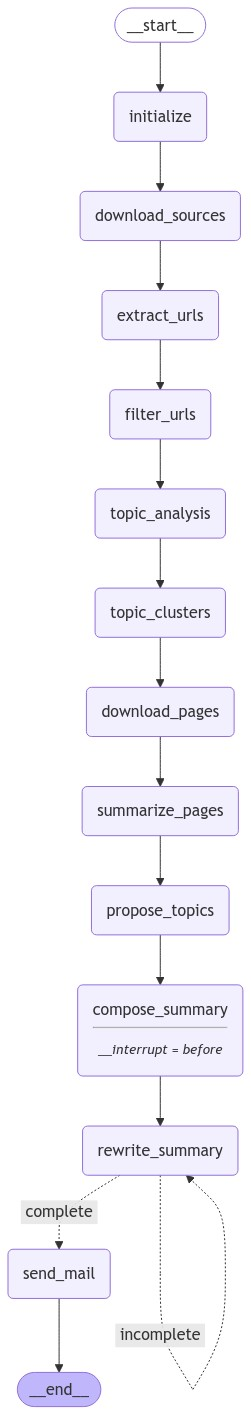

In [55]:
# Image(lg_agent.graph.get_graph().draw_png())
Image(lg_agent.app.get_graph().draw_mermaid_png())


In [ ]:
# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4()

config = {"configurable": {"thread_id": thread_id}}
# initial state
state = AgentState()
do_download = True
state["do_download"] = do_download
# before_date="2024-07-22 10:00:00"
# state["before_date"] = before_date
log(f"Starting with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent.run(config, state)


In [ ]:
user_approval = input("Edit topics? (yes/no): ")


In [ ]:
if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in lg_agent.graph.stream(None, config, stream_mode="debug"):
        if step["type"] == "checkpoint":
            display(f'Step {step["step"]}')
else:
    print("Operation cancelled by user.")


In [ ]:
# get last state
last_state = lg_agent.graph.get_state(config)
pd.DataFrame(last_state.values['AIdf'])


In [ ]:
# update state as node
# lg_agent.graph.update_state(config, {"foo": 2, "bar": ["b"]}, as_node="revise_summary")


In [ ]:
# resume from error starting at a node
# result = lg_agent.graph.invoke(None, {'configurable': {'thread_id': 'newsbot-thread-5'}, "next": "topic_analysis"})